# Innotech_Diploma

## Предисловие

##### Стратегия выполнения работы была выбрана следующая: инвестировать максимальное количество времени и сил в анализ данных, предметную область данных и в обработку данных:
##### - обработка данных, в том числе feature engineering, - залог успешного обучения модели на хороших данных;
##### - понимание предметной области, в данном случае это бухгалтерская, юридическая, экономическая области, крайне важно для грамотной обработки данных;
##### - для построения модели разработаны эффективные библиотеки, которые разумно использовать в целях экономии времени в пользу анализа и обработки данных.

## Import Section

In [1]:
import numpy as np
import pandas as pd

from scipy import stats

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import catboost

from sklearn.metrics import classification_report

## Settings Section

In [2]:
# Random State для всех дальнейших операций.
settings_random_state = 1

# Написание чисел без сокращений для удобства восприятия.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)

# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')
# pd.reset_option('display.width')
# pd.reset_option('display.float_format')
# pd.reset_option('display.max_colwidth') 

## Function "Reduce Memory Usage"

In [3]:
def reduce_memory_usage(df):
    
    # СДЕЛАТЬ ПРОВЕРКУ type(df) == pd.DataFrame
    
    initial_memory_usage = df.memory_usage().sum() / 1024 / 1024
    print(f'Initial memory usage of dataframe:\t{initial_memory_usage:.3} Mb')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            # Можно было бы сделать оптимизацию вплоть до типа "float16", однако данный тип данных,
            # как сообщается от сообщества аналитиков данных, плохо поддерживается некоторыми библиотеками
            
            if str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float64).min and c_max < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
        
        else:
            df[col] = df[col].astype('category')
    
    final_memory_usage = df.memory_usage().sum() / 1024 / 1024
    print(f'Final memory usage of dataframe:\t{final_memory_usage:.3} Mb')
    
    comparison = np.round(100 * (initial_memory_usage - final_memory_usage) / initial_memory_usage, 3)
    print(f'Memory usage has been decreased by:\t{comparison} %')
    
    return df

## Path Section

In [4]:
PATH_DATA = r'train_dataset_bank.csv'

## Exploratory Data Analysis

In [5]:
# df_data = pd.read_csv(PATH_DATA, sep=';', encoding='ISO-8859-1')
df_data = pd.read_csv(PATH_DATA, sep=';', encoding='cp1251')

In [6]:
df_data.head(5)

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,F2220,F2300,F2310,F2320,F2330,F2340,F2350,F2400,F2410,F1150_LAG1,F1230_LAG1,F1410_LAG1,F1510_LAG1,F1520_LAG1,F2110_LAG1,F2120_LAG1,F2200_LAG1,F2210_LAG1,F2220_LAG1,F2300_LAG1,F2320_LAG1,F2330_LAG1,F2400_LAG1,EGRPOINCLUDED,DATEFIRSTREG,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,OKATO_REGIONCODE,OKATO_FED,OKTMO_CODE,OKTMO_FED,WORKERSRANGE,TAXREG_REGDATE,TAXREGPAY_REGDATE,COUNTCOOWNERFCSM,COUNTCOOWNERROSSTAT,COUNTCOOWNEREGRUL,COUNTBRANCH,COUNTBRANCHROSSTAT,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
0,1,1847,01JAN2018:00:00:00,0,0,"1,298,961,000.00","2,154,000.00","1,125,573,000.00",NaN,"150,010,000.00",NaN,"21,224,000.00","10,482,866,000.00","105,901,000.00","127,510,000.00","9,477,348,000.00","440,671,000.00","331,298,000.00","138,000.00","1,960,896,000.00","10,007,000.00","-46,634,000.00","599,497,000.00","500,000.00","1,028,878,000.00","340,135,000.00",NaN,"340,135,000.00",NaN,"9,480,796,000.00","2,499,973,000.00","6,907,960,000.00",NaN,NaN,"11,781,827,000.00","11,781,827,000.00","2,370,882,000.00","52,941,040,000.00","50,570,158,000.00","631,752,000.00","1,083,075,000.00","656,055,000.00","88,347,000.00",NaN,"106,919,000.00","293,404,000.00","1,122,418,000.00","1,479,338,000.00","39,087,000.00","-19,204,000.00","1,031,700,000.00","9,179,060,000.00",NaN,"2,112,180,000.00","7,426,504,000.00","49,557,243,000.00","46,486,800,000.00","556,508,000.00","1,424,790,000.00","1,089,145,000.00","240,114,000.00","137,626,000.00","310,096,000.00","76,258,000.00",1.00,10AUG1993:00:00:00,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и общественных объединений,3.00,40.00,"3,701,000,001.00",40.00,1001 .. 5000,01JUL2006:00:00:00,01JAN1960:00:00:00,5.00,1.00,0.00,8.00,7.00,7.00,3.00,0.00,0.00,0.00,35.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,4650,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4770,01JAN2018:00:00:00,0,0,"73,374,000.00",NaN,"73,374,000.00",NaN,NaN,NaN,NaN,"21,610,000.00","2,378,000.00",NaN,"17,642,000.00","1,000,000.00","553,000.00","37,000.00","90,736,000.00","100,000.00",NaN,"6,780,000.00",NaN,"83,856,000.00",NaN,NaN,NaN,NaN,"4,248,000.00",NaN,"4,171,000.00","77,000.00",NaN,"94,984,000.00","94,984,000.00","9,315,000.00","52,184,000.00","42,869,000.00","2,569,000.00",NaN,"6,746,000.00","1,190,000.00",NaN,"50,000.00",NaN,"65,000.00","1,494,000.00","655,000.00",NaN,"70,674,000.00

In [7]:
df_data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17891 entries, 0 to 17890
Data columns (total 124 columns):
 #    Column                      Non-Null Count  Dtype  
---   ------                      --------------  -----  
 0    id_contract                 17891 non-null  int64  
 1    id_client                   17891 non-null  int64  
 2    SIGN_DATE                   17891 non-null  object 
 3    IP_flag                     17891 non-null  int64  
 4    TARGET                      17891 non-null  int64  
 5    F1100                       6936 non-null   float64
 6    F1110                       1420 non-null   float64
 7    F1150                       6341 non-null   float64
 8    F1160                       346 non-null    float64
 9    F1170                       1499 non-null   float64
 10   F1180                       2500 non-null   float64
 11   F1190                       1520 non-null   float64
 12   F1200                       11850 non-null  float64
 13   F1210         

##### Большое количество признаков сигнализирует о том, что потребуется feature engineering: модель не успеет эффективно обучиться при данном соотношении количества признаков и количестве записей.

#### Вывод: стратегия обработки - понижение размерности с сохранением информативности.

### Пропуски

##### Визуально можно наблюдать наличие пропусков, попробуем оценить долю пропусков в данных.

##### p.s. Наличие признака "OKVED_CODE" намекает на происхождение набора данных из России.

In [8]:
df_nulls = df_data.isna().sum()
df_nulls = np.round(df_nulls / df_data.shape[0] * 100)
df_nulls = df_nulls.sort_values(ascending=False)
df_nulls.head()

FLAG_DISQUALIFICATION                 100.00
F1320                                  99.00
COUNT_CHANGE_YEAR                      99.00
F1160                                  98.00
F2310                                  98.00
dtype: float64

<AxesSubplot:>

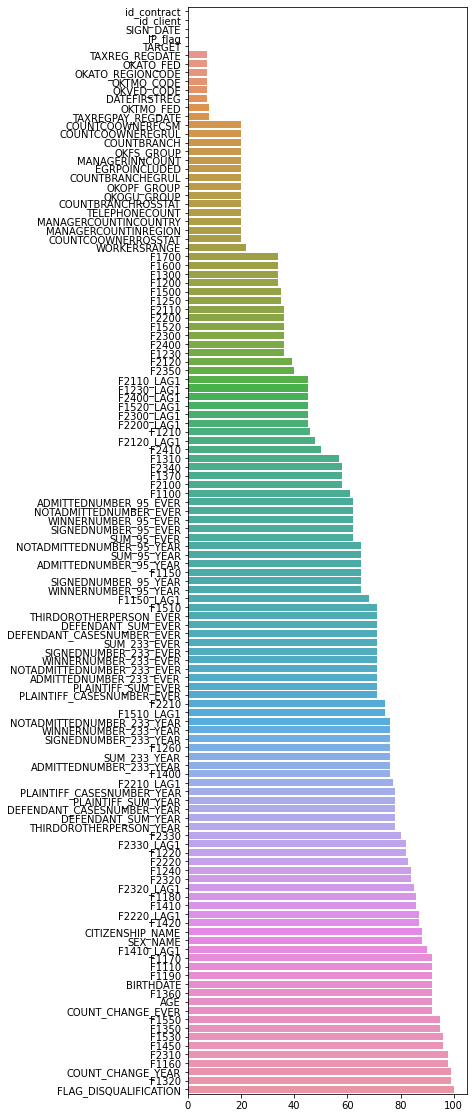

In [9]:
df_nulls = df_nulls.sort_values(ascending=True)

plt.figure(figsize=(5, 20))
sns.barplot(x=df_nulls, y=df_nulls.index, orient='h')

In [10]:
print(f'Количество признаков с пропусками 100%:\t\t\t{df_nulls[df_nulls == 100].shape[0]}')
print(f'Количество признаков с пропусками от 90% до 100%:\t{df_nulls[(df_nulls > 90) & (df_nulls < 100)].shape[0]}')
print(f'Количество признаков с пропусками от 80% до 90%:\t{df_nulls[(df_nulls > 80) & (df_nulls <= 90)].shape[0]}')
print(f'Количество признаков с пропусками от 70% до 80%:\t{df_nulls[(df_nulls > 70) & (df_nulls <= 80)].shape[0]}')
print(f'Количество признаков с пропусками от 60% до 70%:\t{df_nulls[(df_nulls > 60) & (df_nulls <= 70)].shape[0]}')
print(f'Количество признаков с пропусками от 50% до 60%:\t{df_nulls[(df_nulls > 50) & (df_nulls <= 60)].shape[0]}')
print(f'Количество признаков с пропусками от 40% до 50%:\t{df_nulls[(df_nulls > 40) & (df_nulls <= 50)].shape[0]}')
print(f'Количество признаков с пропусками от 30% до 40%:\t{df_nulls[(df_nulls > 30) & (df_nulls <= 40)].shape[0]}')
print(f'Количество признаков с пропусками от 20% до 30%:\t{df_nulls[(df_nulls > 20) & (df_nulls <= 30)].shape[0]}')
print(f'Количество признаков с пропусками от 10% до 20%:\t{df_nulls[(df_nulls > 10) & (df_nulls <= 20)].shape[0]}')
print(f'Количество признаков с пропусками от 00% до 10%:\t{df_nulls[(df_nulls > 0) & (df_nulls <= 10)].shape[0]}')
print(f'Количество признаков без пропусков:\t\t\t{df_nulls[df_nulls == 0].shape[0]}')

Количество признаков с пропусками 100%:			1
Количество признаков с пропусками от 90% до 100%:	15
Количество признаков с пропусками от 80% до 90%:	13
Количество признаков с пропусками от 70% до 80%:	27
Количество признаков с пропусками от 60% до 70%:	13
Количество признаков с пропусками от 50% до 60%:	4
Количество признаков с пропусками от 40% до 50%:	9
Количество признаков с пропусками от 30% до 40%:	14
Количество признаков с пропусками от 20% до 30%:	1
Количество признаков с пропусками от 10% до 20%:	14
Количество признаков с пропусками от 00% до 10%:	8
Количество признаков без пропусков:			5


In [11]:
df_nulls[df_nulls > 50].shape[0], df_nulls.shape[0], np.round(df_nulls[df_nulls > 50].shape[0] / df_nulls.shape[0] * 100, 2)

(73, 124, 58.87)

##### Набор данных обладает значительным количеством пропусков. А именно, 73 признака из 124, что примерно ~58% всех признаков, имеют пропуски более 50%, что затрудняет эффективную обработку пропусков.

In [12]:
df_nulls[df_nulls > 90]

F1170                                  92.00
F1110                                  92.00
F1190                                  92.00
BIRTHDATE                              92.00
F1360                                  92.00
AGE                                    92.00
COUNT_CHANGE_EVER                      92.00
F1550                                  95.00
F1350                                  95.00
F1530                                  96.00
F1450                                  96.00
F2310                                  98.00
F1160                                  98.00
COUNT_CHANGE_YEAR                      99.00
F1320                                  99.00
FLAG_DISQUALIFICATION                 100.00
dtype: float64

##### Однако, характер происхождения признаков может помочь в итерпретации пропусков. Например, рассмотрим признак "F1320" (Собственные акции, выкупленные у акционеров) или "F1160" (Доходные вложения в материальные ценности), информация о данных признаках может быть получения из государственных или частных реестров. В таком случае, отсутствие полученной информации может свидетельствовать об отсутствии соответствующих записей в реестрах, что свидетельствует об отсутствии факта свершения данного события.

#### Вывод: пропуски бухгалтерских признаков могут быть заполнены нулевыми значениями.

### Признаки, описывающие персональные данные клиента

In [13]:
df_nulls[['BIRTHDATE', 'AGE', 'SEX_NAME', 'CITIZENSHIP_NAME']]

BIRTHDATE                         92.00
AGE                               92.00
SEX_NAME                          88.00
CITIZENSHIP_NAME                  88.00
dtype: float64

##### Также обратим внимание на персональные признаки "BIRTHDATE", "AGE", "SEX_NAME", "CITIZENSHIP_NAME".

##### Данные признаки имет значительное количество пропусков. Каждый клиент обладает данной персональной характеристикой, то есть нельзя как-то иначе интерпретировать отсутствие этой информации. Также стоит заметить, что результативная генерация данной информации с целью заполнения пропусков невозможна и нецелесообразна. Более того, для решения задачи необходимо разработать общий алгоритм оценки клиента, анонимного абстрактного клиента, а не конкретного человека.

#### Вывод: такие признаки, описывающие индивидуальные данные клиента, как "id_contract", "id_client", "BIRTHDATE", "AGE", "SEX_NAME", "CITIZENSHIP_NAME" следует исключить из дальшейшего рассмотрения.

### Дубликаты

##### Проверим набор данных на наличие дубликатов, при этом исключим все персональные данные клиента: признаки "id_contract", "id_client", "BIRTHDATE", "AGE", "SEX_NAME", "CITIZENSHIP_NAME".

In [14]:
columns_non_personal = df_data.columns[2:-4]
columns_non_personal

Index(['SIGN_DATE', 'IP_flag', 'TARGET', 'F1100', 'F1110', 'F1150', 'F1160', 'F1170', 'F1180', 'F1190',
       ...
       'SIGNEDNUMBER_95_YEAR', 'SUM_95_YEAR', 'ADMITTEDNUMBER_95_EVER', 'NOTADMITTEDNUMBER_EVER', 'WINNERNUMBER_95_EVER', 'SIGNEDNUMBER_95_EVER', 'SUM_95_EVER', 'FLAG_DISQUALIFICATION', 'COUNT_CHANGE_YEAR', 'COUNT_CHANGE_EVER'], dtype='object', length=118)

In [15]:
data_duplicates = df_data[columns_non_personal].duplicated()
data_duplicates[data_duplicates == True].shape[0]

2809

##### Вне контекста персональных признаков в наборе данных были обнаружены 2809 записей-дубликатов. Данные записи могут свидетельствовать о похожих клиентах или об одном и том же клиенте, который имеет несколько контрактов в банке. С точки зрения машинного обучения нам необходимо рассматривать уникальные ситуации с уникальными значениями признаков, чтобы выявить их влияние на целевую переменную. Поэтому данные записи-дубликаты необходимо ислючить из набора данных.

#### Вывод: удаляем дубликаты без учёта персональных данных.

### "SIGN_DATE" (Дата подписания контракта)

In [16]:
df_data['SIGN_DATE'].head()

0    01JAN2018:00:00:00
1    01JAN2018:00:00:00
2    01JAN2018:00:00:00
3    01JAN2018:00:00:00
4    01JAN2018:00:00:00
Name: SIGN_DATE, dtype: object

##### Данный признак может быть преобразован в более удобный формат.

In [17]:
pd.to_datetime(df_data['SIGN_DATE'], format='%d%b%Y:%H:%M:%S').head()

0   2018-01-01
1   2018-01-01
2   2018-01-01
3   2018-01-01
4   2018-01-01
Name: SIGN_DATE, dtype: datetime64[ns]

In [18]:
pd.to_datetime(df_data['SIGN_DATE'], format='%d%b%Y:%H:%M:%S').min()

Timestamp('2018-01-01 00:00:00')

In [19]:
pd.to_datetime(df_data['SIGN_DATE'], format='%d%b%Y:%H:%M:%S').max()

Timestamp('2019-04-08 00:00:00')

##### Данный признак не содержит пропусков, что хорошо, достоверная(?) информация о каждой записи.

##### Данный признак может быть использован для получения длительности заключения контракта, предположение: "длительные" клиенты более надёжны. Длительность может быть вычислена в месяцах или днях в угоду большей точности. Для получения длительности необходимо установить дату, до которой будет вычислена продолжительность. В качестве верхнего интервала продолжительности контракта выберем максимальную дату из всех дат данного признака. Данный выбор обусловлен предположением, что банк стабильно заключает новые контракты и последняя дата заключения свидетельствует о дате сбора рассматриваемого набора данных. Одновременно с этим, выбор максимальный даты также позволит масштабировать продолжительность.

#### Вывод: пересчитать признак "SIGN_DATE" (Дата подписания контракта) в количество дней от последней даты.

### "F1100" (Внеоборотные активы)

##### Изучение Википедии (https://ru.wikipedia.org/wiki/Внеоборотные_активы) и других источников (https://www.business.ru/blog/63-kak-sostavit-buhgalterskiy-balans), (https://glavkniga.ru/situations/k503390), (https://www.b-kontur.ru/enquiry/980-otchet-o-finansovyh-rezultatah) позволило установить, что признак "F1100" (Внеоборотные активы) фактически состоит из суммы следующих других признаков:
##### - "F1110" (Нематериальные активы);
##### - "F1150" (Основные средства);
##### - "F1160" (Доходные вложения в материальные ценности);
##### - "F1170" (Долгосрочные финансовые вложения)
##### - "F1180" (Отложенные налоговые активы)
##### - "F1190" (Прочие внеоборотные активы)
##### Таким образом, признак "F1100" должен включать в себя все другие признаки раздела I «Внеоборотные активы». Проверим данное предположение:

In [20]:
df_data[df_data['F1100'] == 0].shape[0]

0

##### Изначально значения признака "F1100" не равны нулю, что в случае заполнения пропусков нулями позволит идентифицировать обработанные пропуски.

In [21]:
# Определим признаки раздела I «Внеоборотные активы».
columns_group_1 = ['F1100', 'F1110', 'F1150', 'F1160', 'F1170', 'F1180', 'F1190']

# Создадим отдельный набор данных для их рассмотрения.
df_data_group_1 = df_data[columns_group_1].copy()

# Заполним пропуски нулями из предположения: отсутствие информации = отсутствие записи в реестрах.
df_data_group_1 = df_data_group_1.fillna(0)

# Создадим новый столбец "Sum" с суммой признаков 'F1110', 'F1150', 'F1160', 'F1170', 'F1180', 'F1190'.
df_data_group_1['Sum'] = df_data_group_1[columns_group_1[1:]].sum(axis=1)

# Рассмотрим только те записи, где признак "F1100" (Внеоборотные активы) меньше суммы своих составляющих признаков.
df_data_group_1[df_data_group_1['F1100'] < df_data_group_1['Sum']].describe()

,F1100,F1110,F1150,F1160,F1170,F1180,F1190,Sum
count,109.00,109.00,109.00,109.00,109.00,109.00,109.00,109.00
mean,"616,762,412.84","2,860,321.10","582,567,614.68","849,522.94","2,911,211.01","14,518,596.33","13,554,889.91","617,262,155.96"
std,"3,228,519,586.50","19,412,805.56","3,126,763,687.37","4,328,071.38","17,553,580.36","87,804,759.85","125,799,151.60","3,228,428,098.89"
min,"-182,000.00",0.00,0.00,0.00,0.00,"-220,000.00",0.00,"-181,000.00"
25%,"161,000.00",0.00,"43,000.00",0.00,0.00,"11,000.00",0.00,"425,000.00"
50%,"31,757,000.00",0.00,"24,286,000.00",0.00,0.00,"119,000.00",0.00,"34,844,000.00"
75%,"163,451,000.00","10,000.00","132,578,000.00",0.00,0.00,"767,000.00","220,000.00","163,452,000.00"
max,"23,795,050,000.00","188,534,000.00","23,138,658,000.00","30,250,000.00","173,818,000.00","651,923,000.00","1,312,565,000.00","23,795,051,000.00"


##### В процессе рассмотрения было обнаружено, что минимальное значение признака "F1100" (Внеоборотные активы) меньше нуля, что свидетельствует об ошибке.

In [22]:
df_data_group_1[df_data_group_1['F1100'] < 0]

,F1100,F1110,F1150,F1160,F1170,F1180,F1190,Sum
12146,"-182,000.00","39,000.00",0.00,0.00,0.00,"-220,000.00",0.00,"-181,000.00"


##### Одна запись с некорректными значениями, что позволяет исключить её из набора данных или обработать всяв модуль значения.

##### Продолжим анализ признака "F1100".

In [23]:
df_data_group_1['Difference'] = df_data_group_1['F1100'] - df_data_group_1['Sum']
df_data_group_1.loc[df_data_group_1['Difference'] < 0, 'Difference'].value_counts()

     -1,000.00    107
-53,765,000.00      1
   -600,000.00      1
Name: Difference, dtype: int64

##### Всего наблюдается 109 записей, где признак "F1100" (Внеоборотные активы) меньше суммы своих составляющих признаков.
##### При этом большинство записей имеют пренебрежимо малое отклонение, и только две записи имеют существенные отклонения. Рассмотрим их подробнее.

In [24]:
df_data_group_1[df_data_group_1['Difference'] < -1000]

,F1100,F1110,F1150,F1160,F1170,F1180,F1190,Sum,Difference
3364,0.00,0.00,"53,763,000.00",0.00,"2,000.00",0.00,0.00,"53,765,000.00","-53,765,000.00"
13829,"330,032,000.00",0.00,"327,895,000.00",0.00,0.00,"2,737,000.00",0.00,"330,632,000.00","-600,000.00"


In [25]:
print(f'{np.round(600000.0 / 330032000.0 * 100, 2)}%')

0.18%


##### При этом в первом случае большая разница возникла из-за заполнения пропуска признака "F1100" нулём, а во втором случае разница составляет менее 1%, что также позволяет ей пренебречь.

##### Рассмотрим оставшиеся 107 строк, где разница достигает 1000. Выполним дисперсионный анализ признака "F1100" и суммы его составляющих для этих строк, чтобы оценить статистическую важность различий при $\alpha$ = 5%.

##### H0: нет статистически значимых различий.
##### H1: есть статистически значимые различия.

In [26]:
stats.f_oneway(df_data_group_1.loc[df_data_group_1['Difference'] == -1000, 'Sum'],
              df_data_group_1.loc[df_data_group_1['Difference'] == -1000, 'F1100'])

F_onewayResult(statistic=5.0397674056354815e-12, pvalue=0.9999982114221186)

##### С высокой уверенностью (P-value = ~1 > $\alpha$ = 0.05) можно утверждать, что в остальных 107 записях признак "F1100" и сумма его составляющих не имеют статистически значимых различий.

##### Также рассмотрим значимость различий по всем значениям.

In [27]:
stats.f_oneway(df_data_group_1.loc[:, 'Sum'],
              df_data_group_1.loc[:, 'F1100'])

F_onewayResult(statistic=0.06563260626161362, pvalue=0.7978066724005861)

##### Таким образом, предположение подтвердилось: признак "F1100" действительно является суммой своих составляющих признаков раздела I «Внеоборотные активы».

#### Вывод 1: пропуски признака "F1100" могут быть восстановлены как сумма составляющих признака.

#### Вывод 2: в целях понижения размерности из группы 'F1100', 'F1110', 'F1150', 'F1160', 'F1170', 'F1180', 'F1190' может быть оставлен только один признак 'F1100'.

#### Вывод 3: для компенсации потери информативности может быть сгенерирован новый категориальный признак "F1100_main". Новый признак будет отображать какой из составляющих признаков 'F1110', 'F1150', 'F1160', 'F1170', 'F1180', 'F1190' является максимальной долей от признака 'F1100'. Данная информация позволит указать характер признака "F1100" (Внеоборотные активы), какие именно активы преобладают в разделе I «Внеоборотные активы».

### "F1200" (Оборотные активы)

##### Аналогично проверим предположение, что признак "F1200" состоит из признаков раздела II «Оборотные активы».

In [28]:
df_data[df_data['F1200'] == 0].shape[0]

0

##### Изначально значения признака "F1200" не равны нулю, что в случае заполнения пропусков нулями позволит идентифицировать обработанные пропуски.

In [29]:
# Определим признаки раздела II «Оборотные активы».
columns_group_2 = ['F1200', 'F1210', 'F1220', 'F1230', 'F1240', 'F1250', 'F1260']

# Создадим отдельный набор данных для их рассмотрения.
df_data_group_2 = df_data[columns_group_2].copy()

# Заполним пропуски нулями из предположения: отсутствие информации = отсутствие записи в реестрах.
df_data_group_2 = df_data_group_2.fillna(0)

# Создадим новый столбец "Sum" с суммой признаков 'F1210', 'F1220', 'F1230', 'F1240', 'F1250', 'F1260'.
df_data_group_2['Sum'] = df_data_group_2[columns_group_2[1:]].sum(axis=1)

# Рассмотрим только те записи, где признак "F1200" (Оборотные активы) меньше суммы своих составляющих признаков.
df_data_group_2[df_data_group_2['F1200'] < df_data_group_2['Sum']].describe()

,F1200,F1210,F1220,F1230,F1240,F1250,F1260,Sum
count,331.00,331.00,331.00,331.00,331.00,331.00,331.00,331.00
mean,"918,264,283.99","269,431,755.29","7,879,057.40","427,584,187.31","125,439,401.81","107,727,622.36","3,062,057.40","941,124,081.57"
std,"5,246,304,583.32","2,406,021,820.43","49,325,697.91","2,482,880,213.05","756,716,666.07","776,536,209.63","11,989,737.41","5,250,488,098.07"
min,0.00,0.00,"-8,000.00","15,000.00",0.00,"-12,000.00","-3,701,000.00","222,000.00"
25%,"20,273,000.00","868,500.00",0.00,"7,409,500.00",0.00,"758,000.00",0.00,"22,384,500.00"
50%,"96,047,000.00","10,883,000.00","3,000.00","49,727,000.00",0.00,"3,669,000.00","54,000.00","98,923,000.00"
75%,"303,127,500.00","50,399,000.00","978,000.00","158,547,500.00","7,910,000.00","25,704,000.00","519,000.00","321,579,500.00"
max,"62,132,501,000.00","30,829,263,000.00","610,844,000.00","30,365,282,000.00","6,693,144,000.00","7,095,494,000.00","129,455,000.00","62,132,502,000.00"


In [30]:
df_data[df_data['F1200'] < 0][columns_group_2]

,F1200,F1210,F1220,F1230,F1240,F1250,F1260
2090,"-295,000.00",NaN,NaN,"45,000.00",NaN,"-340,000.00",NaN


##### Также присутствуют записи с отрицательными значениями.

In [31]:
df_data_group_2['Difference'] = df_data_group_2['F1200'] - df_data_group_2['Sum']
df_data_group_2.loc[df_data_group_2['Difference'] < 0, 'Difference'].value_counts()

        -1,000.00    311
        -2,000.00     16
-3,778,886,000.00      2
    -1,044,000.00      1
    -7,434,000.00      1
Name: Difference, dtype: int64

##### Рассмотрим подробнее записи с существенной разницей признака "F1200" и его составляющих.

In [32]:
df_data_group_2[df_data_group_2['Difference'] < -2000]

,F1200,F1210,F1220,F1230,F1240,F1250,F1260,Sum,Difference
1606,"25,186,000.00","1,056,000.00","1,043,000.00","21,026,000.00",0.00,"3,105,000.00",0.00,"26,230,000.00","-1,044,000.00"
3364,0.00,"860,000.00",0.00,"6,550,000.00",0.00,"24,000.00",0.00,"7,434,000.00","-7,434,000.00"
14564,0.00,"54,517,000.00","295,000.00","3,641,282,000.00",0.00,"82,615,000.00","177,000.00","3,778,886,000.00","-3,778,886,000.00"
15357,0.00,"54,517,000.00","295,000.00","3,641,282,000.00",0.00,"82,615,000.00","177,000.00","3,778,886,000.00","-3,778,886,000.00"


In [33]:
print(f'{np.round(1.044000e+06 / 25186000.0 * 100, 2)}%')

4.15%


##### В трёх случаях большая разница возникла из-за пропусков признака "F1200", ещё в одном случае разница составляет около ~4%.

##### Аналогично проверим статистическую значимость различий признака "F1200" и его составляющих для остальных записей с разницей 1000 или 2000 при $\alpha$ = 0.05.

##### H0: нет статистически значимых различий.
##### H1: есть статистически значимые различия.

In [34]:
stats.f_oneway(df_data_group_2.loc[(df_data_group_2['Difference'] == -1000) | (df_data_group_2['Difference'] == -2000), 'Sum'],
              df_data_group_2.loc[(df_data_group_2['Difference'] == -1000) | (df_data_group_2['Difference'] == -2000), 'F1200'])

F_onewayResult(statistic=6.4590436162686845e-12, pvalue=0.9999979642534611)

##### Также рассмотрим значимость различий по всем значениям.

In [35]:
stats.f_oneway(df_data_group_2.loc[:, 'Sum'],
              df_data_group_2.loc[:, 'F1200'])

F_onewayResult(statistic=1.7475065230485613e-05, pvalue=0.9966646210488218)

##### Предположение подтвердилось, статистически значимой разницы не наблюдается, аналогичные выводы:

#### Вывод 1: пропуски признака "F1200" могут быть восстановлены как сумма составляющих признака.

#### Вывод 2: в целях понижения размерности из группы 'F1200', 'F1210', 'F1220', 'F1230', 'F1240', 'F1250', 'F1260' может быть оставлен только один признак 'F1200'.

#### Вывод 3: для компенсации потери информативности может быть сгенерирован новый категориальный признак "F1200_main". Новый признак будет отображать какой из составляющих признаков 'F1210', 'F1220', 'F1230', 'F1240', 'F1250', 'F1260' является максимальной долей от признака 'F1200'. Данная информация позволит указать характер признака "F1200" (Оборотные активы), какие именно активы преобладают в разделе II «Оборотные активы».

### "F1300" (Капитал и резервы)

##### Аналогично проверим предположение, что признак "F1300" состоит из признаков раздела III «Капитал и резервы».

In [36]:
df_data[df_data['F1300'] == 0].shape[0]

0

##### Изначально значения признака "F1300" не равны нулю, что в случае заполнения пропусков нулями позволит идентифицировать обработанные пропуски.

In [37]:
# Определим признаки раздела III «Капитал и резервы».
columns_group_3 = ['F1300', 'F1310', 'F1320', 'F1350', 'F1360', 'F1370']

# Создадим отдельный набор данных для их рассмотрения.
df_data_group_3 = df_data[columns_group_3].copy()

# Заполним пропуски нулями из предположения: отсутствие информации = отсутствие записи в реестрах.
df_data_group_3 = df_data_group_3.fillna(0)

# Создадим новый столбец "Sum" с суммой признаков 'F1310', 'F1320', 'F1350', 'F1360', 'F1370'.
df_data_group_3['Sum'] = df_data_group_3[columns_group_3[1:]].sum(axis=1)

# Рассмотрим только те записи, где признак "F1300" (Капитал и резервы) меньше суммы своих составляющих признаков.
df_data_group_3[df_data_group_3['F1300'] < df_data_group_3['Sum']].describe()

,F1300,F1310,F1320,F1350,F1360,F1370,Sum
count,337.00,337.00,337.00,337.00,337.00,337.00,337.00
mean,"56,948,869.44","5,700,896.14",0.00,"4,660,008.90","113,284.87","49,431,456.97","59,905,646.88"
std,"730,930,194.50","49,674,439.21",0.00,"31,457,012.47","1,051,305.08","713,391,101.51","730,688,837.00"
min,"-76,794,000.00",0.00,0.00,0.00,0.00,"-427,870,000.00","-73,164,000.00"
25%,"-2,928,000.00",0.00,0.00,0.00,0.00,0.00,0.00
50%,"-517,000.00",0.00,0.00,0.00,0.00,0.00,0.00
75%,"-55,000.00",0.00,0.00,0.00,0.00,0.00,0.00
max,"13,340,886,000.00","750,084,000.00",0.00,"287,329,000.00","13,596,000.00","13,037,203,000.00","13,340,887,000.00"


##### Также присутствуют записи с отрицательными значениями.

In [38]:
df_data[df_data['F1300'] < 0][columns_group_3].head()

,F1300,F1310,F1320,F1350,F1360,F1370
10,"-25,060,000.00","38,256,000.00",NaN,NaN,NaN,"-258,180,000.00"
31,"-388,726,000.00","36,996,000.00",NaN,NaN,"1,850,000.00","-472,245,000.00"
39,"-4,368,000.00","10,000.00",NaN,NaN,NaN,"-4,378,000.00"
45,"-40,286,000.00","19,926,000.00",NaN,NaN,"632,000.00","-60,845,000.00"
49,"-153,754,000.00","6,350,000.00",NaN,NaN,NaN,"-160,104,000.00"


In [39]:
df_data[df_data['F1300'] < 0][columns_group_3].shape[0]

961

##### Данные значения могут быть отрицательными, однако их наличие свидетельствует об убытках и рисках банкротства.

In [40]:
df_data_group_3['Difference'] = np.abs(df_data_group_3['F1300']) - np.abs(df_data_group_3['Sum'])
df_data_group_3.loc[(df_data_group_3['Difference'] < -1000) & (df_data_group_3['F1300'] != 0), :].describe()

,F1300,F1310,F1320,F1350,F1360,F1370,Sum,Difference
count,63.00,63.00,63.00,63.00,63.00,63.00,63.00,63.00
mean,"-469,104,460.32","318,292,238.10","-36,571.43","20,699,063.49","7,111,111.11","-1,415,650,285.71","-1,069,584,444.44","-167,253,031.75"
std,"2,037,620,085.92","1,182,963,782.06","290,276.72","97,660,249.89","30,196,309.88","2,973,202,334.95","2,077,634,153.05","485,626,389.19"
min,"-7,403,883,000.00","1,000.00","-2,304,000.00",0.00,0.00,"-15,476,505,000.00","-9,201,117,000.00","-2,985,797,000.00"
25%,"-487,013,500.00","1,380,000.00",0.00,0.00,0.00,"-1,294,537,000.00","-643,942,000.00","-173,870,500.00"
50%,"-24,133,000.00","36,996,000.00",0.00,0.00,"98,000.00","-286,964,000.00","-224,807,000.00","-42,320,000.00"
75%,"2,844,000.00","59,197,000.00",0.00,0.00,"1,850,000.00","-64,103,000.00","-63,719,500.00","-4,191,500.00"
max,"6,959,772,000.00","6,903,906,000.00",0.00,"699,076,000.00","183,146,000.00","19,304,000.00","219,622,000.00","-100,000.00"


##### В 63 записях разница между признаком "F1300" и его составляющими достигает существенных значений относительно самого признака. При этом данная разница не может быть объяснена заполнением пропусков признака "F1300" нулями, так как рассматриваются записи без нулевых значений упомянутого признака.

##### Рассмотрим статистическую значимость различий признака "F1300" и его составляющих при $\alpha$ = 0.05.

##### H0: нет статистически значимых различий.
##### H1: есть статистически значимые различия.

In [41]:
stats.f_oneway(df_data_group_3.loc[:, 'Sum'],
              df_data_group_3.loc[:, 'F1300'])

F_onewayResult(statistic=0.8463445771285716, pvalue=0.35759470232583423)

##### Таким образом, данные 63 запси явно содержат ошибки, методика исправления которых неясна. Оставим признак "F1300" как приоритетный, а наибольший признак из группы 'F1310', 'F1320', 'F1350', 'F1360', 'F1370' запишем в "F1300_main".

##### Предположение в целом подтвердилось (с меньшей уверенностью, pvalue=~0.36), аналогичные выводы:

#### Вывод 1: пропуски признака "F1300" могут быть восстановлены как сумма составляющих признака.

#### Вывод 2: в целях понижения размерности из группы 'F1300', 'F1310', 'F1320', 'F1350', 'F1360', 'F1370' может быть оставлен только один признак 'F1300'.

#### Вывод 3: для компенсации потери информативности может быть сгенерирован новый категориальный признак "F1300_main". Новый признак будет отображать какой из составляющих признаков 'F1310', 'F1320', 'F1350', 'F1360', 'F1370' является максимальной долей от признака 'F1300'. Данная информация позволит указать характер признака "F1300" (Капитал и резервы), какие именно активы преобладают в разделе III «Капитал и резервы».

### "F1400" (Долгосрочные обязательства)

##### Аналогично проверим предположение, что признак "F1400" состоит из признаков раздела IV «Долгосрочные обязательства».

In [42]:
df_data[df_data['F1400'] == 0].shape[0]

0

##### Изначально значения признака "F1400" не равны нулю, что в случае заполнения пропусков нулями позволит идентифицировать обработанные пропуски.

In [43]:
# Определим признаки раздела IV «Долгосрочные обязательства».
columns_group_4 = ['F1400', 'F1410', 'F1420', 'F1450']

# Создадим отдельный набор данных для их рассмотрения.
df_data_group_4 = df_data[columns_group_4].copy()

# Заполним пропуски нулями из предположения: отсутствие информации = отсутствие записи в реестрах.
df_data_group_4 = df_data_group_4.fillna(0)

# Создадим новый столбец "Sum" с суммой признаков 'F1410', 'F1420', 'F1450'.
df_data_group_4['Sum'] = df_data_group_4[columns_group_4[1:]].sum(axis=1)

# Рассмотрим только те записи, где признак "F1400" (Долгосрочные обязательства) меньше суммы своих составляющих признаков.
df_data_group_4[df_data_group_4['F1400'] < df_data_group_4['Sum']].describe()

,F1400,F1410,F1420,F1450,Sum
count,27.00,27.00,27.00,27.00,27.00
mean,"2,068,796,222.22","1,754,669,111.11","313,811,888.89","1,404,222.22","2,069,885,222.22"
std,"5,520,124,025.68","4,625,393,145.22","896,450,615.10","3,451,089.10","5,519,703,468.22"
min,0.00,0.00,0.00,0.00,"117,000.00"
25%,"12,665,000.00","10,236,000.00","13,000.00",0.00,"14,230,000.00"
50%,"66,980,000.00","66,801,000.00","221,000.00",0.00,"66,981,000.00"
75%,"214,404,000.00","197,141,000.00","1,359,000.00","677,500.00","214,405,000.00"
max,"17,364,198,000.00","14,562,321,000.00","2,801,878,000.00","15,566,000.00","17,364,199,000.00"


##### В результате анализа были выявлены 27 записей, в которых значение признака "F1400" уступает по величине сумме своих составляющих.

##### Рассмотрим статистическую значимость различий признака "F1400" и его составляющих при $\alpha$ = 0.05 для данных записей, а затем для всех записей.

##### H0: нет статистически значимых различий.
##### H1: есть статистически значимые различия.

In [44]:
stats.f_oneway(df_data_group_4.loc[df_data_group_4['F1400'] < df_data_group_4['Sum'], 'Sum'],
              df_data_group_4.loc[df_data_group_4['F1400'] < df_data_group_4['Sum'], 'F1400'])

F_onewayResult(statistic=5.25442193624645e-07, pvalue=0.9994244081034561)

In [45]:
stats.f_oneway(df_data_group_4.loc[:, 'Sum'],
              df_data_group_4.loc[:, 'F1400'])

F_onewayResult(statistic=0.03316370479987438, pvalue=0.8554981810658058)

##### Предположение подтвердилось, статистически значимой разницы не наблюдается, аналогичные выводы:

#### Вывод 1: пропуски признака "F1400" могут быть восстановлены как сумма составляющих признака.

#### Вывод 2: в целях понижения размерности из группы 'F1400', 'F1410', 'F1420', 'F1450' может быть оставлен только один признак 'F1400'.

#### Вывод 3: для компенсации потери информативности может быть сгенерирован новый категориальный признак "F1400_main". Новый признак будет отображать какой из составляющих признаков 'F1410', 'F1420', 'F1450' является максимальной долей от признака 'F1400'. Данная информация позволит указать характер признака "F1400" (Долгосрочные обязательства), какие именно активы преобладают в разделе IV «Долгосрочные обязательства».

### "F1500" (Краткосрочные обязательства)

##### Аналогично проверим предположение, что признак "F1500" состоит из признаков раздела V «Краткосрочные обязательства».

In [46]:
df_data[df_data['F1500'] == 0].shape[0]

0

##### Изначально значения признака "F1500" не равны нулю, что в случае заполнения пропусков нулями позволит идентифицировать обработанные пропуски.

In [47]:
# Определим признаки раздела V «Краткосрочные обязательства».
columns_group_5 = ['F1500', 'F1510', 'F1520', 'F1530', 'F1550']

# Создадим отдельный набор данных для их рассмотрения.
df_data_group_5 = df_data[columns_group_5].copy()

# Заполним пропуски нулями из предположения: отсутствие информации = отсутствие записи в реестрах.
df_data_group_5 = df_data_group_5.fillna(0)

# Создадим новый столбец "Sum" с суммой признаков 'F1510', 'F1520', 'F1530', 'F1550'.
df_data_group_5['Sum'] = df_data_group_5[columns_group_5[1:]].sum(axis=1)

# Рассмотрим только те записи, где признак "F1400" (Краткосрочные обязательства) меньше суммы своих составляющих признаков.
df_data_group_5[df_data_group_5['F1500'] < df_data_group_5['Sum']].describe()

,F1500,F1510,F1520,F1530,F1550,Sum
count,199.00,199.00,199.00,199.00,199.00,199.00
mean,"374,509,728.64","263,612,547.74","104,777,567.84","3,636,291.46","2,638,376.88","374,664,783.92"
std,"225,634,528.38","167,875,743.17","79,293,097.36","44,402,899.28","20,633,882.89","225,409,774.75"
min,0.00,0.00,"18,000.00",0.00,0.00,"19,000.00"
25%,"167,911,500.00","27,454,500.00","113,178,000.00",0.00,0.00,"167,912,500.00"
50%,"475,124,000.00","361,947,000.00","113,178,000.00",0.00,0.00,"475,125,000.00"
75%,"475,124,000.00","361,947,000.00","113,178,000.00",0.00,0.00,"475,125,000.00"
max,"1,270,529,000.00","686,200,000.00","575,843,000.00","625,294,000.00","168,672,000.00","1,270,530,000.00"


##### В результате анализа были выявлены 199 записей, в которых значение признака "F1500" уступает по величине сумме своих составляющих.

##### Рассмотрим статистическую значимость различий признака "F1500" и его составляющих при $\alpha$ = 0.05 для данных записей, а затем для всех записей.

##### H0: нет статистически значимых различий.
##### H1: есть статистически значимые различия.

In [48]:
stats.f_oneway(df_data_group_5.loc[df_data_group_5['F1500'] < df_data_group_5['Sum'], 'Sum'],
              df_data_group_5.loc[df_data_group_5['F1500'] < df_data_group_5['Sum'], 'F1500'])

F_onewayResult(statistic=4.70346221380733e-05, pvalue=0.9945314611409326)

In [49]:
stats.f_oneway(df_data_group_5.loc[:, 'Sum'],
              df_data_group_5.loc[:, 'F1500'])

F_onewayResult(statistic=0.3523111379505074, pvalue=0.5528115097237729)

##### Предположение подтвердилось, статистически значимой разницы не наблюдается (с меньшей уверенностью, pvalue=0.55), аналогичные выводы:

#### Вывод 1: пропуски признака "F1500" могут быть восстановлены как сумма составляющих признака.

#### Вывод 2: в целях понижения размерности из группы 'F1500', 'F1510', 'F1520', 'F1530', 'F1550' может быть оставлен только один признак 'F1500'.

#### Вывод 3: для компенсации потери информативности может быть сгенерирован новый категориальный признак "F1500_main". Новый признак будет отображать какой из составляющих признаков 'F1510', 'F1520', 'F1530', 'F1550' является максимальной долей от признака 'F1500'. Данная информация позволит указать характер признака "F1500" (Краткосрочные обязательства), какие именно активы преобладают в разделе V «Краткосрочные обязательства».

### "F1600" (Активы  всего)

##### Согласно бухгалтерским нормативам, данный признак "F1600" должен являться суммой признаков "F1100" и "F1200". Проверим данное предположение.

In [50]:
stats.f_oneway(df_data.loc[:, 'F1600'].fillna(0),
              df_data.loc[:, ['F1100', 'F1200']].fillna(0).sum(axis=1))

F_onewayResult(statistic=1.446997803141112e-08, pvalue=0.999904017536015)

##### Действительно наблюдается отсутствие статистически значимых различий между признаком "F1600" и суммой признаков "F1100" и "F1200".

#### Вывод 1: признак "F1600" является избыточным, так как линейно зависим от признаков "F1100" и "F1200", и может быть исключён в целях понижения размерности.

#### Вывод 2: признак "F1600" может быть использован для обработки пропусков признаков "F1100" и "F1200".

### "F1700" (Пассивы всего)

##### Согласно бухгалтерским нормативам, данный признак "F1700" должен являться суммой признаков "F1300", "F1400" и "F1500". Проверим данное предположение.

In [51]:
stats.f_oneway(df_data.loc[:, 'F1700'].fillna(0),
              df_data.loc[:, ['F1300', 'F1400', 'F1500']].fillna(0).sum(axis=1))

F_onewayResult(statistic=2.4371565530331577e-11, pvalue=0.9999964441182335)

##### Действительно наблюдается отсутствие статистически значимых различий между признаком "F1700" и суммой признаков "F1300", "F1400" и "F1500".

#### Вывод 1: признак "F1700" является избыточным, так как линейно зависим от признаков "F1300", "F1400" и "F1500", и может быть исключён в целях понижения размерности.

#### Вывод 2: признак "F1700" может быть использован для обработки пропусков признаков "F1300", "F1400" и "F1500".

### Важное замечание! Гораздо проще было бы восстановить значения признаков "F1600" и "F1700" при помощи значений своих составляющих признаков, однако данная стратегия была намеренно отвергнута с целью сохранить детальную информацию о каждом клиенте, а именно: сохранить значения разделов бухгалтерского учёта.

### "F2100" (Валовая прибыль (убыток))

##### Согласно бухгалтерским нормативам, данный признак "F2100" должен являться разностью признаков "F2110" и "F2120". Проверим данное предположение.

In [52]:
stats.f_oneway(df_data.loc[:, 'F2100'].fillna(0),
              df_data.loc[:, 'F2110'].fillna(0) - df_data.loc[:, 'F2120'].fillna(0))

F_onewayResult(statistic=0.0004582200903505974, pvalue=0.9829218460077407)

##### Действительно наблюдается отсутствие статистически значимых различий между признаком "F2100" и разностью признаков "F2110" и "F2120".

#### Вывод 1: пропуски признака "F2100" могут быть восстановлены как разность признаков "F2110" и "F2120".

#### Вывод 2: в целях понижения размерности из группы 'F2100', 'F2110', 'F2120' может быть оставлен только один признак 'F2100'.

### "F2200" (Прибыль (убыток) от продажи)

##### Согласно бухгалтерским нормативам, данный признак "F2200" может быть вычислен как "F2100" - "F2210" - "F2220". Проверим данное предположение.

In [53]:
stats.f_oneway(df_data.loc[:, 'F2200'].fillna(0),
              df_data.loc[:, 'F2100'].fillna(0) - df_data.loc[:, 'F2210'].fillna(0) - df_data.loc[:, 'F2220'].fillna(0))

F_onewayResult(statistic=0.0018200056265632886, pvalue=0.9659715890981757)

##### Действительно наблюдается отсутствие статистически значимых различий между признаком "F2200" и разностью признаков "F2100", "F2210" и "F2220".

#### Вывод 1: из группы признаков "F2100", "F2110", "F2120", "F2200", "F2210", "F2220" может быть оставлен только один результирующий признак "F2200" в целях понижения размерности.

#### Вывод 2: пропуски признака "F2200" могут восстановлены при помощи признаков "F2100", "F2110", "F2120", "F2210", "F2220".

### "F2300" (Прибыль (убыток) до налогообложения)

##### Согласно бухгалтерским нормативам, данный признак "F2300" может быть вычислен как "F2200" + "F2310" + "F2320" - "F2330" + "F2340" -  "F2350". Проверим данное предположение.

In [54]:
stats.f_oneway(df_data['F2300'].fillna(0),
              df_data['F2200'].fillna(0) + df_data['F2310'].fillna(0) + df_data['F2320'].fillna(0) 
                - df_data['F2330'].fillna(0) + df_data['F2340'].fillna(0) - df_data['F2350'].fillna(0))

F_onewayResult(statistic=0.0035958324164943782, pvalue=0.9521836382226064)

##### Действительно наблюдается отсутствие статистически значимых различий между признаком "F2300" и выражением ("F2200" + "F2310" + "F2320" - "F2330" + "F2340" - "F2350").

#### Вывод 1: из группы признаков "F2200", "F2300", "F2310", "F2320", "F2330", "F2340", "F2350" может быть оставлен только один результирующий признак "F2300" в целях понижения размерности.

#### Вывод 2: пропуски признака "F2300" могут восстановлены при помощи признаков "F2200", "F2310", "F2320", "F2330", "F2340", "F2350".

### "F2400" (Чистая прибыль (убыток))

##### Согласно бухгалтерским нормативам, данный признак "F2400" может быть вычислен как "F2300" - "F2410". Проверим данное предположение.

In [55]:
stats.f_oneway(df_data['F2400'].fillna(0),
              df_data['F2300'].fillna(0) - df_data['F2410'].fillna(0))

F_onewayResult(statistic=0.571004637058549, pvalue=0.4498649507773548)

##### Действительно наблюдается отсутствие статистически значимых различий (не так уверенно, как ранее, pvalue=0.45) между признаком "F2400" и разностью признаков "F2300" и "F2410".

##### Рассмотрим подробнее признак "F2410" (Текущий налог на прибыль). Налог на прибыль рассчитывается как доля от признака "F2300" (Прибыль (убыток) до налогообложения).

In [56]:
(df_data['F2410'] / df_data['F2300']).describe()

count               8,949.00
mean                    0.20
std                     1.23
min                   -52.07
25%                     0.15
50%                     0.20
75%                     0.24
max                    45.50
dtype: float64

##### Доля налога на прибыль может варирьироваться от вида деятельности организации, видов товара (материальные, нематериальные интеллектуальные товары) и т.д. В целях экономии времени возьмём медиану = 0.2, с её помощью можно будет заполнить пропуски признака "F2410" = "F2300" * 0.2.

#### Вывод 1: в целях понижения размерности из группы признаков "F1600", "F1700", "F2100", "F2110", "F2120", "F2200", "F2210", "F2220", "F2300", "F2310", "F2320", "F2330", "F2340", "F2350", "F2400", "F2410" может быть оставлен только один признак "F2400" (Чистая прибыль (убыток)). Данный признак является наиболее важным так как демонстрирует результат деятельности клиента, а именно: отрицательные значения будут свидетельствовать о рисках банкротства и неисполнения обязательств.

#### Вывод 2: пропуски признака "F2400" могут восстановлены при помощи признаков "F1600", "F1700", "F2100", "F2110", "F2120", "F2200", "F2210", "F2220", "F2300", "F2310", "F2320", "F2330", "F2340", "F2350", "F2410".

### "F1150_LAG1", "F1230_LAG1", "F1410_LAG1", "F1510_LAG1", "F1520_LAG1" (предыдущий период)

##### Данные признаки могли бы быть использованы для оценки динамики изменений параметров клиента: анализ показателей текущего периода и предыдущего периода.

##### Однако наличие пропусков в данных признаках и отсутствие ряда признаков в различных разделах (в разделе II «Оборотные активы» присутствует только один "F1230_LAG1" и т.д.) делают данный анализ непродуктивным.

##### В целях экономии времени и сокращения размерности набора данных указанные признаки решено исключить из дальнейшего рассмотрения.

### "F2110_LAG1", "F2120_LAG1", "F2200_LAG1", "F2210_LAG1", "F2220_LAG1", "F2300_LAG1", "F2320_LAG1", "F2330_LAG1", "F2400_LAG1" (предыдущий период)

##### Данная группа признаков может быть использована для заполнения пропусков признака "F2400_LAG1":
##### Пропуски "F2200_LAG1" = "F2110_LAG1" - "F2120_LAG1" - "F2210_LAG1" - "F2220_LAG1"
##### Пропуски "F2300_LAG1" = "F2200_LAG1" + "F2320_LAG1" - "F2330_LAG1"
##### Пропуски "F2400_LAG1" = "F2300_LAG1"  * 0.8 (согласно предыдущему предположению, что налог = 0.2 от "F2300_LAG1")

##### Далее признак "F2400_LAG1" может быть использован для отражения изменений в сравнении с "F2400".

### EGRPOINCLUDED (Признак включения в ЕГРПО (Росстат))

In [57]:
df_data['EGRPOINCLUDED'].value_counts()

1.00    12962
0.00     1429
Name: EGRPOINCLUDED, dtype: int64

##### Отсутствие информации будет рассматривать как отсутствие соответствующих записей в реестрах. Таким образом, пропуски могут быть заполнены нулями.

##### UPD. Данный признак можно исключить,  так как далее данные от ФНС будут иметь больший приоритет доверия.

### DATEFIRSTREG (Дата регистрации)

In [58]:
df_data['DATEFIRSTREG'].describe()

count                  16557
unique                  4227
top       25AUG2017:00:00:00
freq                     294
Name: DATEFIRSTREG, dtype: object

##### В теории дата регистрации может оказывать влияние на целевую переменную: недавно зарегистрировшийся клиент без кредитной истории может оказаться мошенником, не планирующим исполнять обязательства.

##### Попробуем проверить данную гипотезу.

In [59]:
df_DATEFIRSTREG = df_data[['TARGET', 'DATEFIRSTREG']].copy()
df_DATEFIRSTREG['DATEFIRSTREG_t'] = pd.to_datetime(df_data['DATEFIRSTREG'], format='%d%b%Y:%H:%M:%S')
df_DATEFIRSTREG['DATEFIRSTREG_t_diff'] = (df_DATEFIRSTREG['DATEFIRSTREG_t'].max() - df_DATEFIRSTREG['DATEFIRSTREG_t']).dt.days
df_DATEFIRSTREG.loc[df_DATEFIRSTREG['TARGET'] == 1, 'DATEFIRSTREG_t_diff'].describe()

count               7,285.00
mean                2,375.62
std                 1,831.18
min                   494.00
25%                 1,167.00
50%                 1,702.00
75%                 2,895.00
max                17,610.00
Name: DATEFIRSTREG_t_diff, dtype: float64

In [60]:
df_DATEFIRSTREG.loc[df_DATEFIRSTREG['TARGET'] == 0, 'DATEFIRSTREG_t_diff'].describe()

count               9,272.00
mean                4,353.92
std                 2,782.12
min                     0.00
25%                 2,002.00
50%                 3,763.00
75%                 5,906.00
max                25,936.00
Name: DATEFIRSTREG_t_diff, dtype: float64

##### В обоих выборках (TARGET = 0 и TARGET = 1) присутствуют сопоставимые значения, следовательно, влияние признака "DATEFIRSTREG" на целевую переменную незначительно, либо неочевидно.

#### Вывод: в целях экономии времени и сокращения размерности набора данных указанный признак решено исключить из дальнейшего рассмотрения.

### "OKFS_GROUP", "OKOPF_GROUP", "OKOGU_GROUP"

In [61]:
df_data[['OKFS_GROUP']].value_counts()

OKFS_GROUP                                       
Частная собственность                                12346
Государственная собственность                         1196
Иностранная собственность                              441
Смешенная российская собственность                     287
Совместная российская и иностранная собственность      121
dtype: int64

In [62]:
df_data[['OKOPF_GROUP']].value_counts()

OKOPF_GROUP                             
Коммерческая корпоративная организация      13169
Коммерческая унитарная организация            591
Некоммерческая унитарная организация          421
Некоммерческая корпоративная организация      114
Без прав юридического лица                     96
dtype: int64

In [63]:
df_data[['OKOGU_GROUP']].value_counts()

OKOGU_GROUP                                                   
Группировки хозяйствующих субъектов и общественных объединений    13893
Государственная власть в субъектах РФ                               286
Государственная власть в РФ                                         199
Местное самоуправление в РФ                                          10
dtype: int64

##### Данные категориальные признаки могут быть оставлены без изменений либо закодированы в случае применения соответствующих моделей.

##### Пропуски могут быть заполнены контрастными значениями.

In [64]:
df_data[['OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP']].value_counts().head()

OKFS_GROUP                          OKOPF_GROUP                             OKOGU_GROUP                                                   
Частная собственность               Коммерческая корпоративная организация  Группировки хозяйствующих субъектов и общественных объединений    12112
Государственная собственность       Коммерческая унитарная организация      Группировки хозяйствующих субъектов и общественных объединений      441
Иностранная собственность           Коммерческая корпоративная организация  Группировки хозяйствующих субъектов и общественных объединений      440
Смешенная российская собственность  Коммерческая корпоративная организация  Группировки хозяйствующих субъектов и общественных объединений      268
Государственная собственность       Коммерческая корпоративная организация  Группировки хозяйствующих субъектов и общественных объединений      224
dtype: int64

##### Мода трёх признаков занимает более половины всех значений, данный признак может быть разбит на группы следующим образом:
##### 1 группа - мода;
##### 2 группа - значения отличные от моды;
##### 3 группа - пропуски.

### "OKATO_REGIONCODE", "OKATO_FED", "OKTMO_CODE", "OKTMO_FED"

In [65]:
df_data[['OKATO_REGIONCODE', 'OKATO_FED', 'OKTMO_CODE', 'OKTMO_FED']].head()

,OKATO_REGIONCODE,OKATO_FED,OKTMO_CODE,OKTMO_FED
0,3.00,40.00,"3,701,000,001.00",40.00
1,NaN,NaN,NaN,NaN
2,33.00,33.00,"33,710,000,001.00",33.00
3,71.00,34.00,"71,876,000,001.00",34.00
4,NaN,NaN,NaN,NaN


##### Данные признаки указывают на территориальную принадлежность клиента, и в некотором смысле дублируют друг друга.

#### Вывод: для уменьшения размерности может быть оставлен один признак "OKATO_FED", как признак содержащий наиболее оптимальную информацию о принадлежности клиента к соответствующему субъекту РФ.

### WORKERSRANGE (Диапазон численности персонала)

In [66]:
df_data['WORKERSRANGE'].value_counts()

0 .. 5          6183
16 .. 50        2181
6 .. 10         1668
51 .. 100        791
11 .. 15         656
1001 .. 5000     592
501 .. 1000      557
251 .. 500       508
101 .. 150       258
151 .. 200       186
201 .. 250       166
5000 и более     165
Name: WORKERSRANGE, dtype: int64

##### Данный признак может быть использован как категориальный, пропуски заполнены контрастными значениями.

### "TAXREG_REGDATE", "TAXREGPAY_REGDATE"

In [67]:
df_data[['TAXREG_REGDATE', 'TAXREGPAY_REGDATE']].head()

,TAXREG_REGDATE,TAXREGPAY_REGDATE
0,01JUL2006:00:00:00,01JAN1960:00:00:00
1,NaN,NaN
2,30AUG2002:00:00:00,01JAN1960:00:00:00
3,01JUL2005:00:00:00,01JAN1960:00:00:00
4,NaN,NaN


In [68]:
df_data[['TAXREG_REGDATE', 'TAXREGPAY_REGDATE']].value_counts().head()

TAXREG_REGDATE      TAXREGPAY_REGDATE 
25AUG2017:00:00:00  25AUG2017:00:00:00    291
07OCT2015:00:00:00  01JAN1960:00:00:00    280
04FEB2010:00:00:00  01JAN1960:00:00:00    221
16MAY2016:00:00:00  01JAN1960:00:00:00    192
14AUG2017:00:00:00  01JAN1960:00:00:00    145
dtype: int64

##### На основе данных признаков может быть создан логический признак "Наличие сведений о регистрации в ФНС". Новый признак будет характеризовать клиента как законопослушного и надёжного.

### "COUNTCOOWNERFCSM", "COUNTCOOWNERROSSTAT", "COUNTCOOWNEREGRUL" (Структура компании. Количество совладельцев (Данные компании/ФСФР) / (Ростат) / (ЕГРЮЛ))

In [69]:
df_data[['COUNTCOOWNERFCSM', 'COUNTCOOWNERROSSTAT', 'COUNTCOOWNEREGRUL']].head()

,COUNTCOOWNERFCSM,COUNTCOOWNERROSSTAT,COUNTCOOWNEREGRUL
0,5.00,1.00,0.00
1,NaN,NaN,NaN
2,0.00,1.00,1.00
3,1.00,1.00,1.00
4,NaN,NaN,NaN


##### Среди трёх признаков оставим только один "COUNTCOOWNEREGRUL", как самый надёжный, посколько ведение ЕГРЮЛ осуществляется ФНС. Пропуски заполним контрастными значениями.

### "COUNTBRANCH", "COUNTBRANCHROSSTAT", "COUNTBRANCHEGRUL" (Структура компании. Количество филиалов (Данные компании) / (Росстат) / (ЕГРЮЛ))

In [70]:
df_data[['COUNTBRANCH', 'COUNTBRANCHROSSTAT', 'COUNTBRANCHEGRUL']].head()

,COUNTBRANCH,COUNTBRANCHROSSTAT,COUNTBRANCHEGRUL
0,8.00,7.00,7.00
1,NaN,NaN,NaN
2,0.00,0.00,0.00
3,0.00,0.00,2.00
4,NaN,NaN,NaN


##### Аналогично, среди трёх признаков оставим только один "COUNTBRANCHEGRUL", как самый надёжный, посколько ведение ЕГРЮЛ осуществляется ФНС. Пропуски заполним контрастными значениями.

### "TELEPHONECOUNT", "MANAGERCOUNTINCOUNTRY", "MANAGERCOUNTINREGION", "MANAGERINNCOUNT"

In [71]:
df_data[['TELEPHONECOUNT', 'MANAGERCOUNTINCOUNTRY', 'MANAGERCOUNTINREGION', 'MANAGERINNCOUNT']].head()

,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT
0,3.00,0.00,0.00,0.00
1,NaN,NaN,NaN,NaN
2,1.00,1.00,1.00,1.00
3,8.00,1.00,1.00,1.00
4,NaN,NaN,NaN,NaN


##### Из данных четырёх признаков наиболее интересен признак "MANAGERINNCOUNT" (Количество компаний с аналогичным ИНН руководителя (поиск по ИНН руководителя среди всех действующих компаний)). Однако данный признак не содержит информации, позволяющей определить, какие компании связаны друг с другом. Данная информация позволила бы определить фирмы, имеющие отношение к одному руководителю, среди которых есть фирмы с показателями убыточности или другими признаками банкротства. В данном случае указанные признаки не несут полезной информации, влияющей на целевую переменную.

#### Вывод: данные признаки могут быть исключены из дальнейшего рассмотрения.

### "OKVED_CODE" (ОКВЭД)

In [72]:
df_data['OKVED_CODE'].head()

0      35.14
1        NaN
2    36.00.2
3      35.14
4        NaN
Name: OKVED_CODE, dtype: object

In [73]:
df_data['OKVED_CODE'].value_counts().shape

(773,)

##### Всего 773 уникальных классификатора экономической деятельности.

##### Для понижения количества уникальных классификаторов можно рассматривать только класс ОКВЭД, две первые цифры.

In [74]:
# (df_data['OKVED_CODE'].str.split('.').str[0] + df_data['OKVED_CODE'].str.split('.').str[1]).head()
(df_data['OKVED_CODE'].str.split('.').str[0]).head()

0     35
1    NaN
2     36
3     35
4    NaN
Name: OKVED_CODE, dtype: object

In [75]:
# (df_data['OKVED_CODE'].str.split('.').str[0] + df_data['OKVED_CODE'].str.split('.').str[1]).value_counts().shape
(df_data['OKVED_CODE'].str.split('.').str[0]).value_counts().shape

(82,)

##### Таким преобразованием можно сохранить информацию об основном направлении деятельности клиента и при этом уменьшить количество уникальных классов.

### "PLAINTIFF_CASESNUMBER_YEAR", "PLAINTIFF_SUM_YEAR", "DEFENDANT_CASESNUMBER_YEAR", "DEFENDANT_SUM_YEAR", "THIRDOROTHERPERSON_YEAR", "PLAINTIFF_CASESNUMBER_EVER", "PLAINTIFF_SUM_EVER", "DEFENDANT_CASESNUMBER_EVER", "DEFENDANT_SUM_EVER", "THIRDOROTHERPERSON_EVER"

##### Среди данных признаков наиболее интересны к рассмотрению следующие:
##### - "DEFENDANT_SUM_YEAR" (Участие в арбитражных делах в качестве ответчика. Сумма, руб. (за последний год));
##### - "DEFENDANT_SUM_EVER" (Участие в арбитражных делах в качестве ответчика. Сумма, руб. (за все время)).

In [76]:
df_data[['DEFENDANT_SUM_YEAR', 'DEFENDANT_SUM_EVER']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17891 entries, 0 to 17890
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DEFENDANT_SUM_YEAR  3932 non-null   float64
 1   DEFENDANT_SUM_EVER  5142 non-null   float64
dtypes: float64(2)
memory usage: 279.7 KB


In [77]:
df_data[['DEFENDANT_SUM_YEAR', 'DEFENDANT_SUM_EVER']].head()

,DEFENDANT_SUM_YEAR,DEFENDANT_SUM_EVER
0,NaN,NaN
1,NaN,NaN
2,794.00,"882,647.00"
3,NaN,NaN
4,NaN,NaN


##### Данные признаки сигнализируют о наличии судебных тяжб, в которых к рассматриваемой компании предъявляли обвинения. Судебные иски на большие суммы могут свидетельствовать о неблагонадёжности компании. Пропуски могут быть рассмотрены как отсутствие записей в реестре.

#### Вывод: оставить к дальнейшему рассмотрению только два признака "DEFENDANT_SUM_YEAR" и "DEFENDANT_SUM_EVER", пропуски заполнить нулями.

### "ADMITTEDNUMBER_233_YEAR", "NOTADMITTEDNUMBER_233_YEAR", "WINNERNUMBER_233_YEAR", "SIGNEDNUMBER_233_YEAR", "SUM_233_YEAR"

In [78]:
df_data[['ADMITTEDNUMBER_233_YEAR', 'NOTADMITTEDNUMBER_233_YEAR', 'WINNERNUMBER_233_YEAR', 'SIGNEDNUMBER_233_YEAR',
         'SUM_233_YEAR']].head()

,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,1.00,0.00,1.00,1.00,"1,174,998.00"
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


##### Из данных признаков наибольший интерес представляет признак "SUM_233_YEAR" (Данные о госконтрактах за последний год. Контрактов подписано на сумму, руб. (ФЗ 223)), так как данный признак свидетельствует о результативности компании: выйгрыш тендера и заключение контракта. Пропуски могут быть рассмотрены как отсутствие записей в реестре.

#### Вывод: оставить к дальнейшему рассмотрению только один признак "SUM_233_YEAR", пропуски заполнить нулями.

### "ADMITTEDNUMBER_233_EVER", "NOTADMITTEDNUMBER_233_EVER", "WINNERNUMBER_233_EVER", "SIGNEDNUMBER_233_EVER", "SUM_233_EVER"

In [79]:
df_data[['ADMITTEDNUMBER_233_EVER', 'NOTADMITTEDNUMBER_233_EVER', 'WINNERNUMBER_233_EVER', 'SIGNEDNUMBER_233_EVER',
         'SUM_233_EVER']].head()

,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,2.00,0.00,2.00,2.00,"2,738,217.00"
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


#### Вывод: аналогично, оставить к дальнейшему рассмотрению только один признак "SUM_233_EVER", пропуски заполнить нулями.

### "ADMITTEDNUMBER_95_YEAR", "NOTADMITTEDNUMBER_95_YEAR", "WINNERNUMBER_95_YEAR", "SIGNEDNUMBER_95_YEAR", "SUM_95_YEAR"

In [80]:
df_data[['ADMITTEDNUMBER_95_YEAR', 'NOTADMITTEDNUMBER_95_YEAR', 'WINNERNUMBER_95_YEAR', 'SIGNEDNUMBER_95_YEAR',
         'SUM_95_YEAR']].head()

,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,38.00,0.00,38.00,39.00,"4,209,963.00"
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


#### Вывод: аналогично, оставить к дальнейшему рассмотрению только один признак "SUM_95_YEAR", пропуски заполнить нулями.

### "ADMITTEDNUMBER_95_EVER", "NOTADMITTEDNUMBER_EVER", "WINNERNUMBER_95_EVER", "SIGNEDNUMBER_95_EVER", "SUM_95_EVER"

In [81]:
df_data[['ADMITTEDNUMBER_95_EVER', 'NOTADMITTEDNUMBER_EVER', 'WINNERNUMBER_95_EVER', 'SIGNEDNUMBER_95_EVER',
         'SUM_95_EVER']].head()

,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,169.00,0.00,169.00,168.00,"18,351,739.00"
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


#### Вывод: аналогично, оставить к дальнейшему рассмотрению только один признак "SUM_95_EVER", пропуски заполнить нулями.

##### В действительно важно оценить общую активность компании вне контекста различных ФЗ.
 
### Вывод: признаки "SUM_233_YEAR" и "SUM_95_YEAR" могут быть объединены, признаки "SUM_233_EVER" и "SUM_95_EVER" также могут быть объединены.

### "FLAG_DISQUALIFICATION" (Наличие руководителя компании, дисквалифицированного когда-либо)

In [82]:
df_data['FLAG_DISQUALIFICATION'].value_counts()

1.00    5
Name: FLAG_DISQUALIFICATION, dtype: int64

In [83]:
(df_data.shape[0] - df_data['FLAG_DISQUALIFICATION'].isna().sum()) / df_data.shape[0] * 100

0.02794701246436756

##### В пяти записях присутствует информация о дисквалификации руководителя компании. Данная информация прямо свителельствует о повышенных рисках дефолта, а значит полезна в контексте влияния на целевую переменную. Однако подавляющее большинство значений указанного признака являются пропусками, более 99.97%, что фактически делает признак "FLAG_DISQUALIFICATION" бесполезным в контексте машинного обучения. Модель не сумеет эффективно оценить данный признак.

#### Вывод: признак "FLAG_DISQUALIFICATION" следует исключить из дальнейшего рассмотрения.

### "COUNT_CHANGE_YEAR", "COUNT_CHANGE_EVER"

In [84]:
df_data[['COUNT_CHANGE_YEAR', 'COUNT_CHANGE_EVER']].value_counts()

COUNT_CHANGE_YEAR  COUNT_CHANGE_EVER
 1.00               1.00                137
 2.00               2.00                 55
 1.00               2.00                 13
                    3.00                  7
                    4.00                  7
                    5.00                  2
                    6.00                  2
12.00              24.00                  2
 3.00              10.00                  2
                    9.00                  1
12.00              25.00                  1
 4.00              13.00                  1
                   11.00                  1
 2.00               7.00                  1
 3.00               7.00                  1
                    3.00                  1
 2.00              11.00                  1
                    5.00                  1
                    3.00                  1
 1.00               7.00                  1
13.00              25.00                  1
dtype: int64

##### Большое количество изменений в наименовании и организационно-правовой форме за короткий промежуток времени может свидетельствовать о необлагонадёжности компании. Таким образом, в данном случае логично рассматривать только признак "COUNT_CHANGE_YEAR". Пропуски можно интерпретировать как отсутствие информации об изменениях, то есть отсутствие изменений. Также признак "COUNT_CHANGE_YEAR" можно перести в категориальный:
##### 0 изменений - 1 категория (условно, наилучшая);
##### 1-2 изменения - 2 категория;
##### 3 и более изменений за год - 3 категория (условно, наихудшая, наиболее подозрительная).

#### Вывод: рассматривать только признак "COUNT_CHANGE_YEAR", пропуски заполнить нулями, перевести признак в категориальный.

### "TARGET" (Целевая переменная - факт наличия предъявления по гарантии)

In [85]:
df_data['TARGET'].value_counts()

0    10502
1     7389
Name: TARGET, dtype: int64

##### Наблюдается дисбаланс целевой переменной, что должно быть учтено при обучении модели или быть исправлено при помощи upsampling/downsampling, что однако менее предпочтительно.

## Data Preprocessing

In [86]:
df_data_preprocessed = df_data.copy()
df_data_preprocessed.shape

(17891, 124)

##### Далее будем рассматривать набор данных без персональных данных клиента.

In [87]:
df_data_preprocessed = df_data_preprocessed[columns_non_personal].copy()
df_data_preprocessed.shape

(17891, 118)

##### Удалим дубликаты.

In [88]:
df_data_preprocessed = df_data_preprocessed.drop_duplicates().copy()
df_data_preprocessed.shape

(15082, 118)

##### Выполним разбиение данных.

In [89]:
X = df_data_preprocessed.drop(columns=['TARGET']).copy()
y = df_data_preprocessed['TARGET'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=settings_random_state, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12065, 117), (3017, 117), (12065,), (3017,))

##### Готово, данные разбиты. Далее будем рассматривать их следующим образом:
##### X_train, y_train - данные, полученные от заказчика для анализа и обучения модели, некая статистика за прошедший промежуток времени;
##### X_test - данные, которые заказчик собирает в реальном времени, на которых нужно будет выполнить прогноз при помощи готовой модели;
##### y_test - данные, которые выяснятся спустя некоторое время, они позволят оценить результативность разработанной модели.

#### Вывод: предобработку необходимо выполнить на наборе X_train, а затем в точности повторить на X_test.

### Data Preprocessing Class

In [1]:
class DataPreprocessingClass():
    def __init__(self):
        self.fitted = False
        self.OKFS_OKOPF_OKOGU_hash_mode = None
      
    def feature_sign_date(self, df_X):
        # Обработка признака "SIGN_DATE" (Дата подписания контракта):
        # преобразования даты в количество дней 
        df_X['SIGN_DATE'] = pd.to_datetime(df_X['SIGN_DATE'], format='%d%b%Y:%H:%M:%S')
        df_X['SIGN_DATE'] = (df_X['SIGN_DATE'].max() - df_X['SIGN_DATE']).dt.days
        return df_X
    
    def feature_f1100_fit_transform(self, df_X):
        # Обработка признака "F1100" (Внеоборотные активы):
        # обработка пропусков, исключение выбросов, заполнение признаков вычисленными значениями других признаков.
        columns_group_1 = ['F1100', 'F1110', 'F1150', 'F1160', 'F1170', 'F1180', 'F1190']
        df_X[columns_group_1] = df_X[columns_group_1].fillna(0).copy()
        df_X['F1100'] = df_X[columns_group_1[1:]].sum(axis=1)
        # Новый признак 'F1100_main': какая категория преобладает в группе.
        df_X['F1100_main'] = '_'
        df_X['F1100_main'] = df_X[columns_group_1[1:]].idxmax(axis=1)
        # Если ни одна из категорий не преобладает или они все неизвестны, то помечаем новый признак иначе.
        df_X.loc[df_X[columns_group_1[1:]].sum(axis=1) == 0, 'F1100_main'] = '0'
        df_X = df_X.drop(columns=columns_group_1[1:]).copy()
        # Исключение выбросов, данные значения должны быть положительными.
        df_X = df_X[df_X['F1100'] >= 0].copy()
        return df_X
        
    def feature_f1100_transform(self, df_X):
        # Обработка признака "F1100" (Внеоборотные активы):
        # обработка пропусков, исключение выбросов, заполнение признаков вычисленными значениями других признаков.
        columns_group_1 = ['F1100', 'F1110', 'F1150', 'F1160', 'F1170', 'F1180', 'F1190']
        df_X[columns_group_1] = df_X[columns_group_1].fillna(0).copy()
        df_X['F1100'] = df_X[columns_group_1[1:]].sum(axis=1)
        # Новый признак 'F1100_main': какая категория преобладает в группе.
        df_X['F1100_main'] = '_'
        df_X['F1100_main'] = df_X[columns_group_1[1:]].idxmax(axis=1)
        # Если ни одна из категорий не преобладает или они все неизвестны, то помечаем новый признак иначе.
        df_X.loc[df_X[columns_group_1[1:]].sum(axis=1) == 0, 'F1100_main'] = '0'
        df_X = df_X.drop(columns=columns_group_1[1:]).copy()
        return df_X
        
    def feature_f1200_fit_transform(self, df_X):
        # Обработка признака "F1200" (Оборотные активы):
        # обработка пропусков, исключение выбросов, заполнение признаков вычисленными значениями других признаков.
        columns_group_2 = ['F1200', 'F1210', 'F1220', 'F1230', 'F1240', 'F1250', 'F1260']
        df_X[columns_group_2] = df_X[columns_group_2].fillna(0).copy()
        df_X['F1200'] = df_X[columns_group_2[1:]].sum(axis=1)
        # Новый признак 'F1200_main': какая категория преобладает в группе.
        df_X['F1200_main'] = '_'
        df_X['F1200_main'] = df_X[columns_group_2[1:]].idxmax(axis=1)
        # Если ни одна из категорий не преобладает или они все неизвестны, то помечаем новый признак иначе.
        df_X.loc[df_X[columns_group_2[1:]].sum(axis=1) == 0, 'F1200_main'] = '0'
        df_X = df_X.drop(columns=columns_group_2[1:]).copy()
        # Исключение выбросов, данные значения должны быть положительными.
        df_X = df_X[df_X['F1200'] >= 0].copy()
        return df_X
    
    def feature_f1200_transform(self, df_X):
        # Обработка признака "F1200" (Оборотные активы):
        # обработка пропусков, исключение выбросов, заполнение признаков вычисленными значениями других признаков.
        columns_group_2 = ['F1200', 'F1210', 'F1220', 'F1230', 'F1240', 'F1250', 'F1260']
        df_X[columns_group_2] = df_X[columns_group_2].fillna(0).copy()
        df_X['F1200'] = df_X[columns_group_2[1:]].sum(axis=1)
        # Новый признак 'F1200_main': какая категория преобладает в группе.
        df_X['F1200_main'] = '_'
        df_X['F1200_main'] = df_X[columns_group_2[1:]].idxmax(axis=1)
        # Если ни одна из категорий не преобладает или они все неизвестны, то помечаем новый признак иначе.
        df_X.loc[df_X[columns_group_2[1:]].sum(axis=1) == 0, 'F1200_main'] = '0'
        df_X = df_X.drop(columns=columns_group_2[1:]).copy()
        return df_X
    
    def feature_f1300(self, df_X):
        # Обработка признака "F1300" (Капитал и резервы):
        # обработка пропусков, заполнение признаков вычисленными значениями других признаков.
        columns_group_3 = ['F1300', 'F1310', 'F1320', 'F1350', 'F1360', 'F1370']
        df_X[columns_group_3] = df_X[columns_group_3].fillna(0).copy()
        df_X['F1300'] = df_X[columns_group_3[1:]].sum(axis=1)
        # Новый признак 'F1300_main': какая категория преобладает в группе.
        df_X['F1300_main'] = '_'
        df_X['F1300_main'] = np.abs(df_X[columns_group_3[1:]]).idxmax(axis=1)
        # Исключение выбросов, данные значения должны быть положительными.
        # Если ни одна из категорий не преобладает или они все неизвестны, то помечаем новый признак иначе.
        df_X.loc[df_X[columns_group_3[1:]].sum(axis=1) == 0, 'F1300_main'] = '0'
        df_X = df_X.drop(columns=columns_group_3[1:]).copy()
        return df_X
    
    def feature_f1400(self, df_X):
        # Обработка признака "F1400" (Долгосрочные обязательства):
        # обработка пропусков, заполнение признаков вычисленными значениями других признаков.
        columns_group_4 = ['F1400', 'F1410', 'F1420', 'F1450']
        df_X[columns_group_4] = df_X[columns_group_4].fillna(0).copy()
        df_X['F1400'] = df_X[columns_group_4[1:]].sum(axis=1)
        # Новый признак 'F1400_main': какая категория преобладает в группе.
        df_X['F1400_main'] = '_'
        df_X['F1400_main'] = df_X[columns_group_4[1:]].idxmax(axis=1)
        # Если ни одна из категорий не преобладает или они все неизвестны, то помечаем новый признак иначе.
        df_X.loc[df_X[columns_group_4[1:]].sum(axis=1) == 0, 'F1400_main'] = '0'
        df_X = df_X.drop(columns=columns_group_4[1:]).copy()
        return df_X
    
    def feature_f1500(self, df_X):
        # Обработка признака "F1500" (Краткосрочные обязательства):
        # обработка пропусков, заполнение признаков вычисленными значениями других признаков.
        columns_group_5 = ['F1500', 'F1510', 'F1520', 'F1530', 'F1550']
        df_X[columns_group_5] = df_X[columns_group_5].fillna(0).copy()
        df_X['F1500'] = df_X[columns_group_5[1:]].sum(axis=1)
        # Новый признак 'F1500_main': какая категория преобладает в группе.
        df_X['F1500_main'] = '_'
        df_X['F1500_main'] = df_X[columns_group_5[1:]].idxmax(axis=1)
        # Если ни одна из категорий не преобладает или они все неизвестны, то помечаем новый признак иначе.
        df_X.loc[df_X[columns_group_5[1:]].sum(axis=1) == 0, 'F1500_main'] = '0'
        df_X = df_X.drop(columns=columns_group_5[1:]).copy()
        return df_X
    
    def feature_f1600(self, df_X):
        # Обработка признака "F1600" (Активы всего):
        # данный признак избыточен, однако с его помощью можно заполнить значения признаков "F1100" и "F1200".
        df_X.loc[(~df_X['F1600'].isna()) 
                 & (df_X['F1100'] == 0) 
                 & (df_X['F1600'] > df_X['F1200']),
                 'F1100'] = df_X['F1600'] - df_X['F1200']
        df_X.loc[(~df_X['F1600'].isna()) 
                 & (df_X['F1200'] == 0) 
                 & (df_X['F1600'] > df_X['F1100']),
                 'F1200'] = df_X['F1600'] - df_X['F1100']
        # В случае заполнения пропусков двух признаков, также разделим значения для них поровну.
        indexes = df_X.loc[(~df_X['F1600'].isna()) 
                           & (df_X['F1100'] == 0)
                           & (df_X['F1200'] == 0)].index
        df_X.loc[indexes, 'F1100'] = df_X['F1600'] / 2
        df_X.loc[indexes, 'F1200'] = df_X.loc[indexes, 'F1100']
        df_X = df_X.drop(columns=['F1600']).copy()
        return df_X
    
    def feature_f1700(self, df_X):
        # Обработка признака "F1700" (Пассивы всего):
        # данный признак избыточен, однако с его помощью можно заполнить значения признаков "F1300", "F1400" и "F1500".
        df_X.loc[(~df_X['F1700'].isna()) 
                 & (df_X['F1300'] == 0)
                 & (df_X['F1400'] != 0)
                 & (df_X['F1500'] != 0),
                 'F1300'] = df_X['F1700'] - df_X['F1400'] - df_X['F1500']
        df_X.loc[(~df_X['F1700'].isna()) 
                 & (df_X['F1300'] != 0)
                 & (df_X['F1400'] == 0)
                 & (df_X['F1500'] != 0),
                 'F1400'] = df_X['F1700'] - df_X['F1300'] - df_X['F1500']
        df_X.loc[(~df_X['F1700'].isna()) 
                 & (df_X['F1300'] != 0)
                 & (df_X['F1400'] != 0)
                 & (df_X['F1500'] == 0),
                 'F1500'] = df_X['F1700'] - df_X['F1300'] - df_X['F1400']
        # В случае заполнения пропусков двух признаков, разделим значения для них поровну.
        indexes = df_X.loc[(~df_X['F1700'].isna()) 
                           & (df_X['F1300'] == 0)
                           & (df_X['F1400'] == 0)
                           & (df_X['F1500'] != 0)].index
        df_X.loc[indexes, 'F1300'] = (df_X['F1700'] - df_X['F1500']) / 2
        df_X.loc[indexes, 'F1400'] = df_X.loc[indexes, 'F1300']
        indexes = df_X.loc[(~df_X['F1700'].isna()) 
                           & (df_X['F1300'] == 0)
                           & (df_X['F1400'] != 0)
                           & (df_X['F1500'] == 0)].index
        df_X.loc[indexes, 'F1300'] = (df_X['F1700'] - df_X['F1500']) / 2
        df_X.loc[indexes, 'F1500'] = df_X.loc[indexes, 'F1300']
        indexes = df_X.loc[(~df_X['F1700'].isna()) 
                           & (df_X['F1300'] != 0)
                           & (df_X['F1400'] == 0)
                           & (df_X['F1500'] == 0)].index
        df_X.loc[indexes, 'F1400'] = (df_X['F1700'] - df_X['F1500']) / 2
        df_X.loc[indexes, 'F1500'] = df_X.loc[indexes, 'F1300']
        # В случае заполнения пропусков трёх признаков, также разделим значения для них поровну.
        indexes = df_X.loc[(~df_X['F1700'].isna()) 
                           & (df_X['F1300'] == 0)
                           & (df_X['F1400'] == 0)
                           & (df_X['F1500'] == 0)].index
        df_X.loc[indexes, 'F1300'] = df_X['F1700'] - df_X['F1500'] / 3
        df_X.loc[indexes, 'F1400'] = df_X.loc[indexes, 'F1300']
        df_X.loc[indexes, 'F1500'] = df_X.loc[indexes, 'F1300']
        df_X = df_X.drop(columns=['F1700']).copy()
        return df_X
    
    def feature_f2400(self, df_X):
        # Обработка признака "F2400" (Чистая прибыль (убыток)):
        df_X.loc[:, 'F2100'] = df_X.loc[:, 'F2100'].fillna(df_X.loc[:, 'F2110'].fillna(0) - df_X.loc[:, 'F2120']
                                                           .fillna(0)).copy()
        df_X = df_X.drop(columns=['F2110', 'F2120']).copy()
        df_X.loc[:, 'F2200'] = df_X.loc[:, 'F2200'].fillna(df_X.loc[:, 'F2100'].fillna(0) - df_X.loc[:, 'F2210'].fillna(0)
                                                          - df_X.loc[:, 'F2220'].fillna(0)).copy()
        df_X = df_X.drop(columns=['F2100', 'F2210', 'F2220']).copy()
        df_X.loc[:, 'F2300'] = df_X.loc[:, 'F2300'].fillna(df_X.loc[:, 'F2200'].fillna(0) + df_X.loc[:, 'F2310'].fillna(0)
                                                          + df_X.loc[:, 'F2320'].fillna(0) - df_X.loc[:, 'F2330'].fillna(0)
                                                          + df_X.loc[:, 'F2340'].fillna(0) - df_X.loc[:, 'F2350'].fillna(0)
                                                          ).copy()
        df_X = df_X.drop(columns=['F2200', 'F2310', 'F2320', 'F2330', 'F2340', 'F2350']).copy()
        df_X.loc[:, 'F2400'] = df_X.loc[:, 'F2400'].fillna(df_X.loc[:, 'F2300'].fillna(0) - df_X.loc[:, 'F2410']
                                                           .fillna(df_X.loc[:, 'F2300'].fillna(0) * 0.2)).copy()
        df_X = df_X.drop(columns=['F2300', 'F2410']).copy()
        return df_X
    
    def feature_1150_1520_lag1(self, df_X):
        # "F1150_LAG1", "F1230_LAG1", "F1410_LAG1", "F1510_LAG1", "F1520_LAG1" (предыдущий период):
        # удаляем данные признаки из-за их разрозненности.
        df_X = df_X.drop(columns=['F1150_LAG1', 'F1230_LAG1', 'F1410_LAG1', 'F1510_LAG1', 'F1520_LAG1']).copy()
        return df_X
    
    def feature_f2400_diff(self, df_X):
        # Обработка признака "F2400_LAG1" (Чистая прибыль (убыток) (предыдущий период)):
        # Пропуски "F2200_LAG1" = "F2110_LAG1" - "F2120_LAG1" - "F2210_LAG1" - "F2220_LAG1"
        df_X.loc[:, 'F2200_LAG1'] = df_X.loc[:, 'F2200_LAG1'].fillna(df_X.loc[:, 'F2110_LAG1'].fillna(0) - 
                                                                    df_X.loc[:, 'F2120_LAG1'].fillna(0) -
                                                                    df_X.loc[:, 'F2210_LAG1'].fillna(0) -
                                                                    df_X.loc[:, 'F2220_LAG1'].fillna(0)).copy()
        df_X = df_X.drop(columns=['F2110_LAG1', 'F2120_LAG1', 'F2210_LAG1', 'F2220_LAG1']).copy()
        # Пропуски "F2300_LAG1" = "F2200_LAG1" + "F2320_LAG1" - "F2330_LAG1"
        df_X.loc[:, 'F2300_LAG1'] = df_X.loc[:, 'F2300_LAG1'].fillna(df_X.loc[:, 'F2200_LAG1'].fillna(0) + 
                                                                    df_X.loc[:, 'F2320_LAG1'].fillna(0) -
                                                                    df_X.loc[:, 'F2330_LAG1'].fillna(0)).copy()
        df_X = df_X.drop(columns=['F2200_LAG1', 'F2320_LAG1', 'F2330_LAG1']).copy()
        # Пропуски "F2400_LAG1" = "F2300_LAG1" * 0.8 (согласно предыдущему предположению, что налог = 0.2 от "F2300_LAG1")
        df_X.loc[:, 'F2400_LAG1'] = df_X.loc[:, 'F2400_LAG1'].fillna(df_X.loc[:, 'F2300_LAG1'].fillna(0) * 0.8).copy()
        df_X = df_X.drop(columns=['F2300_LAG1']).copy()
        # Далее признак "F2400_LAG1" может быть использован для отражения изменений в сравнении с "F2400":
        # новый признак "F2400_diff" будет отражать динамику изменения чистой прибыли клиента.
        df_X['F2400_diff'] = df_X['F2400'] - df_X['F2400_LAG1']
        df_X = df_X.drop(columns=['F2400_LAG1']).copy()
        return df_X
    
    def feature_egrpoincluded(self, df_X):
        # Обработка признака "EGRPOINCLUDED" (Признак включения в ЕГРПО (Росстат)):
        # исключение признака.
        df_X = df_X.drop(columns=['EGRPOINCLUDED']).copy()
        return df_X
    
    def feature_datefirstreg(self, df_X):
        # Обработка признака "DATEFIRSTREG" (Дата регистрации):
        # исключение признака.
        df_X = df_X.drop(columns=['DATEFIRSTREG']).copy()
        return df_X
    
    def feature_okfs_okopf_okogu_fit_transform(self, df_X):
        # "OKFS_GROUP", "OKOPF_GROUP", "OKOGU_GROUP":
        # сгенерируем новый признак "OKFS_OKOPF_OKOGU" и заполним по следующему правилу:
        # - если хэш суммы строк признаков "OKFS_GROUP", "OKOPF_GROUP", "OKOGU_GROUP" равен моде, то запишем 1;
        # - если не равен моде, то 2;
        # - если пропуск, то 0.
        df_X['OKFS_OKOPF_OKOGU_hash'] = df_X['OKFS_GROUP'].str.cat(others=df_X[['OKOPF_GROUP', 'OKOGU_GROUP']], sep=',')
        df_X.loc[~df_X['OKFS_OKOPF_OKOGU_hash'].isna(), 'OKFS_OKOPF_OKOGU_hash'] = pd.util.hash_pandas_object(
            df_X['OKFS_OKOPF_OKOGU_hash'], index=False)
        self.OKFS_OKOPF_OKOGU_hash_mode = df_X['OKFS_OKOPF_OKOGU_hash'].mode()[0]
        df_X['OKFS_OKOPF_OKOGU'] = 2
        df_X.loc[df_X['OKFS_OKOPF_OKOGU_hash'] == self.OKFS_OKOPF_OKOGU_hash_mode, 'OKFS_OKOPF_OKOGU'] = 1
        df_X.loc[(df_X['OKFS_OKOPF_OKOGU_hash'] != self.OKFS_OKOPF_OKOGU_hash_mode) & df_X['OKFS_OKOPF_OKOGU_hash'].isna(),
                 'OKFS_OKOPF_OKOGU'] = 0
        df_X = df_X.drop(columns=['OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'OKFS_OKOPF_OKOGU_hash'])
        return df_X

    def feature_okfs_okopf_okogu_transform(self, df_X):
        # "OKFS_GROUP", "OKOPF_GROUP", "OKOGU_GROUP":
        # сгенерируем новый признак "OKFS_OKOPF_OKOGU" и заполним по следующему правилу:
        # - если хэш суммы строк признаков "OKFS_GROUP", "OKOPF_GROUP", "OKOGU_GROUP" равен моде, то запишем 1;
        # - если не равен моде, то 2;
        # - если пропуск, то 0.        
        df_X['OKFS_OKOPF_OKOGU_hash'] = df_X['OKFS_GROUP'].str.cat(others=df_X[['OKOPF_GROUP', 'OKOGU_GROUP']], sep=',')
        df_X.loc[~df_X['OKFS_OKOPF_OKOGU_hash'].isna(), 'OKFS_OKOPF_OKOGU_hash'] = pd.util.hash_pandas_object(
            df_X['OKFS_OKOPF_OKOGU_hash'], index=False)
        df_X['OKFS_OKOPF_OKOGU'] = 2
        df_X.loc[df_X['OKFS_OKOPF_OKOGU_hash'] == self.OKFS_OKOPF_OKOGU_hash_mode, 'OKFS_OKOPF_OKOGU'] = 1
        df_X.loc[(df_X['OKFS_OKOPF_OKOGU_hash'] != self.OKFS_OKOPF_OKOGU_hash_mode) & df_X['OKFS_OKOPF_OKOGU_hash'].isna(),
                 'OKFS_OKOPF_OKOGU'] = 0
        df_X = df_X.drop(columns=['OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'OKFS_OKOPF_OKOGU_hash'])
        return df_X
    
    def feature_okato_fed(self, df_X):
        # "OKATO_REGIONCODE", "OKATO_FED", "OKTMO_CODE", "OKTMO_FED":
        # оставим только один признак "OKATO_FED", как достаточно информативный, пропуски заполним контрастными значениями.
        df_X['OKATO_FED'] = df_X['OKATO_FED'].fillna(-1)
        df_X = df_X.drop(columns=['OKATO_REGIONCODE', 'OKTMO_CODE', 'OKTMO_FED']).copy()
        return df_X
    
    def feature_workersrange(self, df_X):
        # Обработка признака "WORKERSRANGE" (Диапазон численности персонала):
        # обработка пропусков, заполнение контрастными значениями.
        df_X['WORKERSRANGE'] = df_X['WORKERSRANGE'].fillna('Unknown')      
        return df_X
    
    def feature_taxreg(self, df_X):
        # "TAXREG_REGDATE", "TAXREGPAY_REGDATE":
        # генерация нового признака на основе данных признаков.
        df_X['TAXREG'] = 0
        df_X.loc[~df_X['TAXREG_REGDATE'].isna() | ~df_X['TAXREGPAY_REGDATE'].isna(), 'TAXREG'] = 1
        df_X = df_X.drop(columns=['TAXREG_REGDATE', 'TAXREGPAY_REGDATE']).copy()
        return df_X
    
    def feature_countcoowneregrul(self, df_X):
        # "COUNTCOOWNERFCSM", "COUNTCOOWNERROSSTAT", "COUNTCOOWNEREGRUL":
        # будет оставлен только один признак "COUNTCOOWNEREGRUL", как ниболее надёжный,
        # пропуски заполним контрастными значениями.
        df_X['COUNTCOOWNEREGRUL'] = df_X['COUNTCOOWNEREGRUL'].fillna(-1)
        df_X = df_X.drop(columns=['COUNTCOOWNERFCSM', 'COUNTCOOWNERROSSTAT']).copy()
        return df_X
    
    def feature_countbranchegrul(self, df_X):
        # "COUNTBRANCH", "COUNTBRANCHROSSTAT", "COUNTBRANCHEGRUL":
        # будет оставлен только один признак "COUNTBRANCHEGRUL", как ниболее надёжный,
        # пропуски заполним контрастными значениями.
        df_X['COUNTBRANCHEGRUL'] = df_X['COUNTBRANCHEGRUL'].fillna(-1)
        df_X = df_X.drop(columns=['COUNTBRANCH', 'COUNTBRANCHROSSTAT']).copy()
        return df_X
    
    def feature_telephonecount(self, df_X):
        # "TELEPHONECOUNT", "MANAGERCOUNTINCOUNTRY", "MANAGERCOUNTINREGION", "MANAGERINNCOUNT":
        # исключение признаков.
        df_X = df_X.drop(columns=['TELEPHONECOUNT', 'MANAGERCOUNTINCOUNTRY', 'MANAGERCOUNTINREGION', 'MANAGERINNCOUNT']).copy()
        return df_X
    
    def feature_okved_code(self, df_X):
        # Обработка признака "OKVED_CODE" (ОКВЭД):
        # преобразование признака, обработка пропусков.
        df_X['OKVED_CODE'] = df_X['OKVED_CODE'].fillna('Unknown')
        df_X['OKVED_CODE'] = df_X['OKVED_CODE'].str.split('.').str[0]
        return df_X
    
    def feature_defendant_sum(self, df_X):
        # "PLAINTIFF_CASESNUMBER_YEAR", "PLAINTIFF_SUM_YEAR", "DEFENDANT_CASESNUMBER_YEAR", "DEFENDANT_SUM_YEAR",
        # "THIRDOROTHERPERSON_YEAR", "PLAINTIFF_CASESNUMBER_EVER", "PLAINTIFF_SUM_EVER", "DEFENDANT_CASESNUMBER_EVER",
        # "DEFENDANT_SUM_EVER", "THIRDOROTHERPERSON_EVER":
        # будут остальные только самые информативные признаки "DEFENDANT_SUM_YEAR", "DEFENDANT_SUM_EVER".
        df_X = df_X.drop(columns=['PLAINTIFF_CASESNUMBER_YEAR', 'PLAINTIFF_SUM_YEAR', 'DEFENDANT_CASESNUMBER_YEAR',
                                  'THIRDOROTHERPERSON_YEAR', 'PLAINTIFF_CASESNUMBER_EVER', 'PLAINTIFF_SUM_EVER',
                                 'DEFENDANT_CASESNUMBER_EVER', 'THIRDOROTHERPERSON_EVER']).copy()
        df_X['DEFENDANT_SUM_YEAR'] = df_X['DEFENDANT_SUM_YEAR'].fillna(0)
        df_X['DEFENDANT_SUM_EVER'] = df_X['DEFENDANT_SUM_EVER'].fillna(0)
        return df_X
    
    def feature_sum_year_ever(self, df_X):
        # "SUM_233_YEAR", "SUM_233_EVER", "SUM_95_YEAR", "SUM_95_EVER":
        # произведём попарное слияние признаков за последний год и за всё время, остальные признаки исключим.
        df_X['SUM_YEAR'] = df_X['SUM_233_YEAR'].fillna(0) + df_X['SUM_95_YEAR'].fillna(0)
        df_X['SUM_EVER'] = df_X['SUM_233_EVER'].fillna(0) + df_X['SUM_95_EVER'].fillna(0)
        df_X = df_X.drop(columns=['ADMITTEDNUMBER_233_YEAR', 'NOTADMITTEDNUMBER_233_YEAR', 'WINNERNUMBER_233_YEAR',
                                  'SIGNEDNUMBER_233_YEAR', 'SUM_233_YEAR', 'ADMITTEDNUMBER_233_EVER',
                                  'NOTADMITTEDNUMBER_233_EVER', 'WINNERNUMBER_233_EVER', 'SIGNEDNUMBER_233_EVER',
                                  'SUM_233_EVER', 'ADMITTEDNUMBER_95_YEAR', 'NOTADMITTEDNUMBER_95_YEAR',
                                  'WINNERNUMBER_95_YEAR', 'SIGNEDNUMBER_95_YEAR', 'SUM_95_YEAR', 'ADMITTEDNUMBER_95_EVER',
                                  'NOTADMITTEDNUMBER_EVER', 'WINNERNUMBER_95_EVER', 'SIGNEDNUMBER_95_EVER',
                                  'SUM_95_EVER']).copy()
        return df_X
    
    def feature_flag_disqualification(self, df_X):
        # "FLAG_DISQUALIFICATION" (Наличие руководителя компании, дисквалифицированного когда-либо):
        # исключение признака.
        df_X = df_X.drop(columns=['FLAG_DISQUALIFICATION']).copy()
        return df_X
    
    def feature_flag_count_change(self, df_X):
        # "COUNT_CHANGE_YEAR", "COUNT_CHANGE_EVER":
        # перевод признака "COUNT_CHANGE_YEAR" в категориальный "COUNT_CHANGE".
        df_X['COUNT_CHANGE'] = 0
        df_X.loc[(df_X['COUNT_CHANGE_YEAR'] >= 1) & (df_X['COUNT_CHANGE_YEAR'] <= 2), 'COUNT_CHANGE'] = 1
        df_X.loc[df_X['COUNT_CHANGE_YEAR'] > 2, 'COUNT_CHANGE'] = 2
        df_X = df_X.drop(columns=['COUNT_CHANGE_YEAR', 'COUNT_CHANGE_EVER']).copy()
        return df_X
    
    def target(self, df_X, df_y):
        # В случае удаления выбросов из df_X соответствующие строки необходимо также удалить из df_y.
        indexes = df_X.index
        df_y = df_y.loc[indexes]
        return df_y
    
    def fit_transform(self, X_train, y_train):
        df_X = X_train.copy()
        df_y = y_train.copy()
        
        df_X = self.feature_sign_date(df_X)
        df_X = self.feature_f1100_fit_transform(df_X)
        df_X = self.feature_f1200_fit_transform(df_X)
        df_X = self.feature_f1300(df_X)
        df_X = self.feature_f1400(df_X)
        df_X = self.feature_f1500(df_X)
        df_X = self.feature_f1600(df_X)
        df_X = self.feature_f1700(df_X)
        df_X = self.feature_f2400(df_X)
        df_X = self.feature_1150_1520_lag1(df_X)
        df_X = self.feature_f2400_diff(df_X)
        df_X = self.feature_egrpoincluded(df_X)
        df_X = self.feature_datefirstreg(df_X)
        df_X = self.feature_okfs_okopf_okogu_fit_transform(df_X)
        df_X = self.feature_okato_fed(df_X)
        df_X = self.feature_workersrange(df_X)
        df_X = self.feature_taxreg(df_X)
        df_X = self.feature_countcoowneregrul(df_X)
        df_X = self.feature_countbranchegrul(df_X)
        df_X = self.feature_telephonecount(df_X)
        df_X = self.feature_okved_code(df_X)
        df_X = self.feature_defendant_sum(df_X)
        df_X = self.feature_sum_year_ever(df_X)
        df_X = self.feature_flag_disqualification(df_X)
        df_X = self.feature_flag_count_change(df_X)
        
        df_y = self.target(df_X, df_y)
        
        self.fitted = True
        
        return df_X, df_y
    
    
    # Аналогичный метод за исключением отсутствия удаления записей из наборов данных.
    def transform(self, X_test):
        if self.fitted is False:
            raise Exception(f"DataPreprocessingClass hasn't been fitted yet!")
        
        df_X = X_test.copy()

        df_X = self.feature_sign_date(df_X)
        df_X = self.feature_f1100_transform(df_X)
        df_X = self.feature_f1200_transform(df_X)
        df_X = self.feature_f1300(df_X)
        df_X = self.feature_f1400(df_X)
        df_X = self.feature_f1500(df_X)
        df_X = self.feature_f1600(df_X)
        df_X = self.feature_f1700(df_X)
        df_X = self.feature_f2400(df_X)
        df_X = self.feature_1150_1520_lag1(df_X)
        df_X = self.feature_f2400_diff(df_X)
        df_X = self.feature_egrpoincluded(df_X)
        df_X = self.feature_datefirstreg(df_X)
        df_X = self.feature_okfs_okopf_okogu_transform(df_X)
        df_X = self.feature_okato_fed(df_X)
        df_X = self.feature_workersrange(df_X)
        df_X = self.feature_taxreg(df_X)
        df_X = self.feature_countcoowneregrul(df_X)
        df_X = self.feature_countbranchegrul(df_X)
        df_X = self.feature_telephonecount(df_X)
        df_X = self.feature_okved_code(df_X)
        df_X = self.feature_defendant_sum(df_X)
        df_X = self.feature_sum_year_ever(df_X)
        df_X = self.feature_flag_disqualification(df_X)
        df_X = self.feature_flag_count_change(df_X)

        return df_X

##### Выполним предобработку данных обучающей выборки..

In [91]:
dpc = DataPreprocessingClass()
X_train_dpc, y_train_dpc = dpc.fit_transform(X_train, y_train)
X_train_dpc.head()

,SIGN_DATE,IP_flag,F1100,F1200,F1300,F1400,F1500,F2400,OKATO_FED,WORKERSRANGE,COUNTCOOWNEREGRUL,COUNTBRANCHEGRUL,OKVED_CODE,DEFENDANT_SUM_YEAR,DEFENDANT_SUM_EVER,F1100_main,F1200_main,F1300_main,F1400_main,F1500_main,F2400_diff,OKFS_OKOPF_OKOGU,TAXREG,SUM_YEAR,SUM_EVER,COUNT_CHANGE
13548,108,1,0.00,0.00,0.00,0.00,0.00,0.00,34.00,Unknown,-1.00,-1.00,71,0.00,0.00,0,0,0,0,0,0.00,0,1,0.00,0.00,0
3289,376,0,"30,000.00","3,747,000.00","1,315,500.00","1,315,500.00","1,146,000.00","1,668,000.00",34.00,0 .. 5,1.00,0.00,41,0.00,0.00,F1150,F1230,0,0,F1520,"1,247,000.00",1,1,0.00,0.00,0
3234,377,1,0.00,0.00,0.00,0.00,0.00,0.00,30.00,Unknown,-1.00,-1.00,70,0.00,0.00,0,0,0,0,0,0.00,0,1,0.00,0.00,0
9853,208,1,0.00,0.00,0.00,0.00,0.00,0.00,42.00,Unknown,-1.00,-1.00,47,0.00,0.00,0,0,0,0,0,0.00,0,1,0.00,0.00,0
2718,391,0,0.00,"6,172,000.00","2,373,000.00",0.00,"3,799,000.00","2,403,000.00",30.00,0 .. 5,1.00,0.00,45,0.00,0.00,0,F1230,F1370,0,F1520,"2,416,000.00",1,1,"12,084,442.00","12,084,442.00",0


In [92]:
X_train.shape, X_train_dpc.shape, y_train.shape, y_train_dpc.shape

((12065, 117), (12065, 26), (12065,), (12065,))

##### Размерность набора данных существенно сократилась после предобработки.

##### Выполним предобработку данных тестовой выборки.

In [93]:
X_test_dpc = dpc.transform(X_test)
X_test_dpc.head()

,SIGN_DATE,IP_flag,F1100,F1200,F1300,F1400,F1500,F2400,OKATO_FED,WORKERSRANGE,COUNTCOOWNEREGRUL,COUNTBRANCHEGRUL,OKVED_CODE,DEFENDANT_SUM_YEAR,DEFENDANT_SUM_EVER,F1100_main,F1200_main,F1300_main,F1400_main,F1500_main,F2400_diff,OKFS_OKOPF_OKOGU,TAXREG,SUM_YEAR,SUM_EVER,COUNT_CHANGE
12276,129,0,"1,047,000.00","64,162,000.00","40,652,000.00","67,000.00","24,490,000.00","3,837,000.00",30.00,6 .. 10,1.00,0.00,46,0.00,0.00,F1150,F1230,0,F1450,F1510,"-1,342,000.00",1,1,0.00,0.00,0
11990,137,0,"18,528,000.00","7,242,000.00","6,000.00","6,000.00","25,758,000.00","40,000.00",30.00,0 .. 5,1.00,0.00,43,0.00,0.00,F1150,F1250,0,0,F1550,"81,000.00",1,1,0.00,0.00,0
16923,25,0,0.00,"3,124,000.00","-1,989,500.00","-1,989,500.00","7,103,000.00","-1,429,000.00",40.00,16 .. 50,4.00,0.00,60,0.00,0.00,0,F1250,0,0,F1510,"-2,128,000.00",2,1,"13,835,900.00","52,146,323.00",0
3491,368,1,0.00,0.00,0.00,0.00,0.00,0.00,42.00,Unknown,-1.00,-1.00,41,0.00,0.00,0,0,0,0,0,0.00,0,1,0.00,0.00,0
12230,130,1,0.00,0.00,0.00,0.00,0.00,0.00,30.00,Unknown,-1.00,-1.00,46,0.00,0.00,0,0,0,0,0,0.00,0,1,0.00,0.00,0


In [94]:
X_test.shape, X_test_dpc.shape

((3017, 117), (3017, 26))

##### Аналогичное снижение размерности выборки.

In [95]:
X_train_dpc = reduce_memory_usage(X_train_dpc)
X_test_dpc = reduce_memory_usage(X_test_dpc)

Initial memory usage of dataframe:	2.74 Mb
Final memory usage of dataframe:	1.14 Mb
Memory usage has been decreased by:	58.262 %
Initial memory usage of dataframe:	0.685 Mb
Final memory usage of dataframe:	0.289 Mb
Memory usage has been decreased by:	57.786 %


##### Также преобразуем типы данных для модели CatBoostClassifier.

In [96]:
dtypes = X_train_dpc.dtypes
int_features = pd.DataFrame(data=dtypes)
int_features = int_features[int_features[0] != 'category'].copy()
int_features = list(int_features.index)
int_features

['SIGN_DATE',
 'IP_flag',
 'F1100',
 'F1200',
 'F1300',
 'F1400',
 'F1500',
 'F2400',
 'OKATO_FED',
 'COUNTCOOWNEREGRUL',
 'COUNTBRANCHEGRUL',
 'DEFENDANT_SUM_YEAR',
 'DEFENDANT_SUM_EVER',
 'F2400_diff',
 'OKFS_OKOPF_OKOGU',
 'TAXREG',
 'SUM_YEAR',
 'SUM_EVER',
 'COUNT_CHANGE']

In [97]:
X_train_dpc[int_features] = X_train_dpc[int_features].astype(int).copy()
X_test_dpc[int_features] = X_test_dpc[int_features].astype(int).copy()

In [98]:
X_train_dpc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12065 entries, 13548 to 15896
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   SIGN_DATE           12065 non-null  int32   
 1   IP_flag             12065 non-null  int32   
 2   F1100               12065 non-null  int32   
 3   F1200               12065 non-null  int32   
 4   F1300               12065 non-null  int32   
 5   F1400               12065 non-null  int32   
 6   F1500               12065 non-null  int32   
 7   F2400               12065 non-null  int32   
 8   OKATO_FED           12065 non-null  int32   
 9   WORKERSRANGE        12065 non-null  category
 10  COUNTCOOWNEREGRUL   12065 non-null  int32   
 11  COUNTBRANCHEGRUL    12065 non-null  int32   
 12  OKVED_CODE          12065 non-null  category
 13  DEFENDANT_SUM_YEAR  12065 non-null  int32   
 14  DEFENDANT_SUM_EVER  12065 non-null  int32   
 15  F1100_main          12065 non-nu

In [99]:
X_test_dpc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3017 entries, 12276 to 8455
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   SIGN_DATE           3017 non-null   int32   
 1   IP_flag             3017 non-null   int32   
 2   F1100               3017 non-null   int32   
 3   F1200               3017 non-null   int32   
 4   F1300               3017 non-null   int32   
 5   F1400               3017 non-null   int32   
 6   F1500               3017 non-null   int32   
 7   F2400               3017 non-null   int32   
 8   OKATO_FED           3017 non-null   int32   
 9   WORKERSRANGE        3017 non-null   category
 10  COUNTCOOWNEREGRUL   3017 non-null   int32   
 11  COUNTBRANCHEGRUL    3017 non-null   int32   
 12  OKVED_CODE          3017 non-null   category
 13  DEFENDANT_SUM_YEAR  3017 non-null   int32   
 14  DEFENDANT_SUM_EVER  3017 non-null   int32   
 15  F1100_main          3017 non-null 

## Model Building

##### Для решения задачи будем использовать один из наиболее эффективных классификаторов - CatBoostClassifier.

In [100]:
%%time

cat_features = ['IP_flag', 'OKATO_FED', 'WORKERSRANGE', 'OKVED_CODE', 'F1100_main', 'F1200_main', 'F1300_main', 'F1400_main',
                'F1500_main','OKFS_OKOPF_OKOGU', 'TAXREG', 'COUNT_CHANGE']

params = {'iterations': [100],
         'depth': np.arange(5, 20, 5),
         'random_state': [settings_random_state],
         'cat_features': [cat_features],
         'task_type': ['CPU']}

gs = GridSearchCV(estimator=catboost.CatBoostClassifier(),
                 param_grid=params,
                 scoring='f1',
                 n_jobs=-1,
                 cv=3)

gs.fit(X_train_dpc, y_train_dpc)

Learning rate set to 0.24646
0:	learn: 0.5776529	total: 106ms	remaining: 10.5s
1:	learn: 0.5183079	total: 159ms	remaining: 7.79s
2:	learn: 0.4689694	total: 210ms	remaining: 6.79s
3:	learn: 0.4456806	total: 264ms	remaining: 6.32s
4:	learn: 0.4276041	total: 309ms	remaining: 5.87s
5:	learn: 0.4066307	total: 352ms	remaining: 5.51s
6:	learn: 0.3931751	total: 401ms	remaining: 5.33s
7:	learn: 0.3814301	total: 448ms	remaining: 5.15s
8:	learn: 0.3662105	total: 492ms	remaining: 4.97s
9:	learn: 0.3574421	total: 534ms	remaining: 4.81s
10:	learn: 0.3509286	total: 577ms	remaining: 4.67s
11:	learn: 0.3461773	total: 620ms	remaining: 4.54s
12:	learn: 0.3412420	total: 664ms	remaining: 4.44s
13:	learn: 0.3355475	total: 707ms	remaining: 4.34s
14:	learn: 0.3317708	total: 749ms	remaining: 4.24s
15:	learn: 0.3282462	total: 793ms	remaining: 4.16s
16:	learn: 0.3249507	total: 837ms	remaining: 4.08s
17:	learn: 0.3186403	total: 879ms	remaining: 4.01s
18:	learn: 0.3110580	total: 924ms	remaining: 3.94s
19:	learn: 0

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001E1D358BDC0>,
             n_jobs=-1,
             param_grid={'cat_features': [['IP_flag', 'OKATO_FED',
                                           'WORKERSRANGE', 'OKVED_CODE',
                                           'F1100_main', 'F1200_main',
                                           'F1300_main', 'F1400_main',
                                           'F1500_main', 'OKFS_OKOPF_OKOGU',
                                           'TAXREG', 'COUNT_CHANGE']],
                         'depth': array([ 5, 10, 15]), 'iterations': [100],
                         'random_state': [1], 'task_type': ['CPU']},
             scoring='f1')

In [101]:
gs.best_params_

{'cat_features': ['IP_flag',
  'OKATO_FED',
  'WORKERSRANGE',
  'OKVED_CODE',
  'F1100_main',
  'F1200_main',
  'F1300_main',
  'F1400_main',
  'F1500_main',
  'OKFS_OKOPF_OKOGU',
  'TAXREG',
  'COUNT_CHANGE'],
 'depth': 10,
 'iterations': 100,
 'random_state': 1,
 'task_type': 'CPU'}

In [102]:
gs.best_score_

0.779944327573299

##### Использование GridSearchCV показало лучшую модель CatBoostClassifier с параметром "depth" = 10, f1-score составил ~0.7799 по оценке самой GridSearchCV.

##### Попробуем нивелировать дисбаланс классов при помощи настройки модели.

In [103]:
y_train_dpc.value_counts()

0    7715
1    4350
Name: TARGET, dtype: int64

In [104]:
y_train_dpc.value_counts()[0] / (y_train_dpc.value_counts()[0] + y_train_dpc.value_counts()[1])

0.6394529631164525

In [105]:
y_train_dpc.value_counts()[1] / (y_train_dpc.value_counts()[0] + y_train_dpc.value_counts()[1])

0.36054703688354744

In [106]:
%%time

cat_features = ['IP_flag', 'OKATO_FED', 'WORKERSRANGE', 'OKVED_CODE', 'F1100_main', 'F1200_main', 'F1300_main', 'F1400_main',
                'F1500_main','OKFS_OKOPF_OKOGU', 'TAXREG', 'COUNT_CHANGE']

params = {'random_state': [settings_random_state],
         'cat_features': [cat_features],
         'class_weights': [{0: 0.3, 1: 0.7},
                           {0: 0.35, 1: 0.65},
                           {0: 0.4, 1: 0.6}]}

gs = GridSearchCV(estimator=catboost.CatBoostClassifier(),
                 param_grid=params,
                 scoring='f1',
                 n_jobs=-1,
                 cv=3)

gs.fit(X_train_dpc, y_train_dpc)

Learning rate set to 0.029836
0:	learn: 0.6799683	total: 16ms	remaining: 16s
1:	learn: 0.6690936	total: 31.6ms	remaining: 15.8s
2:	learn: 0.6584767	total: 48.3ms	remaining: 16s
3:	learn: 0.6472014	total: 62.8ms	remaining: 15.6s
4:	learn: 0.6374140	total: 77.9ms	remaining: 15.5s
5:	learn: 0.6288462	total: 93.1ms	remaining: 15.4s
6:	learn: 0.6205415	total: 107ms	remaining: 15.2s
7:	learn: 0.6135598	total: 122ms	remaining: 15.1s
8:	learn: 0.6062530	total: 137ms	remaining: 15.1s
9:	learn: 0.5995097	total: 152ms	remaining: 15s
10:	learn: 0.5933988	total: 168ms	remaining: 15.1s
11:	learn: 0.5874634	total: 183ms	remaining: 15.1s
12:	learn: 0.5815073	total: 201ms	remaining: 15.2s
13:	learn: 0.5758096	total: 215ms	remaining: 15.2s
14:	learn: 0.5707940	total: 231ms	remaining: 15.2s
15:	learn: 0.5658583	total: 245ms	remaining: 15.1s
16:	learn: 0.5610495	total: 260ms	remaining: 15s
17:	learn: 0.5563166	total: 275ms	remaining: 15s
18:	learn: 0.5521976	total: 293ms	remaining: 15.1s
19:	learn: 0.5476

168:	learn: 0.3916210	total: 2.62s	remaining: 12.9s
169:	learn: 0.3914184	total: 2.64s	remaining: 12.9s
170:	learn: 0.3913775	total: 2.65s	remaining: 12.9s
171:	learn: 0.3913017	total: 2.67s	remaining: 12.8s
172:	learn: 0.3910880	total: 2.68s	remaining: 12.8s
173:	learn: 0.3906488	total: 2.7s	remaining: 12.8s
174:	learn: 0.3904744	total: 2.71s	remaining: 12.8s
175:	learn: 0.3904744	total: 2.72s	remaining: 12.7s
176:	learn: 0.3900439	total: 2.73s	remaining: 12.7s
177:	learn: 0.3898031	total: 2.75s	remaining: 12.7s
178:	learn: 0.3894118	total: 2.77s	remaining: 12.7s
179:	learn: 0.3892280	total: 2.78s	remaining: 12.7s
180:	learn: 0.3890475	total: 2.8s	remaining: 12.7s
181:	learn: 0.3887236	total: 2.82s	remaining: 12.7s
182:	learn: 0.3885994	total: 2.83s	remaining: 12.6s
183:	learn: 0.3883824	total: 2.85s	remaining: 12.6s
184:	learn: 0.3881546	total: 2.86s	remaining: 12.6s
185:	learn: 0.3878780	total: 2.88s	remaining: 12.6s
186:	learn: 0.3877569	total: 2.89s	remaining: 12.6s
187:	learn: 0.

338:	learn: 0.3556199	total: 5.23s	remaining: 10.2s
339:	learn: 0.3554181	total: 5.25s	remaining: 10.2s
340:	learn: 0.3552834	total: 5.27s	remaining: 10.2s
341:	learn: 0.3550355	total: 5.28s	remaining: 10.2s
342:	learn: 0.3548265	total: 5.3s	remaining: 10.1s
343:	learn: 0.3547249	total: 5.31s	remaining: 10.1s
344:	learn: 0.3547174	total: 5.33s	remaining: 10.1s
345:	learn: 0.3545293	total: 5.34s	remaining: 10.1s
346:	learn: 0.3544247	total: 5.36s	remaining: 10.1s
347:	learn: 0.3543297	total: 5.37s	remaining: 10.1s
348:	learn: 0.3542471	total: 5.39s	remaining: 10.1s
349:	learn: 0.3540434	total: 5.4s	remaining: 10s
350:	learn: 0.3539807	total: 5.42s	remaining: 10s
351:	learn: 0.3538140	total: 5.43s	remaining: 10s
352:	learn: 0.3537553	total: 5.45s	remaining: 9.99s
353:	learn: 0.3537467	total: 5.46s	remaining: 9.97s
354:	learn: 0.3537400	total: 5.48s	remaining: 9.96s
355:	learn: 0.3534149	total: 5.5s	remaining: 9.94s
356:	learn: 0.3533318	total: 5.51s	remaining: 9.93s
357:	learn: 0.3532321

498:	learn: 0.3318202	total: 7.68s	remaining: 7.71s
499:	learn: 0.3317029	total: 7.7s	remaining: 7.7s
500:	learn: 0.3313765	total: 7.71s	remaining: 7.68s
501:	learn: 0.3312591	total: 7.73s	remaining: 7.67s
502:	learn: 0.3311724	total: 7.74s	remaining: 7.65s
503:	learn: 0.3310330	total: 7.76s	remaining: 7.63s
504:	learn: 0.3309324	total: 7.77s	remaining: 7.62s
505:	learn: 0.3306798	total: 7.79s	remaining: 7.6s
506:	learn: 0.3304769	total: 7.8s	remaining: 7.59s
507:	learn: 0.3304739	total: 7.82s	remaining: 7.57s
508:	learn: 0.3304008	total: 7.83s	remaining: 7.56s
509:	learn: 0.3303001	total: 7.85s	remaining: 7.54s
510:	learn: 0.3299710	total: 7.86s	remaining: 7.53s
511:	learn: 0.3297761	total: 7.88s	remaining: 7.51s
512:	learn: 0.3297383	total: 7.9s	remaining: 7.5s
513:	learn: 0.3296788	total: 7.91s	remaining: 7.48s
514:	learn: 0.3295201	total: 7.93s	remaining: 7.47s
515:	learn: 0.3293231	total: 7.95s	remaining: 7.45s
516:	learn: 0.3291079	total: 7.96s	remaining: 7.44s
517:	learn: 0.3289

667:	learn: 0.3107333	total: 10.3s	remaining: 5.12s
668:	learn: 0.3106133	total: 10.3s	remaining: 5.1s
669:	learn: 0.3104597	total: 10.3s	remaining: 5.09s
670:	learn: 0.3103893	total: 10.3s	remaining: 5.07s
671:	learn: 0.3102258	total: 10.4s	remaining: 5.06s
672:	learn: 0.3101028	total: 10.4s	remaining: 5.04s
673:	learn: 0.3100444	total: 10.4s	remaining: 5.03s
674:	learn: 0.3099320	total: 10.4s	remaining: 5.01s
675:	learn: 0.3098611	total: 10.4s	remaining: 5s
676:	learn: 0.3096996	total: 10.4s	remaining: 4.98s
677:	learn: 0.3096490	total: 10.5s	remaining: 4.96s
678:	learn: 0.3095838	total: 10.5s	remaining: 4.95s
679:	learn: 0.3095538	total: 10.5s	remaining: 4.93s
680:	learn: 0.3095124	total: 10.5s	remaining: 4.92s
681:	learn: 0.3093752	total: 10.5s	remaining: 4.9s
682:	learn: 0.3092500	total: 10.5s	remaining: 4.89s
683:	learn: 0.3091523	total: 10.5s	remaining: 4.87s
684:	learn: 0.3090722	total: 10.6s	remaining: 4.86s
685:	learn: 0.3089470	total: 10.6s	remaining: 4.84s
686:	learn: 0.308

836:	learn: 0.2952283	total: 12.9s	remaining: 2.52s
837:	learn: 0.2951577	total: 12.9s	remaining: 2.5s
838:	learn: 0.2950715	total: 13s	remaining: 2.48s
839:	learn: 0.2950165	total: 13s	remaining: 2.47s
840:	learn: 0.2949215	total: 13s	remaining: 2.45s
841:	learn: 0.2948743	total: 13s	remaining: 2.44s
842:	learn: 0.2948204	total: 13s	remaining: 2.42s
843:	learn: 0.2946290	total: 13s	remaining: 2.41s
844:	learn: 0.2944323	total: 13s	remaining: 2.39s
845:	learn: 0.2942446	total: 13.1s	remaining: 2.38s
846:	learn: 0.2941476	total: 13.1s	remaining: 2.36s
847:	learn: 0.2940745	total: 13.1s	remaining: 2.35s
848:	learn: 0.2938598	total: 13.1s	remaining: 2.33s
849:	learn: 0.2937977	total: 13.1s	remaining: 2.31s
850:	learn: 0.2937206	total: 13.1s	remaining: 2.3s
851:	learn: 0.2936034	total: 13.2s	remaining: 2.29s
852:	learn: 0.2935258	total: 13.2s	remaining: 2.27s
853:	learn: 0.2935049	total: 13.2s	remaining: 2.25s
854:	learn: 0.2934569	total: 13.2s	remaining: 2.24s
855:	learn: 0.2933302	total:

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001E1D658A8E0>,
             n_jobs=-1,
             param_grid={'cat_features': [['IP_flag', 'OKATO_FED',
                                           'WORKERSRANGE', 'OKVED_CODE',
                                           'F1100_main', 'F1200_main',
                                           'F1300_main', 'F1400_main',
                                           'F1500_main', 'OKFS_OKOPF_OKOGU',
                                           'TAXREG', 'COUNT_CHANGE']],
                         'class_weights': [{0: 0.3, 1: 0.7}, {0: 0.35, 1: 0.65},
                                           {0: 0.4, 1: 0.6}],
                         'random_state': [1]},
             scoring='f1')

In [107]:
gs.best_params_

{'cat_features': ['IP_flag',
  'OKATO_FED',
  'WORKERSRANGE',
  'OKVED_CODE',
  'F1100_main',
  'F1200_main',
  'F1300_main',
  'F1400_main',
  'F1500_main',
  'OKFS_OKOPF_OKOGU',
  'TAXREG',
  'COUNT_CHANGE'],
 'class_weights': {0: 0.4, 1: 0.6},
 'random_state': 1}

In [108]:
gs.best_score_

0.785865344812661

##### Ручная балансировка классов незначительно ухудшила метрику f1. Возможно, собственные настройки модели дадут лучший результат.
##### Попробуем дать самой модели CatBoostClassifier больше полномочий.
##### Для этого ещё раз разобьём уже обучающую выборку на тренировочную и валидационную.

In [109]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X_train_dpc, y_train_dpc, test_size=0.2,
                                                        random_state=settings_random_state,
                                                        stratify=y_train_dpc)

X_train_2.shape, X_valid_2.shape, y_train_2.shape, y_valid_2.shape

((9652, 26), (2413, 26), (9652,), (2413,))

##### Запустим обучение без настройки параметров, чтоб модель сама могла сделать выбор.

In [110]:
%%time

cb = catboost.CatBoostClassifier(random_state=settings_random_state,
                                cat_features=cat_features,
                                task_type='GPU')

cb.fit(X_train_2, y_train_2)

Learning rate set to 0.029759
0:	learn: 0.6780677	total: 50.9ms	remaining: 50.9s
1:	learn: 0.6633321	total: 97.7ms	remaining: 48.7s
2:	learn: 0.6510046	total: 142ms	remaining: 47.2s
3:	learn: 0.6391299	total: 189ms	remaining: 47s
4:	learn: 0.6275597	total: 233ms	remaining: 46.3s
5:	learn: 0.6179199	total: 281ms	remaining: 46.6s
6:	learn: 0.6075596	total: 327ms	remaining: 46.3s
7:	learn: 0.5983908	total: 372ms	remaining: 46.1s
8:	learn: 0.5900451	total: 418ms	remaining: 46s
9:	learn: 0.5820178	total: 464ms	remaining: 45.9s
10:	learn: 0.5747058	total: 512ms	remaining: 46.1s
11:	learn: 0.5670599	total: 557ms	remaining: 45.9s
12:	learn: 0.5602123	total: 605ms	remaining: 45.9s
13:	learn: 0.5538524	total: 650ms	remaining: 45.8s
14:	learn: 0.5483557	total: 695ms	remaining: 45.6s
15:	learn: 0.5425247	total: 739ms	remaining: 45.5s
16:	learn: 0.5366532	total: 789ms	remaining: 45.6s
17:	learn: 0.5307787	total: 841ms	remaining: 45.9s
18:	learn: 0.5258394	total: 889ms	remaining: 45.9s
19:	learn: 0.

165:	learn: 0.3705081	total: 7.47s	remaining: 37.5s
166:	learn: 0.3701688	total: 7.51s	remaining: 37.5s
167:	learn: 0.3697001	total: 7.56s	remaining: 37.4s
168:	learn: 0.3694197	total: 7.61s	remaining: 37.4s
169:	learn: 0.3690492	total: 7.65s	remaining: 37.4s
170:	learn: 0.3684549	total: 7.7s	remaining: 37.3s
171:	learn: 0.3682510	total: 7.74s	remaining: 37.3s
172:	learn: 0.3681016	total: 7.78s	remaining: 37.2s
173:	learn: 0.3678893	total: 7.83s	remaining: 37.2s
174:	learn: 0.3676254	total: 7.87s	remaining: 37.1s
175:	learn: 0.3673390	total: 7.92s	remaining: 37.1s
176:	learn: 0.3670468	total: 7.96s	remaining: 37s
177:	learn: 0.3667920	total: 8.01s	remaining: 37s
178:	learn: 0.3663639	total: 8.05s	remaining: 36.9s
179:	learn: 0.3658172	total: 8.09s	remaining: 36.9s
180:	learn: 0.3656922	total: 8.14s	remaining: 36.8s
181:	learn: 0.3654591	total: 8.19s	remaining: 36.8s
182:	learn: 0.3650283	total: 8.23s	remaining: 36.7s
183:	learn: 0.3647876	total: 8.28s	remaining: 36.7s
184:	learn: 0.364

325:	learn: 0.3380769	total: 14.6s	remaining: 30.2s
326:	learn: 0.3379153	total: 14.6s	remaining: 30.1s
327:	learn: 0.3376593	total: 14.7s	remaining: 30.1s
328:	learn: 0.3374689	total: 14.7s	remaining: 30s
329:	learn: 0.3372402	total: 14.8s	remaining: 30s
330:	learn: 0.3372298	total: 14.8s	remaining: 29.9s
331:	learn: 0.3371150	total: 14.8s	remaining: 29.9s
332:	learn: 0.3370605	total: 14.9s	remaining: 29.8s
333:	learn: 0.3369862	total: 14.9s	remaining: 29.8s
334:	learn: 0.3368593	total: 15s	remaining: 29.8s
335:	learn: 0.3367787	total: 15s	remaining: 29.7s
336:	learn: 0.3365973	total: 15.1s	remaining: 29.7s
337:	learn: 0.3363642	total: 15.1s	remaining: 29.6s
338:	learn: 0.3363531	total: 15.2s	remaining: 29.6s
339:	learn: 0.3362023	total: 15.2s	remaining: 29.5s
340:	learn: 0.3360262	total: 15.2s	remaining: 29.5s
341:	learn: 0.3358446	total: 15.3s	remaining: 29.4s
342:	learn: 0.3356383	total: 15.3s	remaining: 29.4s
343:	learn: 0.3355238	total: 15.4s	remaining: 29.3s
344:	learn: 0.335250

486:	learn: 0.3176708	total: 21.7s	remaining: 22.9s
487:	learn: 0.3176361	total: 21.8s	remaining: 22.9s
488:	learn: 0.3175623	total: 21.8s	remaining: 22.8s
489:	learn: 0.3174646	total: 21.9s	remaining: 22.8s
490:	learn: 0.3174077	total: 21.9s	remaining: 22.7s
491:	learn: 0.3173464	total: 22s	remaining: 22.7s
492:	learn: 0.3172128	total: 22s	remaining: 22.7s
493:	learn: 0.3171555	total: 22.1s	remaining: 22.6s
494:	learn: 0.3170374	total: 22.1s	remaining: 22.6s
495:	learn: 0.3170063	total: 22.2s	remaining: 22.5s
496:	learn: 0.3168931	total: 22.2s	remaining: 22.5s
497:	learn: 0.3167443	total: 22.3s	remaining: 22.4s
498:	learn: 0.3166416	total: 22.3s	remaining: 22.4s
499:	learn: 0.3166301	total: 22.3s	remaining: 22.3s
500:	learn: 0.3165993	total: 22.4s	remaining: 22.3s
501:	learn: 0.3164216	total: 22.4s	remaining: 22.3s
502:	learn: 0.3162256	total: 22.5s	remaining: 22.2s
503:	learn: 0.3161687	total: 22.5s	remaining: 22.2s
504:	learn: 0.3161459	total: 22.6s	remaining: 22.1s
505:	learn: 0.31

646:	learn: 0.3058380	total: 28.9s	remaining: 15.8s
647:	learn: 0.3057956	total: 28.9s	remaining: 15.7s
648:	learn: 0.3057897	total: 29s	remaining: 15.7s
649:	learn: 0.3057875	total: 29s	remaining: 15.6s
650:	learn: 0.3056764	total: 29.1s	remaining: 15.6s
651:	learn: 0.3056544	total: 29.1s	remaining: 15.5s
652:	learn: 0.3056116	total: 29.1s	remaining: 15.5s
653:	learn: 0.3055512	total: 29.2s	remaining: 15.4s
654:	learn: 0.3054951	total: 29.2s	remaining: 15.4s
655:	learn: 0.3054598	total: 29.3s	remaining: 15.3s
656:	learn: 0.3054587	total: 29.3s	remaining: 15.3s
657:	learn: 0.3054086	total: 29.4s	remaining: 15.3s
658:	learn: 0.3053270	total: 29.4s	remaining: 15.2s
659:	learn: 0.3053083	total: 29.5s	remaining: 15.2s
660:	learn: 0.3052823	total: 29.5s	remaining: 15.1s
661:	learn: 0.3052820	total: 29.5s	remaining: 15.1s
662:	learn: 0.3052728	total: 29.6s	remaining: 15s
663:	learn: 0.3051810	total: 29.6s	remaining: 15s
664:	learn: 0.3051756	total: 29.7s	remaining: 15s
665:	learn: 0.3051286	

809:	learn: 0.2972196	total: 36.2s	remaining: 8.5s
810:	learn: 0.2971130	total: 36.3s	remaining: 8.46s
811:	learn: 0.2970932	total: 36.3s	remaining: 8.41s
812:	learn: 0.2970789	total: 36.4s	remaining: 8.36s
813:	learn: 0.2970324	total: 36.4s	remaining: 8.32s
814:	learn: 0.2969804	total: 36.5s	remaining: 8.28s
815:	learn: 0.2969740	total: 36.5s	remaining: 8.23s
816:	learn: 0.2969665	total: 36.5s	remaining: 8.19s
817:	learn: 0.2968663	total: 36.6s	remaining: 8.14s
818:	learn: 0.2967582	total: 36.6s	remaining: 8.1s
819:	learn: 0.2966835	total: 36.7s	remaining: 8.05s
820:	learn: 0.2966269	total: 36.7s	remaining: 8.01s
821:	learn: 0.2965214	total: 36.8s	remaining: 7.96s
822:	learn: 0.2964774	total: 36.8s	remaining: 7.92s
823:	learn: 0.2964673	total: 36.9s	remaining: 7.87s
824:	learn: 0.2964658	total: 36.9s	remaining: 7.83s
825:	learn: 0.2964547	total: 36.9s	remaining: 7.78s
826:	learn: 0.2963361	total: 37s	remaining: 7.74s
827:	learn: 0.2963303	total: 37s	remaining: 7.69s
828:	learn: 0.2963

971:	learn: 0.2931267	total: 43.3s	remaining: 1.25s
972:	learn: 0.2930053	total: 43.4s	remaining: 1.2s
973:	learn: 0.2930032	total: 43.4s	remaining: 1.16s
974:	learn: 0.2928951	total: 43.5s	remaining: 1.11s
975:	learn: 0.2928658	total: 43.5s	remaining: 1.07s
976:	learn: 0.2928653	total: 43.6s	remaining: 1.02s
977:	learn: 0.2928649	total: 43.6s	remaining: 981ms
978:	learn: 0.2928618	total: 43.6s	remaining: 936ms
979:	learn: 0.2928611	total: 43.7s	remaining: 892ms
980:	learn: 0.2928148	total: 43.7s	remaining: 847ms
981:	learn: 0.2928134	total: 43.8s	remaining: 802ms
982:	learn: 0.2928112	total: 43.8s	remaining: 758ms
983:	learn: 0.2928078	total: 43.9s	remaining: 713ms
984:	learn: 0.2927466	total: 43.9s	remaining: 669ms
985:	learn: 0.2927452	total: 43.9s	remaining: 624ms
986:	learn: 0.2927437	total: 44s	remaining: 579ms
987:	learn: 0.2927416	total: 44s	remaining: 535ms
988:	learn: 0.2927401	total: 44.1s	remaining: 490ms
989:	learn: 0.2927384	total: 44.1s	remaining: 446ms
990:	learn: 0.292

##### Оценим результат обучения на валидационной выборке.

In [111]:
%%time

y_pred_2 = cb.predict(X_valid_2)

print(classification_report(y_valid_2, y_pred_2))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1543
           1       0.79      0.77      0.78       870

    accuracy                           0.84      2413
   macro avg       0.83      0.83      0.83      2413
weighted avg       0.84      0.84      0.84      2413

Wall time: 17 ms


##### Модель демонстрирует достаточно высокие метрики f1 для обоих классов.

##### Оценим веса признаков.

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

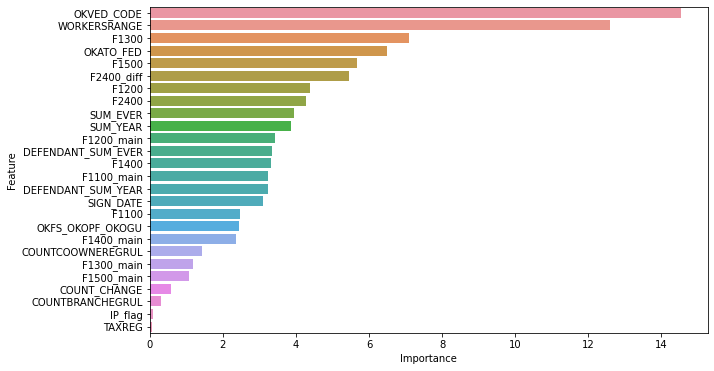

In [112]:
plt.figure(figsize=(10, 6))

df_features = pd.DataFrame(data=cb.feature_importances_, columns=['Importance'])
df_features['Feature'] = X_train_2.columns
df_features = df_features.sort_values(by=['Importance'], ascending=False)

sns.barplot(x=df_features['Importance'], y=df_features['Feature'])

##### Наибольшие веса получили признаки "OKVED_CODE" и "WORKERSRANGE", что выглядит подохрительным, хотя и может быть теоретически объяснимо:
##### "OKVED_CODE" - компании с определённым видом деятельности чаще прочих подвержены рискам, поэтому чаще не исполняют обязательства пере банком;
##### "WORKERSRANGE" - предположение, не очень крупные компании чаще банкротятся.

##### Воспользуемся кросс-валидацией, чтобы убедиться в стабильности модели.

In [113]:
%%time

cvc = cross_val_score(estimator=cb, X=X_train_2, y=y_train_2, cv=5, scoring='f1')

Learning rate set to 0.030127
0:	learn: 0.6770569	total: 50.4ms	remaining: 50.4s
1:	learn: 0.6618319	total: 96ms	remaining: 47.9s
2:	learn: 0.6480068	total: 144ms	remaining: 47.8s
3:	learn: 0.6356902	total: 192ms	remaining: 47.9s
4:	learn: 0.6241029	total: 235ms	remaining: 46.8s
5:	learn: 0.6134470	total: 284ms	remaining: 47.1s
6:	learn: 0.6042937	total: 332ms	remaining: 47s
7:	learn: 0.5948700	total: 378ms	remaining: 46.9s
8:	learn: 0.5857534	total: 426ms	remaining: 46.9s
9:	learn: 0.5781383	total: 469ms	remaining: 46.4s
10:	learn: 0.5704827	total: 512ms	remaining: 46s
11:	learn: 0.5641780	total: 555ms	remaining: 45.7s
12:	learn: 0.5576243	total: 600ms	remaining: 45.6s
13:	learn: 0.5516498	total: 645ms	remaining: 45.4s
14:	learn: 0.5459158	total: 690ms	remaining: 45.3s
15:	learn: 0.5399280	total: 737ms	remaining: 45.3s
16:	learn: 0.5351339	total: 784ms	remaining: 45.3s
17:	learn: 0.5301064	total: 832ms	remaining: 45.4s
18:	learn: 0.5256000	total: 876ms	remaining: 45.3s
19:	learn: 0.52

163:	learn: 0.3708573	total: 7.49s	remaining: 38.2s
164:	learn: 0.3706898	total: 7.53s	remaining: 38.1s
165:	learn: 0.3704551	total: 7.58s	remaining: 38.1s
166:	learn: 0.3701049	total: 7.62s	remaining: 38s
167:	learn: 0.3698324	total: 7.67s	remaining: 38s
168:	learn: 0.3696557	total: 7.71s	remaining: 37.9s
169:	learn: 0.3692990	total: 7.75s	remaining: 37.9s
170:	learn: 0.3690047	total: 7.8s	remaining: 37.8s
171:	learn: 0.3688200	total: 7.84s	remaining: 37.7s
172:	learn: 0.3685400	total: 7.88s	remaining: 37.7s
173:	learn: 0.3679509	total: 7.93s	remaining: 37.7s
174:	learn: 0.3676710	total: 7.98s	remaining: 37.6s
175:	learn: 0.3672951	total: 8.02s	remaining: 37.6s
176:	learn: 0.3670928	total: 8.06s	remaining: 37.5s
177:	learn: 0.3669421	total: 8.11s	remaining: 37.4s
178:	learn: 0.3667066	total: 8.15s	remaining: 37.4s
179:	learn: 0.3664612	total: 8.2s	remaining: 37.4s
180:	learn: 0.3663785	total: 8.24s	remaining: 37.3s
181:	learn: 0.3660721	total: 8.29s	remaining: 37.2s
182:	learn: 0.3658

323:	learn: 0.3366170	total: 14.6s	remaining: 30.5s
324:	learn: 0.3364666	total: 14.7s	remaining: 30.5s
325:	learn: 0.3361355	total: 14.7s	remaining: 30.4s
326:	learn: 0.3359092	total: 14.8s	remaining: 30.4s
327:	learn: 0.3356234	total: 14.8s	remaining: 30.4s
328:	learn: 0.3355762	total: 14.9s	remaining: 30.3s
329:	learn: 0.3354837	total: 14.9s	remaining: 30.3s
330:	learn: 0.3351753	total: 15s	remaining: 30.2s
331:	learn: 0.3351598	total: 15s	remaining: 30.2s
332:	learn: 0.3350204	total: 15s	remaining: 30.1s
333:	learn: 0.3350024	total: 15.1s	remaining: 30.1s
334:	learn: 0.3349914	total: 15.1s	remaining: 30s
335:	learn: 0.3347328	total: 15.2s	remaining: 30s
336:	learn: 0.3342701	total: 15.2s	remaining: 29.9s
337:	learn: 0.3342456	total: 15.3s	remaining: 29.9s
338:	learn: 0.3341629	total: 15.3s	remaining: 29.8s
339:	learn: 0.3340330	total: 15.4s	remaining: 29.8s
340:	learn: 0.3339461	total: 15.4s	remaining: 29.8s
341:	learn: 0.3339003	total: 15.4s	remaining: 29.7s
342:	learn: 0.3338771	

483:	learn: 0.3171372	total: 21.7s	remaining: 23.2s
484:	learn: 0.3171121	total: 21.8s	remaining: 23.1s
485:	learn: 0.3170549	total: 21.8s	remaining: 23.1s
486:	learn: 0.3169380	total: 21.9s	remaining: 23s
487:	learn: 0.3169226	total: 21.9s	remaining: 23s
488:	learn: 0.3167018	total: 21.9s	remaining: 22.9s
489:	learn: 0.3165307	total: 22s	remaining: 22.9s
490:	learn: 0.3165223	total: 22s	remaining: 22.8s
491:	learn: 0.3165021	total: 22.1s	remaining: 22.8s
492:	learn: 0.3164896	total: 22.1s	remaining: 22.8s
493:	learn: 0.3163168	total: 22.2s	remaining: 22.7s
494:	learn: 0.3163054	total: 22.2s	remaining: 22.7s
495:	learn: 0.3162827	total: 22.3s	remaining: 22.6s
496:	learn: 0.3162393	total: 22.3s	remaining: 22.6s
497:	learn: 0.3160013	total: 22.3s	remaining: 22.5s
498:	learn: 0.3158774	total: 22.4s	remaining: 22.5s
499:	learn: 0.3156971	total: 22.4s	remaining: 22.4s
500:	learn: 0.3155532	total: 22.5s	remaining: 22.4s
501:	learn: 0.3155030	total: 22.5s	remaining: 22.3s
502:	learn: 0.315382

645:	learn: 0.3058378	total: 28.9s	remaining: 15.8s
646:	learn: 0.3058349	total: 28.9s	remaining: 15.8s
647:	learn: 0.3058296	total: 28.9s	remaining: 15.7s
648:	learn: 0.3057876	total: 29s	remaining: 15.7s
649:	learn: 0.3057680	total: 29s	remaining: 15.6s
650:	learn: 0.3057524	total: 29.1s	remaining: 15.6s
651:	learn: 0.3057482	total: 29.1s	remaining: 15.5s
652:	learn: 0.3057431	total: 29.2s	remaining: 15.5s
653:	learn: 0.3057349	total: 29.2s	remaining: 15.4s
654:	learn: 0.3057300	total: 29.2s	remaining: 15.4s
655:	learn: 0.3057026	total: 29.3s	remaining: 15.4s
656:	learn: 0.3056932	total: 29.3s	remaining: 15.3s
657:	learn: 0.3056402	total: 29.4s	remaining: 15.3s
658:	learn: 0.3055830	total: 29.4s	remaining: 15.2s
659:	learn: 0.3055512	total: 29.5s	remaining: 15.2s
660:	learn: 0.3054929	total: 29.5s	remaining: 15.1s
661:	learn: 0.3054595	total: 29.6s	remaining: 15.1s
662:	learn: 0.3053565	total: 29.6s	remaining: 15s
663:	learn: 0.3053474	total: 29.6s	remaining: 15s
664:	learn: 0.305312

805:	learn: 0.2985373	total: 35.9s	remaining: 8.64s
806:	learn: 0.2985024	total: 35.9s	remaining: 8.6s
807:	learn: 0.2984030	total: 36s	remaining: 8.55s
808:	learn: 0.2983810	total: 36s	remaining: 8.51s
809:	learn: 0.2983808	total: 36.1s	remaining: 8.46s
810:	learn: 0.2983750	total: 36.1s	remaining: 8.42s
811:	learn: 0.2983676	total: 36.2s	remaining: 8.37s
812:	learn: 0.2983667	total: 36.2s	remaining: 8.33s
813:	learn: 0.2983108	total: 36.3s	remaining: 8.28s
814:	learn: 0.2982112	total: 36.3s	remaining: 8.24s
815:	learn: 0.2982108	total: 36.3s	remaining: 8.19s
816:	learn: 0.2982001	total: 36.4s	remaining: 8.15s
817:	learn: 0.2981977	total: 36.4s	remaining: 8.1s
818:	learn: 0.2981963	total: 36.5s	remaining: 8.06s
819:	learn: 0.2981810	total: 36.5s	remaining: 8.01s
820:	learn: 0.2980235	total: 36.5s	remaining: 7.97s
821:	learn: 0.2980053	total: 36.6s	remaining: 7.92s
822:	learn: 0.2980032	total: 36.6s	remaining: 7.88s
823:	learn: 0.2980014	total: 36.7s	remaining: 7.83s
824:	learn: 0.2979

966:	learn: 0.2943572	total: 42.9s	remaining: 1.47s
967:	learn: 0.2943557	total: 43s	remaining: 1.42s
968:	learn: 0.2943552	total: 43s	remaining: 1.38s
969:	learn: 0.2943144	total: 43.1s	remaining: 1.33s
970:	learn: 0.2942404	total: 43.1s	remaining: 1.29s
971:	learn: 0.2942309	total: 43.2s	remaining: 1.24s
972:	learn: 0.2942246	total: 43.2s	remaining: 1.2s
973:	learn: 0.2942179	total: 43.3s	remaining: 1.15s
974:	learn: 0.2942142	total: 43.3s	remaining: 1.11s
975:	learn: 0.2942078	total: 43.3s	remaining: 1.06s
976:	learn: 0.2941984	total: 43.4s	remaining: 1.02s
977:	learn: 0.2941914	total: 43.4s	remaining: 977ms
978:	learn: 0.2941855	total: 43.5s	remaining: 933ms
979:	learn: 0.2941758	total: 43.5s	remaining: 888ms
980:	learn: 0.2941721	total: 43.6s	remaining: 844ms
981:	learn: 0.2941677	total: 43.6s	remaining: 799ms
982:	learn: 0.2940639	total: 43.7s	remaining: 755ms
983:	learn: 0.2940610	total: 43.7s	remaining: 710ms
984:	learn: 0.2938766	total: 43.7s	remaining: 666ms
985:	learn: 0.293

130:	learn: 0.3826871	total: 5.94s	remaining: 39.4s
131:	learn: 0.3822822	total: 5.99s	remaining: 39.4s
132:	learn: 0.3821071	total: 6.04s	remaining: 39.4s
133:	learn: 0.3812642	total: 6.08s	remaining: 39.3s
134:	learn: 0.3810477	total: 6.13s	remaining: 39.3s
135:	learn: 0.3806928	total: 6.17s	remaining: 39.2s
136:	learn: 0.3801863	total: 6.22s	remaining: 39.2s
137:	learn: 0.3799452	total: 6.27s	remaining: 39.1s
138:	learn: 0.3794340	total: 6.31s	remaining: 39.1s
139:	learn: 0.3791561	total: 6.36s	remaining: 39s
140:	learn: 0.3788744	total: 6.4s	remaining: 39s
141:	learn: 0.3785277	total: 6.45s	remaining: 39s
142:	learn: 0.3784506	total: 6.49s	remaining: 38.9s
143:	learn: 0.3779504	total: 6.54s	remaining: 38.9s
144:	learn: 0.3776496	total: 6.58s	remaining: 38.8s
145:	learn: 0.3773338	total: 6.63s	remaining: 38.8s
146:	learn: 0.3770939	total: 6.67s	remaining: 38.7s
147:	learn: 0.3767261	total: 6.72s	remaining: 38.7s
148:	learn: 0.3765874	total: 6.76s	remaining: 38.6s
149:	learn: 0.37633

290:	learn: 0.3420743	total: 13.1s	remaining: 31.9s
291:	learn: 0.3417298	total: 13.1s	remaining: 31.8s
292:	learn: 0.3416106	total: 13.2s	remaining: 31.8s
293:	learn: 0.3413552	total: 13.2s	remaining: 31.7s
294:	learn: 0.3411440	total: 13.3s	remaining: 31.7s
295:	learn: 0.3409786	total: 13.3s	remaining: 31.6s
296:	learn: 0.3408145	total: 13.3s	remaining: 31.6s
297:	learn: 0.3406837	total: 13.4s	remaining: 31.5s
298:	learn: 0.3404060	total: 13.4s	remaining: 31.5s
299:	learn: 0.3402125	total: 13.5s	remaining: 31.5s
300:	learn: 0.3400776	total: 13.5s	remaining: 31.4s
301:	learn: 0.3397419	total: 13.6s	remaining: 31.4s
302:	learn: 0.3397056	total: 13.6s	remaining: 31.3s
303:	learn: 0.3395672	total: 13.7s	remaining: 31.3s
304:	learn: 0.3393989	total: 13.7s	remaining: 31.2s
305:	learn: 0.3391139	total: 13.7s	remaining: 31.2s
306:	learn: 0.3390502	total: 13.8s	remaining: 31.1s
307:	learn: 0.3389448	total: 13.8s	remaining: 31.1s
308:	learn: 0.3388858	total: 13.9s	remaining: 31s
309:	learn: 0.

449:	learn: 0.3199969	total: 20.2s	remaining: 24.7s
450:	learn: 0.3198513	total: 20.3s	remaining: 24.7s
451:	learn: 0.3197325	total: 20.3s	remaining: 24.6s
452:	learn: 0.3195413	total: 20.4s	remaining: 24.6s
453:	learn: 0.3192881	total: 20.4s	remaining: 24.6s
454:	learn: 0.3192585	total: 20.5s	remaining: 24.5s
455:	learn: 0.3191770	total: 20.5s	remaining: 24.5s
456:	learn: 0.3190884	total: 20.6s	remaining: 24.4s
457:	learn: 0.3190278	total: 20.6s	remaining: 24.4s
458:	learn: 0.3189657	total: 20.7s	remaining: 24.3s
459:	learn: 0.3188474	total: 20.7s	remaining: 24.3s
460:	learn: 0.3186207	total: 20.7s	remaining: 24.3s
461:	learn: 0.3185906	total: 20.8s	remaining: 24.2s
462:	learn: 0.3185473	total: 20.8s	remaining: 24.2s
463:	learn: 0.3183200	total: 20.9s	remaining: 24.1s
464:	learn: 0.3182985	total: 20.9s	remaining: 24.1s
465:	learn: 0.3182448	total: 21s	remaining: 24s
466:	learn: 0.3182188	total: 21s	remaining: 24s
467:	learn: 0.3180665	total: 21.1s	remaining: 23.9s
468:	learn: 0.317812

608:	learn: 0.3066164	total: 27.4s	remaining: 17.6s
609:	learn: 0.3065612	total: 27.4s	remaining: 17.5s
610:	learn: 0.3065323	total: 27.4s	remaining: 17.5s
611:	learn: 0.3064141	total: 27.5s	remaining: 17.4s
612:	learn: 0.3064028	total: 27.5s	remaining: 17.4s
613:	learn: 0.3063948	total: 27.6s	remaining: 17.3s
614:	learn: 0.3063735	total: 27.6s	remaining: 17.3s
615:	learn: 0.3063270	total: 27.7s	remaining: 17.3s
616:	learn: 0.3062891	total: 27.7s	remaining: 17.2s
617:	learn: 0.3061513	total: 27.8s	remaining: 17.2s
618:	learn: 0.3060963	total: 27.8s	remaining: 17.1s
619:	learn: 0.3059897	total: 27.9s	remaining: 17.1s
620:	learn: 0.3059220	total: 27.9s	remaining: 17s
621:	learn: 0.3058940	total: 27.9s	remaining: 17s
622:	learn: 0.3058107	total: 28s	remaining: 16.9s
623:	learn: 0.3058027	total: 28s	remaining: 16.9s
624:	learn: 0.3057937	total: 28.1s	remaining: 16.8s
625:	learn: 0.3057748	total: 28.1s	remaining: 16.8s
626:	learn: 0.3057632	total: 28.2s	remaining: 16.8s
627:	learn: 0.305730

770:	learn: 0.2977245	total: 34.7s	remaining: 10.3s
771:	learn: 0.2977096	total: 34.8s	remaining: 10.3s
772:	learn: 0.2975700	total: 34.8s	remaining: 10.2s
773:	learn: 0.2975008	total: 34.9s	remaining: 10.2s
774:	learn: 0.2974479	total: 34.9s	remaining: 10.1s
775:	learn: 0.2973717	total: 35s	remaining: 10.1s
776:	learn: 0.2973642	total: 35s	remaining: 10s
777:	learn: 0.2972564	total: 35.1s	remaining: 10s
778:	learn: 0.2972293	total: 35.1s	remaining: 9.96s
779:	learn: 0.2971339	total: 35.2s	remaining: 9.91s
780:	learn: 0.2971191	total: 35.2s	remaining: 9.87s
781:	learn: 0.2971082	total: 35.2s	remaining: 9.82s
782:	learn: 0.2971017	total: 35.3s	remaining: 9.78s
783:	learn: 0.2970207	total: 35.3s	remaining: 9.73s
784:	learn: 0.2969694	total: 35.4s	remaining: 9.69s
785:	learn: 0.2969419	total: 35.4s	remaining: 9.65s
786:	learn: 0.2969152	total: 35.5s	remaining: 9.6s
787:	learn: 0.2968506	total: 35.5s	remaining: 9.55s
788:	learn: 0.2967656	total: 35.6s	remaining: 9.51s
789:	learn: 0.2967203

933:	learn: 0.2908444	total: 42.2s	remaining: 2.98s
934:	learn: 0.2908315	total: 42.3s	remaining: 2.94s
935:	learn: 0.2908137	total: 42.3s	remaining: 2.89s
936:	learn: 0.2907972	total: 42.3s	remaining: 2.85s
937:	learn: 0.2907906	total: 42.4s	remaining: 2.8s
938:	learn: 0.2906802	total: 42.4s	remaining: 2.76s
939:	learn: 0.2906794	total: 42.5s	remaining: 2.71s
940:	learn: 0.2906770	total: 42.5s	remaining: 2.67s
941:	learn: 0.2905675	total: 42.6s	remaining: 2.62s
942:	learn: 0.2905053	total: 42.6s	remaining: 2.58s
943:	learn: 0.2904919	total: 42.7s	remaining: 2.53s
944:	learn: 0.2904873	total: 42.7s	remaining: 2.48s
945:	learn: 0.2903845	total: 42.8s	remaining: 2.44s
946:	learn: 0.2903635	total: 42.8s	remaining: 2.4s
947:	learn: 0.2901435	total: 42.9s	remaining: 2.35s
948:	learn: 0.2900327	total: 42.9s	remaining: 2.31s
949:	learn: 0.2900213	total: 42.9s	remaining: 2.26s
950:	learn: 0.2900176	total: 43s	remaining: 2.21s
951:	learn: 0.2900117	total: 43s	remaining: 2.17s
952:	learn: 0.2900

94:	learn: 0.3989784	total: 4.39s	remaining: 41.8s
95:	learn: 0.3981190	total: 4.43s	remaining: 41.7s
96:	learn: 0.3975301	total: 4.48s	remaining: 41.7s
97:	learn: 0.3970625	total: 4.52s	remaining: 41.6s
98:	learn: 0.3965886	total: 4.56s	remaining: 41.5s
99:	learn: 0.3960438	total: 4.61s	remaining: 41.5s
100:	learn: 0.3953318	total: 4.66s	remaining: 41.5s
101:	learn: 0.3948865	total: 4.7s	remaining: 41.4s
102:	learn: 0.3945051	total: 4.74s	remaining: 41.3s
103:	learn: 0.3938784	total: 4.79s	remaining: 41.3s
104:	learn: 0.3934374	total: 4.83s	remaining: 41.2s
105:	learn: 0.3928862	total: 4.88s	remaining: 41.1s
106:	learn: 0.3926788	total: 4.92s	remaining: 41s
107:	learn: 0.3922375	total: 4.96s	remaining: 41s
108:	learn: 0.3915550	total: 5.01s	remaining: 40.9s
109:	learn: 0.3908213	total: 5.05s	remaining: 40.9s
110:	learn: 0.3905553	total: 5.1s	remaining: 40.9s
111:	learn: 0.3902132	total: 5.15s	remaining: 40.8s
112:	learn: 0.3898135	total: 5.19s	remaining: 40.8s
113:	learn: 0.3894312	to

254:	learn: 0.3467763	total: 11.6s	remaining: 34s
255:	learn: 0.3465016	total: 11.7s	remaining: 33.9s
256:	learn: 0.3461893	total: 11.7s	remaining: 33.9s
257:	learn: 0.3459976	total: 11.8s	remaining: 33.8s
258:	learn: 0.3455759	total: 11.8s	remaining: 33.8s
259:	learn: 0.3454993	total: 11.9s	remaining: 33.7s
260:	learn: 0.3452468	total: 11.9s	remaining: 33.7s
261:	learn: 0.3450615	total: 11.9s	remaining: 33.6s
262:	learn: 0.3448071	total: 12s	remaining: 33.6s
263:	learn: 0.3445930	total: 12s	remaining: 33.5s
264:	learn: 0.3442570	total: 12.1s	remaining: 33.5s
265:	learn: 0.3440258	total: 12.1s	remaining: 33.4s
266:	learn: 0.3438577	total: 12.2s	remaining: 33.4s
267:	learn: 0.3436810	total: 12.2s	remaining: 33.3s
268:	learn: 0.3434472	total: 12.3s	remaining: 33.3s
269:	learn: 0.3431858	total: 12.3s	remaining: 33.2s
270:	learn: 0.3429859	total: 12.3s	remaining: 33.2s
271:	learn: 0.3428407	total: 12.4s	remaining: 33.2s
272:	learn: 0.3426900	total: 12.4s	remaining: 33.1s
273:	learn: 0.3423

414:	learn: 0.3198236	total: 18.8s	remaining: 26.5s
415:	learn: 0.3196753	total: 18.9s	remaining: 26.5s
416:	learn: 0.3193989	total: 18.9s	remaining: 26.4s
417:	learn: 0.3192088	total: 19s	remaining: 26.4s
418:	learn: 0.3191184	total: 19s	remaining: 26.4s
419:	learn: 0.3189812	total: 19s	remaining: 26.3s
420:	learn: 0.3187767	total: 19.1s	remaining: 26.3s
421:	learn: 0.3187250	total: 19.1s	remaining: 26.2s
422:	learn: 0.3185918	total: 19.2s	remaining: 26.2s
423:	learn: 0.3182642	total: 19.2s	remaining: 26.1s
424:	learn: 0.3181123	total: 19.3s	remaining: 26.1s
425:	learn: 0.3177134	total: 19.3s	remaining: 26s
426:	learn: 0.3175733	total: 19.4s	remaining: 26s
427:	learn: 0.3172715	total: 19.4s	remaining: 25.9s
428:	learn: 0.3171586	total: 19.5s	remaining: 25.9s
429:	learn: 0.3170694	total: 19.5s	remaining: 25.8s
430:	learn: 0.3168777	total: 19.5s	remaining: 25.8s
431:	learn: 0.3167978	total: 19.6s	remaining: 25.8s
432:	learn: 0.3167575	total: 19.6s	remaining: 25.7s
433:	learn: 0.3165758	

575:	learn: 0.3024757	total: 26s	remaining: 19.2s
576:	learn: 0.3023223	total: 26.1s	remaining: 19.1s
577:	learn: 0.3022331	total: 26.1s	remaining: 19.1s
578:	learn: 0.3020915	total: 26.2s	remaining: 19s
579:	learn: 0.3020759	total: 26.2s	remaining: 19s
580:	learn: 0.3019398	total: 26.3s	remaining: 18.9s
581:	learn: 0.3018338	total: 26.3s	remaining: 18.9s
582:	learn: 0.3018043	total: 26.4s	remaining: 18.9s
583:	learn: 0.3017770	total: 26.4s	remaining: 18.8s
584:	learn: 0.3017669	total: 26.5s	remaining: 18.8s
585:	learn: 0.3015309	total: 26.5s	remaining: 18.7s
586:	learn: 0.3015290	total: 26.5s	remaining: 18.7s
587:	learn: 0.3014651	total: 26.6s	remaining: 18.6s
588:	learn: 0.3013923	total: 26.6s	remaining: 18.6s
589:	learn: 0.3013723	total: 26.7s	remaining: 18.5s
590:	learn: 0.3013701	total: 26.7s	remaining: 18.5s
591:	learn: 0.3013402	total: 26.8s	remaining: 18.4s
592:	learn: 0.3013277	total: 26.8s	remaining: 18.4s
593:	learn: 0.3013217	total: 26.8s	remaining: 18.4s
594:	learn: 0.3012

738:	learn: 0.2939093	total: 33.4s	remaining: 11.8s
739:	learn: 0.2938372	total: 33.5s	remaining: 11.8s
740:	learn: 0.2938307	total: 33.5s	remaining: 11.7s
741:	learn: 0.2936877	total: 33.6s	remaining: 11.7s
742:	learn: 0.2936343	total: 33.6s	remaining: 11.6s
743:	learn: 0.2935572	total: 33.6s	remaining: 11.6s
744:	learn: 0.2934408	total: 33.7s	remaining: 11.5s
745:	learn: 0.2933941	total: 33.7s	remaining: 11.5s
746:	learn: 0.2932699	total: 33.8s	remaining: 11.4s
747:	learn: 0.2932261	total: 33.8s	remaining: 11.4s
748:	learn: 0.2932028	total: 33.9s	remaining: 11.4s
749:	learn: 0.2932018	total: 33.9s	remaining: 11.3s
750:	learn: 0.2931622	total: 34s	remaining: 11.3s
751:	learn: 0.2928773	total: 34s	remaining: 11.2s
752:	learn: 0.2928392	total: 34s	remaining: 11.2s
753:	learn: 0.2927783	total: 34.1s	remaining: 11.1s
754:	learn: 0.2925868	total: 34.1s	remaining: 11.1s
755:	learn: 0.2925139	total: 34.2s	remaining: 11s
756:	learn: 0.2924932	total: 34.2s	remaining: 11s
757:	learn: 0.2923906	

898:	learn: 0.2835408	total: 40.7s	remaining: 4.57s
899:	learn: 0.2834403	total: 40.7s	remaining: 4.53s
900:	learn: 0.2834384	total: 40.8s	remaining: 4.48s
901:	learn: 0.2833407	total: 40.8s	remaining: 4.43s
902:	learn: 0.2832929	total: 40.9s	remaining: 4.39s
903:	learn: 0.2832667	total: 40.9s	remaining: 4.34s
904:	learn: 0.2832007	total: 41s	remaining: 4.3s
905:	learn: 0.2831443	total: 41s	remaining: 4.25s
906:	learn: 0.2830947	total: 41.1s	remaining: 4.21s
907:	learn: 0.2830254	total: 41.1s	remaining: 4.16s
908:	learn: 0.2829472	total: 41.1s	remaining: 4.12s
909:	learn: 0.2828998	total: 41.2s	remaining: 4.07s
910:	learn: 0.2827900	total: 41.2s	remaining: 4.03s
911:	learn: 0.2827461	total: 41.3s	remaining: 3.98s
912:	learn: 0.2827281	total: 41.3s	remaining: 3.94s
913:	learn: 0.2826741	total: 41.4s	remaining: 3.89s
914:	learn: 0.2826554	total: 41.4s	remaining: 3.85s
915:	learn: 0.2826489	total: 41.5s	remaining: 3.8s
916:	learn: 0.2826102	total: 41.5s	remaining: 3.76s
917:	learn: 0.2825

59:	learn: 0.4275459	total: 2.77s	remaining: 43.3s
60:	learn: 0.4259642	total: 2.81s	remaining: 43.3s
61:	learn: 0.4243628	total: 2.85s	remaining: 43.2s
62:	learn: 0.4235189	total: 2.9s	remaining: 43.1s
63:	learn: 0.4226711	total: 2.94s	remaining: 43.1s
64:	learn: 0.4217184	total: 2.99s	remaining: 43s
65:	learn: 0.4209033	total: 3.03s	remaining: 42.9s
66:	learn: 0.4200165	total: 3.08s	remaining: 42.9s
67:	learn: 0.4191541	total: 3.12s	remaining: 42.8s
68:	learn: 0.4180401	total: 3.17s	remaining: 42.8s
69:	learn: 0.4173592	total: 3.21s	remaining: 42.7s
70:	learn: 0.4165400	total: 3.26s	remaining: 42.7s
71:	learn: 0.4152042	total: 3.31s	remaining: 42.6s
72:	learn: 0.4145480	total: 3.35s	remaining: 42.5s
73:	learn: 0.4133374	total: 3.4s	remaining: 42.5s
74:	learn: 0.4129599	total: 3.44s	remaining: 42.5s
75:	learn: 0.4120907	total: 3.49s	remaining: 42.4s
76:	learn: 0.4113047	total: 3.53s	remaining: 42.3s
77:	learn: 0.4103831	total: 3.58s	remaining: 42.3s
78:	learn: 0.4096045	total: 3.62s	r

223:	learn: 0.3560789	total: 10.1s	remaining: 35.1s
224:	learn: 0.3559323	total: 10.2s	remaining: 35.1s
225:	learn: 0.3558723	total: 10.2s	remaining: 35s
226:	learn: 0.3555080	total: 10.3s	remaining: 35s
227:	learn: 0.3553926	total: 10.3s	remaining: 34.9s
228:	learn: 0.3551170	total: 10.4s	remaining: 34.9s
229:	learn: 0.3549406	total: 10.4s	remaining: 34.8s
230:	learn: 0.3546820	total: 10.4s	remaining: 34.8s
231:	learn: 0.3545005	total: 10.5s	remaining: 34.7s
232:	learn: 0.3542408	total: 10.5s	remaining: 34.7s
233:	learn: 0.3541280	total: 10.6s	remaining: 34.6s
234:	learn: 0.3536787	total: 10.6s	remaining: 34.6s
235:	learn: 0.3532522	total: 10.7s	remaining: 34.6s
236:	learn: 0.3528133	total: 10.7s	remaining: 34.5s
237:	learn: 0.3525224	total: 10.8s	remaining: 34.5s
238:	learn: 0.3522517	total: 10.8s	remaining: 34.4s
239:	learn: 0.3521967	total: 10.9s	remaining: 34.4s
240:	learn: 0.3521842	total: 10.9s	remaining: 34.4s
241:	learn: 0.3520436	total: 11s	remaining: 34.4s
242:	learn: 0.3518

383:	learn: 0.3317281	total: 17.3s	remaining: 27.8s
384:	learn: 0.3315007	total: 17.4s	remaining: 27.7s
385:	learn: 0.3314946	total: 17.4s	remaining: 27.7s
386:	learn: 0.3314861	total: 17.4s	remaining: 27.6s
387:	learn: 0.3312862	total: 17.5s	remaining: 27.6s
388:	learn: 0.3312718	total: 17.5s	remaining: 27.5s
389:	learn: 0.3311157	total: 17.6s	remaining: 27.5s
390:	learn: 0.3309885	total: 17.6s	remaining: 27.5s
391:	learn: 0.3306749	total: 17.7s	remaining: 27.4s
392:	learn: 0.3306592	total: 17.7s	remaining: 27.4s
393:	learn: 0.3305091	total: 17.8s	remaining: 27.3s
394:	learn: 0.3299624	total: 17.8s	remaining: 27.3s
395:	learn: 0.3299166	total: 17.8s	remaining: 27.2s
396:	learn: 0.3299153	total: 17.9s	remaining: 27.1s
397:	learn: 0.3298721	total: 17.9s	remaining: 27.1s
398:	learn: 0.3298620	total: 18s	remaining: 27.1s
399:	learn: 0.3298457	total: 18s	remaining: 27s
400:	learn: 0.3295281	total: 18.1s	remaining: 27s
401:	learn: 0.3295002	total: 18.1s	remaining: 26.9s
402:	learn: 0.329169

546:	learn: 0.3164747	total: 24.4s	remaining: 20.2s
547:	learn: 0.3164696	total: 24.5s	remaining: 20.2s
548:	learn: 0.3164680	total: 24.5s	remaining: 20.1s
549:	learn: 0.3164664	total: 24.6s	remaining: 20.1s
550:	learn: 0.3162586	total: 24.6s	remaining: 20s
551:	learn: 0.3162398	total: 24.6s	remaining: 20s
552:	learn: 0.3160617	total: 24.7s	remaining: 20s
553:	learn: 0.3160602	total: 24.7s	remaining: 19.9s
554:	learn: 0.3159002	total: 24.8s	remaining: 19.9s
555:	learn: 0.3158807	total: 24.8s	remaining: 19.8s
556:	learn: 0.3158723	total: 24.9s	remaining: 19.8s
557:	learn: 0.3158721	total: 24.9s	remaining: 19.7s
558:	learn: 0.3157349	total: 24.9s	remaining: 19.7s
559:	learn: 0.3156801	total: 25s	remaining: 19.6s
560:	learn: 0.3156711	total: 25s	remaining: 19.6s
561:	learn: 0.3155004	total: 25.1s	remaining: 19.5s
562:	learn: 0.3154583	total: 25.1s	remaining: 19.5s
563:	learn: 0.3153941	total: 25.1s	remaining: 19.4s
564:	learn: 0.3153923	total: 25.2s	remaining: 19.4s
565:	learn: 0.3153907	

706:	learn: 0.3037842	total: 31.5s	remaining: 13s
707:	learn: 0.3037191	total: 31.5s	remaining: 13s
708:	learn: 0.3036722	total: 31.6s	remaining: 13s
709:	learn: 0.3036648	total: 31.6s	remaining: 12.9s
710:	learn: 0.3035494	total: 31.7s	remaining: 12.9s
711:	learn: 0.3035279	total: 31.7s	remaining: 12.8s
712:	learn: 0.3034276	total: 31.7s	remaining: 12.8s
713:	learn: 0.3034202	total: 31.8s	remaining: 12.7s
714:	learn: 0.3034194	total: 31.8s	remaining: 12.7s
715:	learn: 0.3033458	total: 31.9s	remaining: 12.6s
716:	learn: 0.3033265	total: 31.9s	remaining: 12.6s
717:	learn: 0.3031941	total: 32s	remaining: 12.6s
718:	learn: 0.3031000	total: 32s	remaining: 12.5s
719:	learn: 0.3030981	total: 32.1s	remaining: 12.5s
720:	learn: 0.3030101	total: 32.1s	remaining: 12.4s
721:	learn: 0.3028621	total: 32.1s	remaining: 12.4s
722:	learn: 0.3028347	total: 32.2s	remaining: 12.3s
723:	learn: 0.3028334	total: 32.2s	remaining: 12.3s
724:	learn: 0.3028326	total: 32.3s	remaining: 12.2s
725:	learn: 0.3027520	

866:	learn: 0.2966890	total: 38.5s	remaining: 5.9s
867:	learn: 0.2966883	total: 38.5s	remaining: 5.86s
868:	learn: 0.2966865	total: 38.6s	remaining: 5.81s
869:	learn: 0.2966854	total: 38.6s	remaining: 5.77s
870:	learn: 0.2965705	total: 38.6s	remaining: 5.72s
871:	learn: 0.2965597	total: 38.7s	remaining: 5.68s
872:	learn: 0.2965111	total: 38.7s	remaining: 5.63s
873:	learn: 0.2965103	total: 38.8s	remaining: 5.59s
874:	learn: 0.2964950	total: 38.8s	remaining: 5.54s
875:	learn: 0.2964944	total: 38.9s	remaining: 5.5s
876:	learn: 0.2964932	total: 38.9s	remaining: 5.45s
877:	learn: 0.2964627	total: 38.9s	remaining: 5.41s
878:	learn: 0.2964535	total: 39s	remaining: 5.37s
879:	learn: 0.2964066	total: 39s	remaining: 5.32s
880:	learn: 0.2964045	total: 39.1s	remaining: 5.28s
881:	learn: 0.2962979	total: 39.1s	remaining: 5.23s
882:	learn: 0.2962835	total: 39.1s	remaining: 5.19s
883:	learn: 0.2962828	total: 39.2s	remaining: 5.14s
884:	learn: 0.2962823	total: 39.2s	remaining: 5.1s
885:	learn: 0.29627

29:	learn: 0.4876686	total: 1.41s	remaining: 45.5s
30:	learn: 0.4851462	total: 1.45s	remaining: 45.4s
31:	learn: 0.4810758	total: 1.5s	remaining: 45.3s
32:	learn: 0.4785572	total: 1.54s	remaining: 45.3s
33:	learn: 0.4764289	total: 1.59s	remaining: 45.1s
34:	learn: 0.4728115	total: 1.64s	remaining: 45.2s
35:	learn: 0.4707747	total: 1.69s	remaining: 45.2s
36:	learn: 0.4678866	total: 1.73s	remaining: 45.1s
37:	learn: 0.4657113	total: 1.78s	remaining: 45s
38:	learn: 0.4625599	total: 1.82s	remaining: 45s
39:	learn: 0.4605462	total: 1.87s	remaining: 44.9s
40:	learn: 0.4590661	total: 1.92s	remaining: 44.8s
41:	learn: 0.4570535	total: 1.96s	remaining: 44.7s
42:	learn: 0.4550906	total: 2.01s	remaining: 44.7s
43:	learn: 0.4531223	total: 2.05s	remaining: 44.6s
44:	learn: 0.4516092	total: 2.1s	remaining: 44.6s
45:	learn: 0.4492752	total: 2.14s	remaining: 44.5s
46:	learn: 0.4468427	total: 2.19s	remaining: 44.4s
47:	learn: 0.4458521	total: 2.23s	remaining: 44.3s
48:	learn: 0.4436577	total: 2.28s	rem

193:	learn: 0.3661768	total: 8.86s	remaining: 36.8s
194:	learn: 0.3657319	total: 8.9s	remaining: 36.7s
195:	learn: 0.3654251	total: 8.94s	remaining: 36.7s
196:	learn: 0.3653285	total: 8.99s	remaining: 36.6s
197:	learn: 0.3647105	total: 9.04s	remaining: 36.6s
198:	learn: 0.3644572	total: 9.08s	remaining: 36.6s
199:	learn: 0.3640151	total: 9.13s	remaining: 36.5s
200:	learn: 0.3638953	total: 9.17s	remaining: 36.5s
201:	learn: 0.3634795	total: 9.22s	remaining: 36.4s
202:	learn: 0.3633244	total: 9.26s	remaining: 36.4s
203:	learn: 0.3632127	total: 9.31s	remaining: 36.3s
204:	learn: 0.3630115	total: 9.35s	remaining: 36.3s
205:	learn: 0.3629487	total: 9.39s	remaining: 36.2s
206:	learn: 0.3626946	total: 9.44s	remaining: 36.2s
207:	learn: 0.3626932	total: 9.46s	remaining: 36s
208:	learn: 0.3625803	total: 9.5s	remaining: 36s
209:	learn: 0.3622539	total: 9.55s	remaining: 35.9s
210:	learn: 0.3621415	total: 9.6s	remaining: 35.9s
211:	learn: 0.3617302	total: 9.65s	remaining: 35.9s
212:	learn: 0.36146

352:	learn: 0.3375574	total: 16.1s	remaining: 29.5s
353:	learn: 0.3374280	total: 16.1s	remaining: 29.4s
354:	learn: 0.3374036	total: 16.2s	remaining: 29.4s
355:	learn: 0.3371644	total: 16.2s	remaining: 29.3s
356:	learn: 0.3368899	total: 16.3s	remaining: 29.3s
357:	learn: 0.3368725	total: 16.3s	remaining: 29.2s
358:	learn: 0.3365740	total: 16.3s	remaining: 29.2s
359:	learn: 0.3363515	total: 16.4s	remaining: 29.1s
360:	learn: 0.3362574	total: 16.4s	remaining: 29.1s
361:	learn: 0.3359323	total: 16.5s	remaining: 29s
362:	learn: 0.3357062	total: 16.5s	remaining: 29s
363:	learn: 0.3356670	total: 16.6s	remaining: 29s
364:	learn: 0.3355506	total: 16.6s	remaining: 28.9s
365:	learn: 0.3352375	total: 16.7s	remaining: 28.9s
366:	learn: 0.3350292	total: 16.7s	remaining: 28.8s
367:	learn: 0.3349160	total: 16.7s	remaining: 28.8s
368:	learn: 0.3347326	total: 16.8s	remaining: 28.7s
369:	learn: 0.3345780	total: 16.8s	remaining: 28.7s
370:	learn: 0.3344131	total: 16.9s	remaining: 28.6s
371:	learn: 0.3341

515:	learn: 0.3180221	total: 23.4s	remaining: 22s
516:	learn: 0.3179407	total: 23.5s	remaining: 21.9s
517:	learn: 0.3177787	total: 23.5s	remaining: 21.9s
518:	learn: 0.3175531	total: 23.6s	remaining: 21.8s
519:	learn: 0.3173457	total: 23.6s	remaining: 21.8s
520:	learn: 0.3172973	total: 23.6s	remaining: 21.7s
521:	learn: 0.3172474	total: 23.7s	remaining: 21.7s
522:	learn: 0.3170132	total: 23.7s	remaining: 21.6s
523:	learn: 0.3169415	total: 23.8s	remaining: 21.6s
524:	learn: 0.3168424	total: 23.8s	remaining: 21.6s
525:	learn: 0.3165354	total: 23.9s	remaining: 21.5s
526:	learn: 0.3164332	total: 23.9s	remaining: 21.5s
527:	learn: 0.3162868	total: 24s	remaining: 21.4s
528:	learn: 0.3162816	total: 24s	remaining: 21.4s
529:	learn: 0.3162106	total: 24.1s	remaining: 21.3s
530:	learn: 0.3160711	total: 24.1s	remaining: 21.3s
531:	learn: 0.3159712	total: 24.2s	remaining: 21.3s
532:	learn: 0.3159646	total: 24.2s	remaining: 21.2s
533:	learn: 0.3159623	total: 24.3s	remaining: 21.2s
534:	learn: 0.3158

674:	learn: 0.3061283	total: 30.7s	remaining: 14.8s
675:	learn: 0.3060220	total: 30.7s	remaining: 14.7s
676:	learn: 0.3060124	total: 30.8s	remaining: 14.7s
677:	learn: 0.3059923	total: 30.8s	remaining: 14.6s
678:	learn: 0.3058773	total: 30.9s	remaining: 14.6s
679:	learn: 0.3058648	total: 30.9s	remaining: 14.5s
680:	learn: 0.3058624	total: 30.9s	remaining: 14.5s
681:	learn: 0.3058347	total: 31s	remaining: 14.5s
682:	learn: 0.3057337	total: 31s	remaining: 14.4s
683:	learn: 0.3057294	total: 31.1s	remaining: 14.4s
684:	learn: 0.3057043	total: 31.1s	remaining: 14.3s
685:	learn: 0.3055330	total: 31.2s	remaining: 14.3s
686:	learn: 0.3055317	total: 31.2s	remaining: 14.2s
687:	learn: 0.3054889	total: 31.3s	remaining: 14.2s
688:	learn: 0.3054868	total: 31.3s	remaining: 14.1s
689:	learn: 0.3053947	total: 31.3s	remaining: 14.1s
690:	learn: 0.3053938	total: 31.4s	remaining: 14s
691:	learn: 0.3052943	total: 31.4s	remaining: 14s
692:	learn: 0.3052256	total: 31.5s	remaining: 13.9s
693:	learn: 0.305215

834:	learn: 0.2957971	total: 37.9s	remaining: 7.49s
835:	learn: 0.2957967	total: 38s	remaining: 7.45s
836:	learn: 0.2955649	total: 38s	remaining: 7.4s
837:	learn: 0.2955088	total: 38.1s	remaining: 7.36s
838:	learn: 0.2954680	total: 38.1s	remaining: 7.31s
839:	learn: 0.2954649	total: 38.1s	remaining: 7.26s
840:	learn: 0.2953555	total: 38.2s	remaining: 7.22s
841:	learn: 0.2953210	total: 38.2s	remaining: 7.17s
842:	learn: 0.2950880	total: 38.3s	remaining: 7.13s
843:	learn: 0.2950093	total: 38.3s	remaining: 7.08s
844:	learn: 0.2949928	total: 38.4s	remaining: 7.04s
845:	learn: 0.2948438	total: 38.4s	remaining: 6.99s
846:	learn: 0.2946818	total: 38.5s	remaining: 6.95s
847:	learn: 0.2946643	total: 38.5s	remaining: 6.9s
848:	learn: 0.2946399	total: 38.6s	remaining: 6.86s
849:	learn: 0.2945971	total: 38.6s	remaining: 6.81s
850:	learn: 0.2944224	total: 38.6s	remaining: 6.76s
851:	learn: 0.2943991	total: 38.7s	remaining: 6.72s
852:	learn: 0.2943183	total: 38.7s	remaining: 6.67s
853:	learn: 0.2943

997:	learn: 0.2861732	total: 45.4s	remaining: 91.1ms
998:	learn: 0.2861693	total: 45.5s	remaining: 45.5ms
999:	learn: 0.2861507	total: 45.5s	remaining: 0us
Wall time: 3min 47s


In [114]:
cvc

array([0.77339181, 0.79569892, 0.78535535, 0.77761414, 0.79076694])

In [115]:
cvc.mean()

0.7845654327784493

##### Кросс-валидация подтвердила, модель демонстрирует стабильно высокие метрики f1 на всех разбиениеях.

### Эксперимент. Попробуем отсечь менее важные признаки.

##### Для этого создадим бесполезный признак-шум и сравним его важность с остальными признаками с точки зрения модели.

In [116]:
X_train_2['Noise'] = np.round(np.random.normal(size=X_train_2.shape[0]) * 1000)
X_train_2.head()

,SIGN_DATE,IP_flag,F1100,F1200,F1300,F1400,F1500,F2400,OKATO_FED,WORKERSRANGE,COUNTCOOWNEREGRUL,COUNTBRANCHEGRUL,OKVED_CODE,DEFENDANT_SUM_YEAR,DEFENDANT_SUM_EVER,F1100_main,F1200_main,F1300_main,F1400_main,F1500_main,F2400_diff,OKFS_OKOPF_OKOGU,TAXREG,SUM_YEAR,SUM_EVER,COUNT_CHANGE,Noise
6333,299,0,697000,12703000,3129500,3129500,7140000,6211000,30,0 .. 5,1,0,46,0,0,F1150,F1230,0,0,F1520,6211000,1,1,0,0,0,795.00
8936,234,0,0,1512000,186500,186500,1139000,363000,30,0 .. 5,3,0,63,0,0,0,F1230,0,0,F1520,363000,1,1,2500934,14793557,0,-715.00
4414,348,0,0,0,0,0,0,0,40,0 .. 5,1,0,47,21900,21900,0,0,0,0,0,0,1,1,3425835,3425835,0,820.00
13175,112,0,66206000,378548992,109382000,22170000,313204000,-83196000,30,51 .. 100,3,1,46,0,0,F1110,F1230,F1350,F1410,F1520,-26782000,1,1,9501298,78457256,0,-168.00
7069,286,0,1654553984,463132000,1725609984,99496000,212180000,101174000,31,501 .. 1000,1,0,35,0,0,F1150,F1230,F1310,F1420,F1520,-111082000,2,1,0,0,0,"1,712.00"


In [117]:
X_train_2['Noise'].describe()

count               9,652.00
mean                  -10.31
std                   989.19
min                -3,426.00
25%                  -682.25
50%                    -3.00
75%                   657.00
max                 3,922.00
Name: Noise, dtype: float64

In [118]:
%%time

cb = catboost.CatBoostClassifier(random_state=settings_random_state,
                                cat_features=cat_features,
                                task_type='GPU')

cb.fit(X_train_2, y_train_2)

Learning rate set to 0.029759
0:	learn: 0.6786655	total: 50.8ms	remaining: 50.7s
1:	learn: 0.6640983	total: 96.2ms	remaining: 48s
2:	learn: 0.6519318	total: 144ms	remaining: 47.7s
3:	learn: 0.6402024	total: 193ms	remaining: 48s
4:	learn: 0.6280524	total: 244ms	remaining: 48.6s
5:	learn: 0.6175806	total: 294ms	remaining: 48.8s
6:	learn: 0.6073880	total: 347ms	remaining: 49.2s
7:	learn: 0.5982372	total: 395ms	remaining: 49s
8:	learn: 0.5902679	total: 447ms	remaining: 49.2s
9:	learn: 0.5820623	total: 499ms	remaining: 49.4s
10:	learn: 0.5749146	total: 546ms	remaining: 49.1s
11:	learn: 0.5681910	total: 593ms	remaining: 48.8s
12:	learn: 0.5606228	total: 642ms	remaining: 48.7s
13:	learn: 0.5542711	total: 690ms	remaining: 48.6s
14:	learn: 0.5480684	total: 735ms	remaining: 48.3s
15:	learn: 0.5422931	total: 788ms	remaining: 48.5s
16:	learn: 0.5366573	total: 836ms	remaining: 48.3s
17:	learn: 0.5316250	total: 881ms	remaining: 48.1s
18:	learn: 0.5265980	total: 927ms	remaining: 47.9s
19:	learn: 0.52

165:	learn: 0.3695251	total: 7.78s	remaining: 39.1s
166:	learn: 0.3691638	total: 7.83s	remaining: 39.1s
167:	learn: 0.3689706	total: 7.88s	remaining: 39s
168:	learn: 0.3687220	total: 7.93s	remaining: 39s
169:	learn: 0.3683218	total: 7.98s	remaining: 39s
170:	learn: 0.3681324	total: 8.03s	remaining: 38.9s
171:	learn: 0.3678423	total: 8.08s	remaining: 38.9s
172:	learn: 0.3673752	total: 8.12s	remaining: 38.8s
173:	learn: 0.3670048	total: 8.17s	remaining: 38.8s
174:	learn: 0.3668984	total: 8.21s	remaining: 38.7s
175:	learn: 0.3665981	total: 8.26s	remaining: 38.7s
176:	learn: 0.3663668	total: 8.3s	remaining: 38.6s
177:	learn: 0.3660641	total: 8.35s	remaining: 38.5s
178:	learn: 0.3658867	total: 8.39s	remaining: 38.5s
179:	learn: 0.3655795	total: 8.44s	remaining: 38.4s
180:	learn: 0.3650436	total: 8.48s	remaining: 38.4s
181:	learn: 0.3649145	total: 8.53s	remaining: 38.3s
182:	learn: 0.3645530	total: 8.58s	remaining: 38.3s
183:	learn: 0.3642173	total: 8.63s	remaining: 38.3s
184:	learn: 0.36397

324:	learn: 0.3367031	total: 15s	remaining: 31.2s
325:	learn: 0.3366229	total: 15.1s	remaining: 31.1s
326:	learn: 0.3364430	total: 15.1s	remaining: 31.1s
327:	learn: 0.3362264	total: 15.2s	remaining: 31s
328:	learn: 0.3360980	total: 15.2s	remaining: 31s
329:	learn: 0.3359244	total: 15.2s	remaining: 30.9s
330:	learn: 0.3357671	total: 15.3s	remaining: 30.9s
331:	learn: 0.3355781	total: 15.3s	remaining: 30.8s
332:	learn: 0.3353114	total: 15.4s	remaining: 30.8s
333:	learn: 0.3352013	total: 15.4s	remaining: 30.8s
334:	learn: 0.3349155	total: 15.5s	remaining: 30.7s
335:	learn: 0.3347770	total: 15.5s	remaining: 30.7s
336:	learn: 0.3344627	total: 15.6s	remaining: 30.6s
337:	learn: 0.3342921	total: 15.6s	remaining: 30.6s
338:	learn: 0.3341319	total: 15.6s	remaining: 30.5s
339:	learn: 0.3338279	total: 15.7s	remaining: 30.5s
340:	learn: 0.3338206	total: 15.7s	remaining: 30.4s
341:	learn: 0.3337183	total: 15.8s	remaining: 30.4s
342:	learn: 0.3336363	total: 15.8s	remaining: 30.3s
343:	learn: 0.3335

484:	learn: 0.3170817	total: 22.3s	remaining: 23.7s
485:	learn: 0.3169890	total: 22.4s	remaining: 23.6s
486:	learn: 0.3168917	total: 22.4s	remaining: 23.6s
487:	learn: 0.3167116	total: 22.4s	remaining: 23.6s
488:	learn: 0.3164543	total: 22.5s	remaining: 23.5s
489:	learn: 0.3164464	total: 22.5s	remaining: 23.5s
490:	learn: 0.3163870	total: 22.6s	remaining: 23.4s
491:	learn: 0.3162345	total: 22.6s	remaining: 23.4s
492:	learn: 0.3161347	total: 22.7s	remaining: 23.3s
493:	learn: 0.3161151	total: 22.7s	remaining: 23.3s
494:	learn: 0.3158466	total: 22.8s	remaining: 23.2s
495:	learn: 0.3156479	total: 22.8s	remaining: 23.2s
496:	learn: 0.3156375	total: 22.9s	remaining: 23.1s
497:	learn: 0.3156310	total: 22.9s	remaining: 23.1s
498:	learn: 0.3155090	total: 22.9s	remaining: 23s
499:	learn: 0.3154941	total: 23s	remaining: 23s
500:	learn: 0.3154855	total: 23s	remaining: 22.9s
501:	learn: 0.3152810	total: 23.1s	remaining: 22.9s
502:	learn: 0.3151117	total: 23.1s	remaining: 22.8s
503:	learn: 0.315067

644:	learn: 0.3037580	total: 29.5s	remaining: 16.2s
645:	learn: 0.3037307	total: 29.6s	remaining: 16.2s
646:	learn: 0.3036963	total: 29.6s	remaining: 16.1s
647:	learn: 0.3036602	total: 29.6s	remaining: 16.1s
648:	learn: 0.3036537	total: 29.7s	remaining: 16.1s
649:	learn: 0.3036522	total: 29.7s	remaining: 16s
650:	learn: 0.3036187	total: 29.8s	remaining: 16s
651:	learn: 0.3034116	total: 29.8s	remaining: 15.9s
652:	learn: 0.3033718	total: 29.9s	remaining: 15.9s
653:	learn: 0.3033244	total: 29.9s	remaining: 15.8s
654:	learn: 0.3032867	total: 30s	remaining: 15.8s
655:	learn: 0.3031924	total: 30s	remaining: 15.7s
656:	learn: 0.3031196	total: 30s	remaining: 15.7s
657:	learn: 0.3031066	total: 30.1s	remaining: 15.6s
658:	learn: 0.3029972	total: 30.1s	remaining: 15.6s
659:	learn: 0.3029930	total: 30.2s	remaining: 15.5s
660:	learn: 0.3029051	total: 30.2s	remaining: 15.5s
661:	learn: 0.3028369	total: 30.3s	remaining: 15.5s
662:	learn: 0.3028341	total: 30.3s	remaining: 15.4s
663:	learn: 0.3028127	

806:	learn: 0.2962590	total: 36.9s	remaining: 8.82s
807:	learn: 0.2962310	total: 36.9s	remaining: 8.77s
808:	learn: 0.2962290	total: 37s	remaining: 8.73s
809:	learn: 0.2962262	total: 37s	remaining: 8.68s
810:	learn: 0.2962253	total: 37s	remaining: 8.63s
811:	learn: 0.2962243	total: 37.1s	remaining: 8.59s
812:	learn: 0.2962210	total: 37.1s	remaining: 8.54s
813:	learn: 0.2961802	total: 37.2s	remaining: 8.49s
814:	learn: 0.2961743	total: 37.2s	remaining: 8.45s
815:	learn: 0.2961230	total: 37.3s	remaining: 8.4s
816:	learn: 0.2961210	total: 37.3s	remaining: 8.36s
817:	learn: 0.2960505	total: 37.4s	remaining: 8.31s
818:	learn: 0.2960488	total: 37.4s	remaining: 8.27s
819:	learn: 0.2960482	total: 37.4s	remaining: 8.22s
820:	learn: 0.2960239	total: 37.5s	remaining: 8.17s
821:	learn: 0.2960208	total: 37.5s	remaining: 8.13s
822:	learn: 0.2960018	total: 37.6s	remaining: 8.08s
823:	learn: 0.2959970	total: 37.6s	remaining: 8.03s
824:	learn: 0.2959843	total: 37.7s	remaining: 7.99s
825:	learn: 0.29598

965:	learn: 0.2920839	total: 43.9s	remaining: 1.55s
966:	learn: 0.2920405	total: 44s	remaining: 1.5s
967:	learn: 0.2920391	total: 44s	remaining: 1.46s
968:	learn: 0.2920355	total: 44.1s	remaining: 1.41s
969:	learn: 0.2918877	total: 44.1s	remaining: 1.36s
970:	learn: 0.2918857	total: 44.2s	remaining: 1.32s
971:	learn: 0.2918725	total: 44.2s	remaining: 1.27s
972:	learn: 0.2918567	total: 44.2s	remaining: 1.23s
973:	learn: 0.2918528	total: 44.3s	remaining: 1.18s
974:	learn: 0.2918524	total: 44.3s	remaining: 1.14s
975:	learn: 0.2918409	total: 44.4s	remaining: 1.09s
976:	learn: 0.2918401	total: 44.4s	remaining: 1.04s
977:	learn: 0.2918387	total: 44.5s	remaining: 1s
978:	learn: 0.2917766	total: 44.5s	remaining: 955ms
979:	learn: 0.2917745	total: 44.6s	remaining: 910ms
980:	learn: 0.2917313	total: 44.6s	remaining: 864ms
981:	learn: 0.2917139	total: 44.7s	remaining: 819ms
982:	learn: 0.2916183	total: 44.7s	remaining: 773ms
983:	learn: 0.2916179	total: 44.8s	remaining: 728ms
984:	learn: 0.291599

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

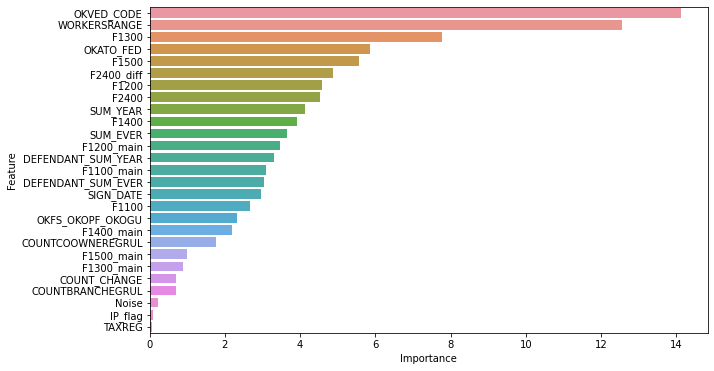

In [119]:
plt.figure(figsize=(10, 6))

df_features = pd.DataFrame(data=cb.feature_importances_, columns=['Importance'])
df_features['Feature'] = X_train_2.columns
df_features = df_features.sort_values(by=['Importance'], ascending=False)

sns.barplot(x=df_features['Importance'], y=df_features['Feature'])

##### Как можно наблюдать на графике, важность шести признаков "COUNT_CHANGE", "COUNTBRANCHEGRUL", "IP_flag", "TAXREG", "F1300_main", "F1500_main" оказалась менее и около безполезного признака-шума "Noise".

##### Попробуем исключить неважные признаки и оценить качество прогнозирования.

In [120]:
X_train_3 = X_train_2.drop(columns=['TAXREG', 'IP_flag', 'Noise', 'COUNTBRANCHEGRUL', 'COUNT_CHANGE', 'F1500_main',
                                    'F1300_main']).copy()
X_valid_3 = X_valid_2.drop(columns=['TAXREG', 'IP_flag', 'COUNTBRANCHEGRUL', 'COUNT_CHANGE', 'F1500_main', 'F1300_main']).copy()

X_train_3.shape, X_valid_3.shape

((9652, 20), (2413, 20))

In [121]:
X_train_3.head()

,SIGN_DATE,F1100,F1200,F1300,F1400,F1500,F2400,OKATO_FED,WORKERSRANGE,COUNTCOOWNEREGRUL,OKVED_CODE,DEFENDANT_SUM_YEAR,DEFENDANT_SUM_EVER,F1100_main,F1200_main,F1400_main,F2400_diff,OKFS_OKOPF_OKOGU,SUM_YEAR,SUM_EVER
6333,299,697000,12703000,3129500,3129500,7140000,6211000,30,0 .. 5,1,46,0,0,F1150,F1230,0,6211000,1,0,0
8936,234,0,1512000,186500,186500,1139000,363000,30,0 .. 5,3,63,0,0,0,F1230,0,363000,1,2500934,14793557
4414,348,0,0,0,0,0,0,40,0 .. 5,1,47,21900,21900,0,0,0,0,1,3425835,3425835
13175,112,66206000,378548992,109382000,22170000,313204000,-83196000,30,51 .. 100,3,46,0,0,F1110,F1230,F1410,-26782000,1,9501298,78457256
7069,286,1654553984,463132000,1725609984,99496000,212180000,101174000,31,501 .. 1000,1,35,0,0,F1150,F1230,F1420,-111082000,2,0,0


##### Заново обучим модель на новом наборе данных, из которого были исключены менее важные признаки.

In [122]:
%%time

cat_features_2 = ['OKATO_FED', 'WORKERSRANGE', 'OKVED_CODE', 'F1100_main', 'F1200_main', 'F1400_main', 'OKFS_OKOPF_OKOGU']

cb = catboost.CatBoostClassifier(random_state=settings_random_state,
                                cat_features=cat_features_2,
                                task_type='GPU')

cb.fit(X_train_3, y_train_2)

Learning rate set to 0.029759
0:	learn: 0.6786336	total: 49ms	remaining: 48.9s
1:	learn: 0.6642392	total: 93.8ms	remaining: 46.8s
2:	learn: 0.6521436	total: 137ms	remaining: 45.5s
3:	learn: 0.6398814	total: 182ms	remaining: 45.3s
4:	learn: 0.6285917	total: 228ms	remaining: 45.4s
5:	learn: 0.6181095	total: 273ms	remaining: 45.2s
6:	learn: 0.6087041	total: 316ms	remaining: 44.9s
7:	learn: 0.5998058	total: 357ms	remaining: 44.2s
8:	learn: 0.5907408	total: 400ms	remaining: 44s
9:	learn: 0.5836698	total: 441ms	remaining: 43.7s
10:	learn: 0.5760465	total: 485ms	remaining: 43.6s
11:	learn: 0.5682499	total: 528ms	remaining: 43.5s
12:	learn: 0.5615205	total: 574ms	remaining: 43.6s
13:	learn: 0.5552954	total: 615ms	remaining: 43.3s
14:	learn: 0.5497352	total: 660ms	remaining: 43.3s
15:	learn: 0.5443928	total: 705ms	remaining: 43.4s
16:	learn: 0.5384625	total: 750ms	remaining: 43.4s
17:	learn: 0.5323884	total: 793ms	remaining: 43.3s
18:	learn: 0.5273694	total: 839ms	remaining: 43.3s
19:	learn: 0.

164:	learn: 0.3684067	total: 7.07s	remaining: 35.8s
165:	learn: 0.3681159	total: 7.11s	remaining: 35.7s
166:	learn: 0.3677363	total: 7.15s	remaining: 35.7s
167:	learn: 0.3675572	total: 7.2s	remaining: 35.6s
168:	learn: 0.3672965	total: 7.24s	remaining: 35.6s
169:	learn: 0.3670055	total: 7.28s	remaining: 35.5s
170:	learn: 0.3668555	total: 7.32s	remaining: 35.5s
171:	learn: 0.3665663	total: 7.36s	remaining: 35.4s
172:	learn: 0.3664284	total: 7.4s	remaining: 35.4s
173:	learn: 0.3661140	total: 7.45s	remaining: 35.4s
174:	learn: 0.3659401	total: 7.49s	remaining: 35.3s
175:	learn: 0.3656021	total: 7.53s	remaining: 35.3s
176:	learn: 0.3653561	total: 7.57s	remaining: 35.2s
177:	learn: 0.3648770	total: 7.62s	remaining: 35.2s
178:	learn: 0.3646732	total: 7.66s	remaining: 35.1s
179:	learn: 0.3644272	total: 7.7s	remaining: 35.1s
180:	learn: 0.3643489	total: 7.74s	remaining: 35s
181:	learn: 0.3639706	total: 7.78s	remaining: 35s
182:	learn: 0.3635580	total: 7.82s	remaining: 34.9s
183:	learn: 0.36329

328:	learn: 0.3347246	total: 14s	remaining: 28.6s
329:	learn: 0.3345046	total: 14s	remaining: 28.5s
330:	learn: 0.3342951	total: 14.1s	remaining: 28.5s
331:	learn: 0.3341807	total: 14.1s	remaining: 28.4s
332:	learn: 0.3341137	total: 14.2s	remaining: 28.4s
333:	learn: 0.3340277	total: 14.2s	remaining: 28.3s
334:	learn: 0.3339223	total: 14.3s	remaining: 28.3s
335:	learn: 0.3339167	total: 14.3s	remaining: 28.2s
336:	learn: 0.3337095	total: 14.3s	remaining: 28.2s
337:	learn: 0.3334124	total: 14.4s	remaining: 28.1s
338:	learn: 0.3331989	total: 14.4s	remaining: 28.1s
339:	learn: 0.3330787	total: 14.4s	remaining: 28s
340:	learn: 0.3328881	total: 14.5s	remaining: 28s
341:	learn: 0.3325848	total: 14.5s	remaining: 28s
342:	learn: 0.3325466	total: 14.6s	remaining: 27.9s
343:	learn: 0.3324444	total: 14.6s	remaining: 27.9s
344:	learn: 0.3323235	total: 14.7s	remaining: 27.8s
345:	learn: 0.3321998	total: 14.7s	remaining: 27.8s
346:	learn: 0.3321481	total: 14.7s	remaining: 27.7s
347:	learn: 0.3320875	

487:	learn: 0.3158051	total: 20.7s	remaining: 21.8s
488:	learn: 0.3156102	total: 20.8s	remaining: 21.7s
489:	learn: 0.3153942	total: 20.8s	remaining: 21.7s
490:	learn: 0.3153569	total: 20.9s	remaining: 21.6s
491:	learn: 0.3151783	total: 20.9s	remaining: 21.6s
492:	learn: 0.3150182	total: 20.9s	remaining: 21.5s
493:	learn: 0.3149996	total: 21s	remaining: 21.5s
494:	learn: 0.3149135	total: 21s	remaining: 21.5s
495:	learn: 0.3148406	total: 21.1s	remaining: 21.4s
496:	learn: 0.3148351	total: 21.1s	remaining: 21.4s
497:	learn: 0.3145911	total: 21.2s	remaining: 21.3s
498:	learn: 0.3144320	total: 21.2s	remaining: 21.3s
499:	learn: 0.3142103	total: 21.2s	remaining: 21.2s
500:	learn: 0.3141843	total: 21.3s	remaining: 21.2s
501:	learn: 0.3140096	total: 21.3s	remaining: 21.2s
502:	learn: 0.3138395	total: 21.4s	remaining: 21.1s
503:	learn: 0.3137694	total: 21.4s	remaining: 21.1s
504:	learn: 0.3137504	total: 21.5s	remaining: 21s
505:	learn: 0.3136706	total: 21.5s	remaining: 21s
506:	learn: 0.313615

646:	learn: 0.3046817	total: 27.4s	remaining: 14.9s
647:	learn: 0.3046367	total: 27.4s	remaining: 14.9s
648:	learn: 0.3044948	total: 27.5s	remaining: 14.9s
649:	learn: 0.3044927	total: 27.5s	remaining: 14.8s
650:	learn: 0.3044897	total: 27.5s	remaining: 14.8s
651:	learn: 0.3043894	total: 27.6s	remaining: 14.7s
652:	learn: 0.3043716	total: 27.6s	remaining: 14.7s
653:	learn: 0.3042957	total: 27.7s	remaining: 14.6s
654:	learn: 0.3042749	total: 27.7s	remaining: 14.6s
655:	learn: 0.3041589	total: 27.8s	remaining: 14.6s
656:	learn: 0.3041503	total: 27.8s	remaining: 14.5s
657:	learn: 0.3040533	total: 27.8s	remaining: 14.5s
658:	learn: 0.3039875	total: 27.9s	remaining: 14.4s
659:	learn: 0.3039838	total: 27.9s	remaining: 14.4s
660:	learn: 0.3039558	total: 28s	remaining: 14.3s
661:	learn: 0.3038101	total: 28s	remaining: 14.3s
662:	learn: 0.3038041	total: 28.1s	remaining: 14.3s
663:	learn: 0.3037923	total: 28.1s	remaining: 14.2s
664:	learn: 0.3037829	total: 28.2s	remaining: 14.2s
665:	learn: 0.30

805:	learn: 0.2954367	total: 34.1s	remaining: 8.21s
806:	learn: 0.2953563	total: 34.1s	remaining: 8.16s
807:	learn: 0.2951970	total: 34.2s	remaining: 8.12s
808:	learn: 0.2950460	total: 34.2s	remaining: 8.08s
809:	learn: 0.2950348	total: 34.3s	remaining: 8.04s
810:	learn: 0.2949487	total: 34.3s	remaining: 7.99s
811:	learn: 0.2947990	total: 34.3s	remaining: 7.95s
812:	learn: 0.2947953	total: 34.4s	remaining: 7.91s
813:	learn: 0.2947367	total: 34.4s	remaining: 7.87s
814:	learn: 0.2946165	total: 34.5s	remaining: 7.82s
815:	learn: 0.2945679	total: 34.5s	remaining: 7.78s
816:	learn: 0.2944888	total: 34.6s	remaining: 7.74s
817:	learn: 0.2943810	total: 34.6s	remaining: 7.7s
818:	learn: 0.2943768	total: 34.6s	remaining: 7.66s
819:	learn: 0.2942351	total: 34.7s	remaining: 7.61s
820:	learn: 0.2941969	total: 34.7s	remaining: 7.57s
821:	learn: 0.2941237	total: 34.8s	remaining: 7.53s
822:	learn: 0.2941115	total: 34.8s	remaining: 7.49s
823:	learn: 0.2940905	total: 34.9s	remaining: 7.45s
824:	learn: 0

966:	learn: 0.2859687	total: 41s	remaining: 1.4s
967:	learn: 0.2858750	total: 41s	remaining: 1.36s
968:	learn: 0.2858720	total: 41.1s	remaining: 1.31s
969:	learn: 0.2858620	total: 41.1s	remaining: 1.27s
970:	learn: 0.2858609	total: 41.1s	remaining: 1.23s
971:	learn: 0.2858556	total: 41.2s	remaining: 1.19s
972:	learn: 0.2858460	total: 41.2s	remaining: 1.14s
973:	learn: 0.2858422	total: 41.3s	remaining: 1.1s
974:	learn: 0.2858385	total: 41.3s	remaining: 1.06s
975:	learn: 0.2858377	total: 41.4s	remaining: 1.02s
976:	learn: 0.2858290	total: 41.4s	remaining: 975ms
977:	learn: 0.2858248	total: 41.4s	remaining: 932ms
978:	learn: 0.2858157	total: 41.5s	remaining: 890ms
979:	learn: 0.2858089	total: 41.5s	remaining: 848ms
980:	learn: 0.2856471	total: 41.6s	remaining: 805ms
981:	learn: 0.2855545	total: 41.6s	remaining: 763ms
982:	learn: 0.2855519	total: 41.7s	remaining: 720ms
983:	learn: 0.2854197	total: 41.7s	remaining: 678ms
984:	learn: 0.2853513	total: 41.7s	remaining: 636ms
985:	learn: 0.2853

In [123]:
%%time

y_pred_3 = cb.predict(X_valid_3)

print(classification_report(y_valid_2, y_pred_2))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1543
           1       0.79      0.77      0.78       870

    accuracy                           0.84      2413
   macro avg       0.83      0.83      0.83      2413
weighted avg       0.84      0.84      0.84      2413

Wall time: 14 ms


##### Метрики не ухудшились.

##### Убедимся в стабильности качества пронозирования при помощи кросс-валидации.

In [124]:
%%time

cvc = cross_val_score(estimator=cb, X=X_train_3, y=y_train_2, cv=5, scoring='f1')

Learning rate set to 0.030127
0:	learn: 0.6774110	total: 46ms	remaining: 45.9s
1:	learn: 0.6637779	total: 89.5ms	remaining: 44.7s
2:	learn: 0.6507752	total: 132ms	remaining: 44s
3:	learn: 0.6391412	total: 177ms	remaining: 44s
4:	learn: 0.6273322	total: 226ms	remaining: 45s
5:	learn: 0.6167104	total: 277ms	remaining: 45.9s
6:	learn: 0.6064392	total: 325ms	remaining: 46s
7:	learn: 0.5973622	total: 369ms	remaining: 45.7s
8:	learn: 0.5886817	total: 414ms	remaining: 45.6s
9:	learn: 0.5806403	total: 455ms	remaining: 45.1s
10:	learn: 0.5736266	total: 497ms	remaining: 44.7s
11:	learn: 0.5665929	total: 541ms	remaining: 44.5s
12:	learn: 0.5596065	total: 584ms	remaining: 44.4s
13:	learn: 0.5531986	total: 629ms	remaining: 44.3s
14:	learn: 0.5472495	total: 671ms	remaining: 44.1s
15:	learn: 0.5426751	total: 713ms	remaining: 43.9s
16:	learn: 0.5368527	total: 759ms	remaining: 43.9s
17:	learn: 0.5316811	total: 802ms	remaining: 43.8s
18:	learn: 0.5263066	total: 848ms	remaining: 43.8s
19:	learn: 0.521579

163:	learn: 0.3695791	total: 7.07s	remaining: 36s
164:	learn: 0.3694078	total: 7.11s	remaining: 36s
165:	learn: 0.3691029	total: 7.15s	remaining: 35.9s
166:	learn: 0.3687082	total: 7.19s	remaining: 35.9s
167:	learn: 0.3685017	total: 7.23s	remaining: 35.8s
168:	learn: 0.3680831	total: 7.28s	remaining: 35.8s
169:	learn: 0.3678500	total: 7.32s	remaining: 35.7s
170:	learn: 0.3675471	total: 7.36s	remaining: 35.7s
171:	learn: 0.3673679	total: 7.4s	remaining: 35.6s
172:	learn: 0.3669684	total: 7.45s	remaining: 35.6s
173:	learn: 0.3666639	total: 7.49s	remaining: 35.5s
174:	learn: 0.3663857	total: 7.53s	remaining: 35.5s
175:	learn: 0.3662301	total: 7.57s	remaining: 35.5s
176:	learn: 0.3658339	total: 7.61s	remaining: 35.4s
177:	learn: 0.3655749	total: 7.66s	remaining: 35.4s
178:	learn: 0.3652371	total: 7.7s	remaining: 35.3s
179:	learn: 0.3650800	total: 7.74s	remaining: 35.3s
180:	learn: 0.3648403	total: 7.78s	remaining: 35.2s
181:	learn: 0.3643914	total: 7.83s	remaining: 35.2s
182:	learn: 0.3638

322:	learn: 0.3346796	total: 13.7s	remaining: 28.8s
323:	learn: 0.3343831	total: 13.8s	remaining: 28.8s
324:	learn: 0.3340937	total: 13.8s	remaining: 28.7s
325:	learn: 0.3337230	total: 13.9s	remaining: 28.7s
326:	learn: 0.3335343	total: 13.9s	remaining: 28.6s
327:	learn: 0.3334928	total: 13.9s	remaining: 28.6s
328:	learn: 0.3334261	total: 14s	remaining: 28.5s
329:	learn: 0.3331663	total: 14s	remaining: 28.5s
330:	learn: 0.3328573	total: 14.1s	remaining: 28.4s
331:	learn: 0.3327184	total: 14.1s	remaining: 28.4s
332:	learn: 0.3325961	total: 14.2s	remaining: 28.3s
333:	learn: 0.3323802	total: 14.2s	remaining: 28.3s
334:	learn: 0.3320793	total: 14.2s	remaining: 28.3s
335:	learn: 0.3318196	total: 14.3s	remaining: 28.2s
336:	learn: 0.3315878	total: 14.3s	remaining: 28.2s
337:	learn: 0.3313115	total: 14.4s	remaining: 28.1s
338:	learn: 0.3311294	total: 14.4s	remaining: 28.1s
339:	learn: 0.3308644	total: 14.4s	remaining: 28s
340:	learn: 0.3308088	total: 14.5s	remaining: 28s
341:	learn: 0.330677

481:	learn: 0.3128777	total: 20.4s	remaining: 21.9s
482:	learn: 0.3128741	total: 20.4s	remaining: 21.9s
483:	learn: 0.3128196	total: 20.5s	remaining: 21.8s
484:	learn: 0.3128049	total: 20.5s	remaining: 21.8s
485:	learn: 0.3128038	total: 20.6s	remaining: 21.7s
486:	learn: 0.3126942	total: 20.6s	remaining: 21.7s
487:	learn: 0.3126804	total: 20.6s	remaining: 21.7s
488:	learn: 0.3125717	total: 20.7s	remaining: 21.6s
489:	learn: 0.3125646	total: 20.7s	remaining: 21.6s
490:	learn: 0.3124471	total: 20.8s	remaining: 21.5s
491:	learn: 0.3123674	total: 20.8s	remaining: 21.5s
492:	learn: 0.3123638	total: 20.8s	remaining: 21.4s
493:	learn: 0.3121873	total: 20.9s	remaining: 21.4s
494:	learn: 0.3121835	total: 20.9s	remaining: 21.3s
495:	learn: 0.3119575	total: 21s	remaining: 21.3s
496:	learn: 0.3118651	total: 21s	remaining: 21.3s
497:	learn: 0.3117352	total: 21.1s	remaining: 21.2s
498:	learn: 0.3116140	total: 21.1s	remaining: 21.2s
499:	learn: 0.3115037	total: 21.1s	remaining: 21.1s
500:	learn: 0.31

644:	learn: 0.3014722	total: 27.2s	remaining: 15s
645:	learn: 0.3014685	total: 27.2s	remaining: 14.9s
646:	learn: 0.3014664	total: 27.3s	remaining: 14.9s
647:	learn: 0.3014656	total: 27.3s	remaining: 14.8s
648:	learn: 0.3014618	total: 27.4s	remaining: 14.8s
649:	learn: 0.3014610	total: 27.4s	remaining: 14.8s
650:	learn: 0.3014403	total: 27.5s	remaining: 14.7s
651:	learn: 0.3013526	total: 27.5s	remaining: 14.7s
652:	learn: 0.3011235	total: 27.5s	remaining: 14.6s
653:	learn: 0.3011178	total: 27.6s	remaining: 14.6s
654:	learn: 0.3009900	total: 27.6s	remaining: 14.5s
655:	learn: 0.3009755	total: 27.7s	remaining: 14.5s
656:	learn: 0.3009732	total: 27.7s	remaining: 14.5s
657:	learn: 0.3009701	total: 27.7s	remaining: 14.4s
658:	learn: 0.3009680	total: 27.8s	remaining: 14.4s
659:	learn: 0.3007024	total: 27.8s	remaining: 14.3s
660:	learn: 0.3005445	total: 27.9s	remaining: 14.3s
661:	learn: 0.3005397	total: 27.9s	remaining: 14.3s
662:	learn: 0.3004751	total: 28s	remaining: 14.2s
663:	learn: 0.30

803:	learn: 0.2907213	total: 34s	remaining: 8.28s
804:	learn: 0.2906107	total: 34s	remaining: 8.24s
805:	learn: 0.2906080	total: 34.1s	remaining: 8.2s
806:	learn: 0.2906034	total: 34.1s	remaining: 8.15s
807:	learn: 0.2906022	total: 34.1s	remaining: 8.11s
808:	learn: 0.2906012	total: 34.2s	remaining: 8.07s
809:	learn: 0.2906002	total: 34.2s	remaining: 8.02s
810:	learn: 0.2904674	total: 34.3s	remaining: 7.98s
811:	learn: 0.2903603	total: 34.3s	remaining: 7.94s
812:	learn: 0.2903570	total: 34.3s	remaining: 7.9s
813:	learn: 0.2902928	total: 34.4s	remaining: 7.86s
814:	learn: 0.2901976	total: 34.4s	remaining: 7.81s
815:	learn: 0.2901956	total: 34.5s	remaining: 7.77s
816:	learn: 0.2901845	total: 34.5s	remaining: 7.73s
817:	learn: 0.2901408	total: 34.5s	remaining: 7.68s
818:	learn: 0.2901386	total: 34.6s	remaining: 7.64s
819:	learn: 0.2901360	total: 34.6s	remaining: 7.6s
820:	learn: 0.2900649	total: 34.7s	remaining: 7.56s
821:	learn: 0.2900629	total: 34.7s	remaining: 7.52s
822:	learn: 0.29006

963:	learn: 0.2849155	total: 40.6s	remaining: 1.52s
964:	learn: 0.2849139	total: 40.7s	remaining: 1.47s
965:	learn: 0.2847914	total: 40.7s	remaining: 1.43s
966:	learn: 0.2846683	total: 40.7s	remaining: 1.39s
967:	learn: 0.2846671	total: 40.8s	remaining: 1.35s
968:	learn: 0.2846585	total: 40.8s	remaining: 1.31s
969:	learn: 0.2846060	total: 40.9s	remaining: 1.26s
970:	learn: 0.2846050	total: 40.9s	remaining: 1.22s
971:	learn: 0.2845987	total: 41s	remaining: 1.18s
972:	learn: 0.2845256	total: 41s	remaining: 1.14s
973:	learn: 0.2845244	total: 41s	remaining: 1.09s
974:	learn: 0.2845231	total: 41.1s	remaining: 1.05s
975:	learn: 0.2845212	total: 41.1s	remaining: 1.01s
976:	learn: 0.2845207	total: 41.2s	remaining: 969ms
977:	learn: 0.2845205	total: 41.2s	remaining: 927ms
978:	learn: 0.2845137	total: 41.2s	remaining: 885ms
979:	learn: 0.2845128	total: 41.3s	remaining: 843ms
980:	learn: 0.2845096	total: 41.3s	remaining: 800ms
981:	learn: 0.2844991	total: 41.4s	remaining: 758ms
982:	learn: 0.2844

127:	learn: 0.3823090	total: 5.52s	remaining: 37.6s
128:	learn: 0.3817577	total: 5.56s	remaining: 37.6s
129:	learn: 0.3811177	total: 5.61s	remaining: 37.5s
130:	learn: 0.3809232	total: 5.65s	remaining: 37.5s
131:	learn: 0.3807373	total: 5.69s	remaining: 37.4s
132:	learn: 0.3803645	total: 5.73s	remaining: 37.4s
133:	learn: 0.3799524	total: 5.78s	remaining: 37.3s
134:	learn: 0.3792815	total: 5.82s	remaining: 37.3s
135:	learn: 0.3787499	total: 5.86s	remaining: 37.2s
136:	learn: 0.3785014	total: 5.9s	remaining: 37.2s
137:	learn: 0.3782180	total: 5.94s	remaining: 37.1s
138:	learn: 0.3778840	total: 5.98s	remaining: 37.1s
139:	learn: 0.3776424	total: 6.03s	remaining: 37s
140:	learn: 0.3773994	total: 6.07s	remaining: 37s
141:	learn: 0.3771061	total: 6.11s	remaining: 36.9s
142:	learn: 0.3766908	total: 6.15s	remaining: 36.8s
143:	learn: 0.3763510	total: 6.19s	remaining: 36.8s
144:	learn: 0.3759788	total: 6.24s	remaining: 36.8s
145:	learn: 0.3756803	total: 6.28s	remaining: 36.8s
146:	learn: 0.375

288:	learn: 0.3402548	total: 12.3s	remaining: 30.3s
289:	learn: 0.3398693	total: 12.4s	remaining: 30.3s
290:	learn: 0.3396099	total: 12.4s	remaining: 30.2s
291:	learn: 0.3395146	total: 12.4s	remaining: 30.2s
292:	learn: 0.3392019	total: 12.5s	remaining: 30.1s
293:	learn: 0.3389081	total: 12.5s	remaining: 30.1s
294:	learn: 0.3387187	total: 12.6s	remaining: 30s
295:	learn: 0.3383957	total: 12.6s	remaining: 30s
296:	learn: 0.3382485	total: 12.7s	remaining: 29.9s
297:	learn: 0.3380673	total: 12.7s	remaining: 29.9s
298:	learn: 0.3379296	total: 12.7s	remaining: 29.9s
299:	learn: 0.3377671	total: 12.8s	remaining: 29.8s
300:	learn: 0.3375374	total: 12.8s	remaining: 29.8s
301:	learn: 0.3371946	total: 12.9s	remaining: 29.7s
302:	learn: 0.3370365	total: 12.9s	remaining: 29.7s
303:	learn: 0.3368186	total: 12.9s	remaining: 29.6s
304:	learn: 0.3366801	total: 13s	remaining: 29.6s
305:	learn: 0.3365646	total: 13s	remaining: 29.5s
306:	learn: 0.3364446	total: 13.1s	remaining: 29.5s
307:	learn: 0.336201

450:	learn: 0.3148441	total: 19.1s	remaining: 23.2s
451:	learn: 0.3147703	total: 19.1s	remaining: 23.2s
452:	learn: 0.3147192	total: 19.1s	remaining: 23.1s
453:	learn: 0.3146232	total: 19.2s	remaining: 23.1s
454:	learn: 0.3145981	total: 19.2s	remaining: 23s
455:	learn: 0.3145628	total: 19.3s	remaining: 23s
456:	learn: 0.3144819	total: 19.3s	remaining: 23s
457:	learn: 0.3143721	total: 19.4s	remaining: 22.9s
458:	learn: 0.3141924	total: 19.4s	remaining: 22.9s
459:	learn: 0.3141268	total: 19.4s	remaining: 22.8s
460:	learn: 0.3140964	total: 19.5s	remaining: 22.8s
461:	learn: 0.3139673	total: 19.5s	remaining: 22.7s
462:	learn: 0.3139568	total: 19.6s	remaining: 22.7s
463:	learn: 0.3138763	total: 19.6s	remaining: 22.6s
464:	learn: 0.3138091	total: 19.6s	remaining: 22.6s
465:	learn: 0.3137516	total: 19.7s	remaining: 22.6s
466:	learn: 0.3137370	total: 19.7s	remaining: 22.5s
467:	learn: 0.3136393	total: 19.8s	remaining: 22.5s
468:	learn: 0.3136065	total: 19.8s	remaining: 22.4s
469:	learn: 0.3135

613:	learn: 0.3016759	total: 26s	remaining: 16.3s
614:	learn: 0.3015393	total: 26s	remaining: 16.3s
615:	learn: 0.3015356	total: 26.1s	remaining: 16.3s
616:	learn: 0.3014799	total: 26.1s	remaining: 16.2s
617:	learn: 0.3013741	total: 26.2s	remaining: 16.2s
618:	learn: 0.3011748	total: 26.2s	remaining: 16.1s
619:	learn: 0.3010768	total: 26.3s	remaining: 16.1s
620:	learn: 0.3009778	total: 26.3s	remaining: 16s
621:	learn: 0.3009176	total: 26.3s	remaining: 16s
622:	learn: 0.3008430	total: 26.4s	remaining: 16s
623:	learn: 0.3007793	total: 26.4s	remaining: 15.9s
624:	learn: 0.3007599	total: 26.5s	remaining: 15.9s
625:	learn: 0.3007502	total: 26.5s	remaining: 15.8s
626:	learn: 0.3007361	total: 26.6s	remaining: 15.8s
627:	learn: 0.3007304	total: 26.6s	remaining: 15.8s
628:	learn: 0.3006785	total: 26.6s	remaining: 15.7s
629:	learn: 0.3006235	total: 26.7s	remaining: 15.7s
630:	learn: 0.3005637	total: 26.7s	remaining: 15.6s
631:	learn: 0.3005588	total: 26.8s	remaining: 15.6s
632:	learn: 0.3005528	

772:	learn: 0.2919832	total: 32.7s	remaining: 9.6s
773:	learn: 0.2919264	total: 32.7s	remaining: 9.56s
774:	learn: 0.2918525	total: 32.8s	remaining: 9.52s
775:	learn: 0.2917705	total: 32.8s	remaining: 9.48s
776:	learn: 0.2917156	total: 32.9s	remaining: 9.44s
777:	learn: 0.2916622	total: 32.9s	remaining: 9.4s
778:	learn: 0.2916198	total: 33s	remaining: 9.36s
779:	learn: 0.2916051	total: 33s	remaining: 9.31s
780:	learn: 0.2914924	total: 33.1s	remaining: 9.27s
781:	learn: 0.2913362	total: 33.1s	remaining: 9.23s
782:	learn: 0.2912978	total: 33.2s	remaining: 9.19s
783:	learn: 0.2912975	total: 33.2s	remaining: 9.14s
784:	learn: 0.2912584	total: 33.2s	remaining: 9.1s
785:	learn: 0.2912403	total: 33.3s	remaining: 9.06s
786:	learn: 0.2912372	total: 33.3s	remaining: 9.02s
787:	learn: 0.2912325	total: 33.4s	remaining: 8.98s
788:	learn: 0.2912178	total: 33.4s	remaining: 8.94s
789:	learn: 0.2911465	total: 33.5s	remaining: 8.89s
790:	learn: 0.2910201	total: 33.5s	remaining: 8.85s
791:	learn: 0.29092

934:	learn: 0.2837060	total: 39.5s	remaining: 2.74s
935:	learn: 0.2836994	total: 39.5s	remaining: 2.7s
936:	learn: 0.2836857	total: 39.6s	remaining: 2.66s
937:	learn: 0.2836783	total: 39.6s	remaining: 2.62s
938:	learn: 0.2836640	total: 39.6s	remaining: 2.58s
939:	learn: 0.2836617	total: 39.7s	remaining: 2.53s
940:	learn: 0.2835799	total: 39.7s	remaining: 2.49s
941:	learn: 0.2834771	total: 39.8s	remaining: 2.45s
942:	learn: 0.2834723	total: 39.8s	remaining: 2.41s
943:	learn: 0.2832234	total: 39.9s	remaining: 2.37s
944:	learn: 0.2831978	total: 39.9s	remaining: 2.32s
945:	learn: 0.2831864	total: 40s	remaining: 2.28s
946:	learn: 0.2831393	total: 40s	remaining: 2.24s
947:	learn: 0.2831372	total: 40.1s	remaining: 2.2s
948:	learn: 0.2831310	total: 40.1s	remaining: 2.15s
949:	learn: 0.2830708	total: 40.1s	remaining: 2.11s
950:	learn: 0.2829290	total: 40.2s	remaining: 2.07s
951:	learn: 0.2828066	total: 40.2s	remaining: 2.03s
952:	learn: 0.2827376	total: 40.3s	remaining: 1.99s
953:	learn: 0.2827

96:	learn: 0.3973117	total: 4.22s	remaining: 39.3s
97:	learn: 0.3966194	total: 4.26s	remaining: 39.2s
98:	learn: 0.3961861	total: 4.31s	remaining: 39.2s
99:	learn: 0.3956227	total: 4.35s	remaining: 39.1s
100:	learn: 0.3948971	total: 4.39s	remaining: 39.1s
101:	learn: 0.3943802	total: 4.44s	remaining: 39.1s
102:	learn: 0.3936394	total: 4.48s	remaining: 39s
103:	learn: 0.3933293	total: 4.52s	remaining: 38.9s
104:	learn: 0.3927990	total: 4.56s	remaining: 38.9s
105:	learn: 0.3925420	total: 4.61s	remaining: 38.9s
106:	learn: 0.3923222	total: 4.65s	remaining: 38.8s
107:	learn: 0.3918915	total: 4.69s	remaining: 38.7s
108:	learn: 0.3914773	total: 4.73s	remaining: 38.7s
109:	learn: 0.3910130	total: 4.77s	remaining: 38.6s
110:	learn: 0.3904568	total: 4.82s	remaining: 38.6s
111:	learn: 0.3900437	total: 4.86s	remaining: 38.5s
112:	learn: 0.3893091	total: 4.9s	remaining: 38.4s
113:	learn: 0.3886590	total: 4.94s	remaining: 38.4s
114:	learn: 0.3884523	total: 4.98s	remaining: 38.3s
115:	learn: 0.38804

258:	learn: 0.3464979	total: 11.1s	remaining: 31.7s
259:	learn: 0.3463817	total: 11.1s	remaining: 31.7s
260:	learn: 0.3462400	total: 11.2s	remaining: 31.6s
261:	learn: 0.3460652	total: 11.2s	remaining: 31.6s
262:	learn: 0.3458695	total: 11.2s	remaining: 31.5s
263:	learn: 0.3457548	total: 11.3s	remaining: 31.5s
264:	learn: 0.3453576	total: 11.3s	remaining: 31.4s
265:	learn: 0.3451062	total: 11.4s	remaining: 31.4s
266:	learn: 0.3449549	total: 11.4s	remaining: 31.3s
267:	learn: 0.3448279	total: 11.5s	remaining: 31.3s
268:	learn: 0.3446573	total: 11.5s	remaining: 31.2s
269:	learn: 0.3444809	total: 11.5s	remaining: 31.2s
270:	learn: 0.3443383	total: 11.6s	remaining: 31.2s
271:	learn: 0.3441475	total: 11.6s	remaining: 31.1s
272:	learn: 0.3439012	total: 11.7s	remaining: 31.1s
273:	learn: 0.3435766	total: 11.7s	remaining: 31s
274:	learn: 0.3432904	total: 11.8s	remaining: 31s
275:	learn: 0.3430718	total: 11.8s	remaining: 30.9s
276:	learn: 0.3429380	total: 11.8s	remaining: 30.9s
277:	learn: 0.34

420:	learn: 0.3198422	total: 18s	remaining: 24.7s
421:	learn: 0.3197494	total: 18s	remaining: 24.7s
422:	learn: 0.3196018	total: 18.1s	remaining: 24.6s
423:	learn: 0.3195780	total: 18.1s	remaining: 24.6s
424:	learn: 0.3194384	total: 18.1s	remaining: 24.5s
425:	learn: 0.3190983	total: 18.2s	remaining: 24.5s
426:	learn: 0.3190146	total: 18.2s	remaining: 24.5s
427:	learn: 0.3189535	total: 18.3s	remaining: 24.4s
428:	learn: 0.3188639	total: 18.3s	remaining: 24.4s
429:	learn: 0.3187428	total: 18.4s	remaining: 24.3s
430:	learn: 0.3187209	total: 18.4s	remaining: 24.3s
431:	learn: 0.3186133	total: 18.5s	remaining: 24.3s
432:	learn: 0.3183152	total: 18.5s	remaining: 24.2s
433:	learn: 0.3180872	total: 18.5s	remaining: 24.2s
434:	learn: 0.3177891	total: 18.6s	remaining: 24.1s
435:	learn: 0.3177459	total: 18.6s	remaining: 24.1s
436:	learn: 0.3176534	total: 18.7s	remaining: 24s
437:	learn: 0.3175503	total: 18.7s	remaining: 24s
438:	learn: 0.3172233	total: 18.8s	remaining: 24s
439:	learn: 0.3171955	

579:	learn: 0.3011798	total: 24.8s	remaining: 17.9s
580:	learn: 0.3011366	total: 24.8s	remaining: 17.9s
581:	learn: 0.3010079	total: 24.9s	remaining: 17.9s
582:	learn: 0.3009691	total: 24.9s	remaining: 17.8s
583:	learn: 0.3008376	total: 24.9s	remaining: 17.8s
584:	learn: 0.3008259	total: 25s	remaining: 17.7s
585:	learn: 0.3007421	total: 25s	remaining: 17.7s
586:	learn: 0.3007322	total: 25.1s	remaining: 17.6s
587:	learn: 0.3006789	total: 25.1s	remaining: 17.6s
588:	learn: 0.3005269	total: 25.1s	remaining: 17.5s
589:	learn: 0.3003583	total: 25.2s	remaining: 17.5s
590:	learn: 0.3001828	total: 25.2s	remaining: 17.5s
591:	learn: 0.3001683	total: 25.3s	remaining: 17.4s
592:	learn: 0.3000001	total: 25.3s	remaining: 17.4s
593:	learn: 0.2999454	total: 25.4s	remaining: 17.3s
594:	learn: 0.2998609	total: 25.4s	remaining: 17.3s
595:	learn: 0.2997785	total: 25.4s	remaining: 17.2s
596:	learn: 0.2995519	total: 25.5s	remaining: 17.2s
597:	learn: 0.2995377	total: 25.5s	remaining: 17.2s
598:	learn: 0.29

739:	learn: 0.2887155	total: 31.5s	remaining: 11.1s
740:	learn: 0.2886679	total: 31.5s	remaining: 11s
741:	learn: 0.2885304	total: 31.6s	remaining: 11s
742:	learn: 0.2884652	total: 31.6s	remaining: 10.9s
743:	learn: 0.2884276	total: 31.7s	remaining: 10.9s
744:	learn: 0.2882980	total: 31.7s	remaining: 10.9s
745:	learn: 0.2882398	total: 31.8s	remaining: 10.8s
746:	learn: 0.2881757	total: 31.8s	remaining: 10.8s
747:	learn: 0.2881259	total: 31.8s	remaining: 10.7s
748:	learn: 0.2880925	total: 31.9s	remaining: 10.7s
749:	learn: 0.2880823	total: 31.9s	remaining: 10.6s
750:	learn: 0.2880753	total: 32s	remaining: 10.6s
751:	learn: 0.2880085	total: 32s	remaining: 10.6s
752:	learn: 0.2878736	total: 32s	remaining: 10.5s
753:	learn: 0.2878218	total: 32.1s	remaining: 10.5s
754:	learn: 0.2876719	total: 32.1s	remaining: 10.4s
755:	learn: 0.2876415	total: 32.2s	remaining: 10.4s
756:	learn: 0.2876383	total: 32.2s	remaining: 10.3s
757:	learn: 0.2876053	total: 32.3s	remaining: 10.3s
758:	learn: 0.2874375	

901:	learn: 0.2795768	total: 38.2s	remaining: 4.15s
902:	learn: 0.2795748	total: 38.2s	remaining: 4.1s
903:	learn: 0.2795691	total: 38.2s	remaining: 4.06s
904:	learn: 0.2794132	total: 38.3s	remaining: 4.02s
905:	learn: 0.2794114	total: 38.3s	remaining: 3.98s
906:	learn: 0.2793529	total: 38.4s	remaining: 3.93s
907:	learn: 0.2793085	total: 38.4s	remaining: 3.89s
908:	learn: 0.2792132	total: 38.5s	remaining: 3.85s
909:	learn: 0.2791592	total: 38.5s	remaining: 3.81s
910:	learn: 0.2791453	total: 38.6s	remaining: 3.77s
911:	learn: 0.2791273	total: 38.6s	remaining: 3.73s
912:	learn: 0.2791264	total: 38.7s	remaining: 3.68s
913:	learn: 0.2789875	total: 38.7s	remaining: 3.64s
914:	learn: 0.2789369	total: 38.7s	remaining: 3.6s
915:	learn: 0.2787908	total: 38.8s	remaining: 3.56s
916:	learn: 0.2787739	total: 38.8s	remaining: 3.51s
917:	learn: 0.2785926	total: 38.9s	remaining: 3.47s
918:	learn: 0.2785627	total: 38.9s	remaining: 3.43s
919:	learn: 0.2785571	total: 38.9s	remaining: 3.39s
920:	learn: 0.

61:	learn: 0.4265105	total: 2.67s	remaining: 40.4s
62:	learn: 0.4248191	total: 2.71s	remaining: 40.4s
63:	learn: 0.4236514	total: 2.75s	remaining: 40.3s
64:	learn: 0.4229063	total: 2.8s	remaining: 40.3s
65:	learn: 0.4221838	total: 2.84s	remaining: 40.2s
66:	learn: 0.4211009	total: 2.88s	remaining: 40.1s
67:	learn: 0.4203685	total: 2.93s	remaining: 40.1s
68:	learn: 0.4193713	total: 2.97s	remaining: 40s
69:	learn: 0.4184985	total: 3.01s	remaining: 40s
70:	learn: 0.4175424	total: 3.05s	remaining: 40s
71:	learn: 0.4167084	total: 3.1s	remaining: 39.9s
72:	learn: 0.4157320	total: 3.14s	remaining: 39.9s
73:	learn: 0.4151190	total: 3.18s	remaining: 39.8s
74:	learn: 0.4144378	total: 3.22s	remaining: 39.8s
75:	learn: 0.4136481	total: 3.27s	remaining: 39.7s
76:	learn: 0.4126378	total: 3.31s	remaining: 39.7s
77:	learn: 0.4120171	total: 3.36s	remaining: 39.7s
78:	learn: 0.4113481	total: 3.4s	remaining: 39.6s
79:	learn: 0.4104870	total: 3.44s	remaining: 39.6s
80:	learn: 0.4097978	total: 3.48s	remain

223:	learn: 0.3537848	total: 9.45s	remaining: 32.7s
224:	learn: 0.3535846	total: 9.5s	remaining: 32.7s
225:	learn: 0.3529814	total: 9.54s	remaining: 32.7s
226:	learn: 0.3528050	total: 9.58s	remaining: 32.6s
227:	learn: 0.3527852	total: 9.62s	remaining: 32.6s
228:	learn: 0.3526323	total: 9.66s	remaining: 32.5s
229:	learn: 0.3524992	total: 9.71s	remaining: 32.5s
230:	learn: 0.3523424	total: 9.75s	remaining: 32.5s
231:	learn: 0.3522826	total: 9.79s	remaining: 32.4s
232:	learn: 0.3519924	total: 9.83s	remaining: 32.4s
233:	learn: 0.3519614	total: 9.88s	remaining: 32.3s
234:	learn: 0.3518290	total: 9.92s	remaining: 32.3s
235:	learn: 0.3516778	total: 9.96s	remaining: 32.2s
236:	learn: 0.3513993	total: 10s	remaining: 32.2s
237:	learn: 0.3510259	total: 10s	remaining: 32.1s
238:	learn: 0.3510252	total: 10.1s	remaining: 32s
239:	learn: 0.3508586	total: 10.1s	remaining: 32s
240:	learn: 0.3508493	total: 10.1s	remaining: 31.9s
241:	learn: 0.3508484	total: 10.1s	remaining: 31.8s
242:	learn: 0.3504485

383:	learn: 0.3274812	total: 16.1s	remaining: 25.9s
384:	learn: 0.3271977	total: 16.2s	remaining: 25.8s
385:	learn: 0.3269726	total: 16.2s	remaining: 25.8s
386:	learn: 0.3267479	total: 16.2s	remaining: 25.7s
387:	learn: 0.3265414	total: 16.3s	remaining: 25.7s
388:	learn: 0.3263830	total: 16.3s	remaining: 25.7s
389:	learn: 0.3262273	total: 16.4s	remaining: 25.6s
390:	learn: 0.3259191	total: 16.4s	remaining: 25.6s
391:	learn: 0.3258974	total: 16.5s	remaining: 25.5s
392:	learn: 0.3256839	total: 16.5s	remaining: 25.5s
393:	learn: 0.3256792	total: 16.5s	remaining: 25.4s
394:	learn: 0.3253950	total: 16.6s	remaining: 25.4s
395:	learn: 0.3250649	total: 16.6s	remaining: 25.4s
396:	learn: 0.3247414	total: 16.7s	remaining: 25.3s
397:	learn: 0.3245649	total: 16.7s	remaining: 25.3s
398:	learn: 0.3244820	total: 16.8s	remaining: 25.2s
399:	learn: 0.3242996	total: 16.8s	remaining: 25.2s
400:	learn: 0.3241192	total: 16.8s	remaining: 25.1s
401:	learn: 0.3239133	total: 16.9s	remaining: 25.1s
402:	learn: 

546:	learn: 0.3096839	total: 23s	remaining: 19s
547:	learn: 0.3096690	total: 23s	remaining: 19s
548:	learn: 0.3094980	total: 23s	remaining: 18.9s
549:	learn: 0.3094774	total: 23.1s	remaining: 18.9s
550:	learn: 0.3094556	total: 23.1s	remaining: 18.8s
551:	learn: 0.3094041	total: 23.2s	remaining: 18.8s
552:	learn: 0.3091597	total: 23.2s	remaining: 18.8s
553:	learn: 0.3091428	total: 23.2s	remaining: 18.7s
554:	learn: 0.3089418	total: 23.3s	remaining: 18.7s
555:	learn: 0.3088711	total: 23.3s	remaining: 18.6s
556:	learn: 0.3088555	total: 23.4s	remaining: 18.6s
557:	learn: 0.3086719	total: 23.4s	remaining: 18.6s
558:	learn: 0.3085643	total: 23.5s	remaining: 18.5s
559:	learn: 0.3085607	total: 23.5s	remaining: 18.5s
560:	learn: 0.3084236	total: 23.5s	remaining: 18.4s
561:	learn: 0.3083393	total: 23.6s	remaining: 18.4s
562:	learn: 0.3083377	total: 23.6s	remaining: 18.3s
563:	learn: 0.3080653	total: 23.7s	remaining: 18.3s
564:	learn: 0.3078130	total: 23.7s	remaining: 18.3s
565:	learn: 0.3077990	

707:	learn: 0.2983728	total: 29.8s	remaining: 12.3s
708:	learn: 0.2983704	total: 29.8s	remaining: 12.2s
709:	learn: 0.2983583	total: 29.9s	remaining: 12.2s
710:	learn: 0.2983562	total: 29.9s	remaining: 12.2s
711:	learn: 0.2983379	total: 29.9s	remaining: 12.1s
712:	learn: 0.2982516	total: 30s	remaining: 12.1s
713:	learn: 0.2982459	total: 30s	remaining: 12s
714:	learn: 0.2981514	total: 30.1s	remaining: 12s
715:	learn: 0.2981446	total: 30.1s	remaining: 11.9s
716:	learn: 0.2980299	total: 30.2s	remaining: 11.9s
717:	learn: 0.2980048	total: 30.2s	remaining: 11.9s
718:	learn: 0.2980040	total: 30.2s	remaining: 11.8s
719:	learn: 0.2978969	total: 30.3s	remaining: 11.8s
720:	learn: 0.2978754	total: 30.3s	remaining: 11.7s
721:	learn: 0.2977446	total: 30.4s	remaining: 11.7s
722:	learn: 0.2977385	total: 30.4s	remaining: 11.6s
723:	learn: 0.2976428	total: 30.5s	remaining: 11.6s
724:	learn: 0.2976399	total: 30.5s	remaining: 11.6s
725:	learn: 0.2975464	total: 30.5s	remaining: 11.5s
726:	learn: 0.297439

867:	learn: 0.2900693	total: 36.6s	remaining: 5.56s
868:	learn: 0.2900646	total: 36.6s	remaining: 5.52s
869:	learn: 0.2900546	total: 36.7s	remaining: 5.48s
870:	learn: 0.2899336	total: 36.7s	remaining: 5.44s
871:	learn: 0.2899313	total: 36.8s	remaining: 5.39s
872:	learn: 0.2899031	total: 36.8s	remaining: 5.35s
873:	learn: 0.2898932	total: 36.8s	remaining: 5.31s
874:	learn: 0.2897404	total: 36.9s	remaining: 5.27s
875:	learn: 0.2897374	total: 36.9s	remaining: 5.23s
876:	learn: 0.2897012	total: 37s	remaining: 5.18s
877:	learn: 0.2896384	total: 37s	remaining: 5.14s
878:	learn: 0.2896198	total: 37.1s	remaining: 5.1s
879:	learn: 0.2896120	total: 37.1s	remaining: 5.06s
880:	learn: 0.2896078	total: 37.1s	remaining: 5.02s
881:	learn: 0.2895280	total: 37.2s	remaining: 4.97s
882:	learn: 0.2894837	total: 37.2s	remaining: 4.93s
883:	learn: 0.2894412	total: 37.3s	remaining: 4.89s
884:	learn: 0.2894200	total: 37.3s	remaining: 4.85s
885:	learn: 0.2894188	total: 37.4s	remaining: 4.81s
886:	learn: 0.289

30:	learn: 0.4857860	total: 1.35s	remaining: 42.2s
31:	learn: 0.4835973	total: 1.39s	remaining: 42.1s
32:	learn: 0.4803106	total: 1.44s	remaining: 42.1s
33:	learn: 0.4781675	total: 1.48s	remaining: 42s
34:	learn: 0.4761331	total: 1.52s	remaining: 42s
35:	learn: 0.4738893	total: 1.56s	remaining: 41.9s
36:	learn: 0.4714403	total: 1.6s	remaining: 41.8s
37:	learn: 0.4684497	total: 1.65s	remaining: 41.7s
38:	learn: 0.4659817	total: 1.69s	remaining: 41.7s
39:	learn: 0.4639353	total: 1.73s	remaining: 41.6s
40:	learn: 0.4622876	total: 1.78s	remaining: 41.6s
41:	learn: 0.4601393	total: 1.82s	remaining: 41.5s
42:	learn: 0.4584907	total: 1.86s	remaining: 41.5s
43:	learn: 0.4567845	total: 1.91s	remaining: 41.4s
44:	learn: 0.4540896	total: 1.95s	remaining: 41.4s
45:	learn: 0.4518430	total: 1.99s	remaining: 41.4s
46:	learn: 0.4502198	total: 2.04s	remaining: 41.4s
47:	learn: 0.4489516	total: 2.08s	remaining: 41.3s
48:	learn: 0.4465133	total: 2.13s	remaining: 41.3s
49:	learn: 0.4449133	total: 2.17s	re

193:	learn: 0.3653341	total: 8.44s	remaining: 35.1s
194:	learn: 0.3650601	total: 8.49s	remaining: 35s
195:	learn: 0.3650114	total: 8.53s	remaining: 35s
196:	learn: 0.3647022	total: 8.57s	remaining: 34.9s
197:	learn: 0.3644064	total: 8.61s	remaining: 34.9s
198:	learn: 0.3642579	total: 8.66s	remaining: 34.9s
199:	learn: 0.3640526	total: 8.71s	remaining: 34.8s
200:	learn: 0.3638432	total: 8.75s	remaining: 34.8s
201:	learn: 0.3636246	total: 8.79s	remaining: 34.7s
202:	learn: 0.3636124	total: 8.83s	remaining: 34.7s
203:	learn: 0.3633652	total: 8.87s	remaining: 34.6s
204:	learn: 0.3630382	total: 8.91s	remaining: 34.6s
205:	learn: 0.3628173	total: 8.96s	remaining: 34.5s
206:	learn: 0.3624725	total: 9s	remaining: 34.5s
207:	learn: 0.3623952	total: 9.04s	remaining: 34.4s
208:	learn: 0.3622436	total: 9.08s	remaining: 34.4s
209:	learn: 0.3621364	total: 9.12s	remaining: 34.3s
210:	learn: 0.3620582	total: 9.16s	remaining: 34.3s
211:	learn: 0.3617412	total: 9.2s	remaining: 34.2s
212:	learn: 0.361374

355:	learn: 0.3366181	total: 15.2s	remaining: 27.6s
356:	learn: 0.3366156	total: 15.3s	remaining: 27.5s
357:	learn: 0.3365925	total: 15.3s	remaining: 27.5s
358:	learn: 0.3364003	total: 15.4s	remaining: 27.4s
359:	learn: 0.3362413	total: 15.4s	remaining: 27.4s
360:	learn: 0.3360019	total: 15.5s	remaining: 27.4s
361:	learn: 0.3357909	total: 15.5s	remaining: 27.3s
362:	learn: 0.3356440	total: 15.5s	remaining: 27.3s
363:	learn: 0.3355961	total: 15.6s	remaining: 27.2s
364:	learn: 0.3355657	total: 15.6s	remaining: 27.2s
365:	learn: 0.3354007	total: 15.7s	remaining: 27.2s
366:	learn: 0.3349638	total: 15.7s	remaining: 27.1s
367:	learn: 0.3348733	total: 15.8s	remaining: 27.1s
368:	learn: 0.3347259	total: 15.8s	remaining: 27s
369:	learn: 0.3347005	total: 15.8s	remaining: 27s
370:	learn: 0.3344693	total: 15.9s	remaining: 26.9s
371:	learn: 0.3343350	total: 15.9s	remaining: 26.9s
372:	learn: 0.3341837	total: 16s	remaining: 26.9s
373:	learn: 0.3339340	total: 16s	remaining: 26.8s
374:	learn: 0.333771

517:	learn: 0.3160578	total: 22.2s	remaining: 20.6s
518:	learn: 0.3158015	total: 22.2s	remaining: 20.6s
519:	learn: 0.3156839	total: 22.3s	remaining: 20.5s
520:	learn: 0.3155549	total: 22.3s	remaining: 20.5s
521:	learn: 0.3154408	total: 22.3s	remaining: 20.5s
522:	learn: 0.3153649	total: 22.4s	remaining: 20.4s
523:	learn: 0.3152455	total: 22.4s	remaining: 20.4s
524:	learn: 0.3151634	total: 22.5s	remaining: 20.3s
525:	learn: 0.3148266	total: 22.5s	remaining: 20.3s
526:	learn: 0.3147475	total: 22.6s	remaining: 20.2s
527:	learn: 0.3145895	total: 22.6s	remaining: 20.2s
528:	learn: 0.3144992	total: 22.6s	remaining: 20.2s
529:	learn: 0.3143675	total: 22.7s	remaining: 20.1s
530:	learn: 0.3141950	total: 22.7s	remaining: 20.1s
531:	learn: 0.3140798	total: 22.8s	remaining: 20s
532:	learn: 0.3138237	total: 22.8s	remaining: 20s
533:	learn: 0.3137171	total: 22.8s	remaining: 19.9s
534:	learn: 0.3136913	total: 22.9s	remaining: 19.9s
535:	learn: 0.3136886	total: 22.9s	remaining: 19.8s
536:	learn: 0.31

679:	learn: 0.3018836	total: 29s	remaining: 13.7s
680:	learn: 0.3017841	total: 29.1s	remaining: 13.6s
681:	learn: 0.3017512	total: 29.1s	remaining: 13.6s
682:	learn: 0.3016705	total: 29.2s	remaining: 13.5s
683:	learn: 0.3016689	total: 29.2s	remaining: 13.5s
684:	learn: 0.3015475	total: 29.2s	remaining: 13.4s
685:	learn: 0.3014147	total: 29.3s	remaining: 13.4s
686:	learn: 0.3014037	total: 29.3s	remaining: 13.4s
687:	learn: 0.3013349	total: 29.4s	remaining: 13.3s
688:	learn: 0.3013250	total: 29.4s	remaining: 13.3s
689:	learn: 0.3013232	total: 29.4s	remaining: 13.2s
690:	learn: 0.3013147	total: 29.5s	remaining: 13.2s
691:	learn: 0.3012945	total: 29.5s	remaining: 13.1s
692:	learn: 0.3012062	total: 29.6s	remaining: 13.1s
693:	learn: 0.3011534	total: 29.6s	remaining: 13.1s
694:	learn: 0.3011446	total: 29.6s	remaining: 13s
695:	learn: 0.3010371	total: 29.7s	remaining: 13s
696:	learn: 0.3010245	total: 29.7s	remaining: 12.9s
697:	learn: 0.3009470	total: 29.8s	remaining: 12.9s
698:	learn: 0.3009

842:	learn: 0.2921386	total: 35.9s	remaining: 6.68s
843:	learn: 0.2920322	total: 35.9s	remaining: 6.63s
844:	learn: 0.2919507	total: 35.9s	remaining: 6.59s
845:	learn: 0.2919292	total: 36s	remaining: 6.55s
846:	learn: 0.2917939	total: 36s	remaining: 6.51s
847:	learn: 0.2917914	total: 36.1s	remaining: 6.46s
848:	learn: 0.2917362	total: 36.1s	remaining: 6.42s
849:	learn: 0.2915003	total: 36.1s	remaining: 6.38s
850:	learn: 0.2914288	total: 36.2s	remaining: 6.33s
851:	learn: 0.2914159	total: 36.2s	remaining: 6.29s
852:	learn: 0.2913462	total: 36.3s	remaining: 6.25s
853:	learn: 0.2911381	total: 36.3s	remaining: 6.21s
854:	learn: 0.2910336	total: 36.4s	remaining: 6.17s
855:	learn: 0.2910168	total: 36.4s	remaining: 6.12s
856:	learn: 0.2910153	total: 36.4s	remaining: 6.08s
857:	learn: 0.2908638	total: 36.5s	remaining: 6.04s
858:	learn: 0.2908063	total: 36.5s	remaining: 6s
859:	learn: 0.2907998	total: 36.6s	remaining: 5.95s
860:	learn: 0.2907401	total: 36.6s	remaining: 5.91s
861:	learn: 0.29064

In [125]:
cvc

array([0.7674248 , 0.79394813, 0.79422383, 0.77400295, 0.79372197])

In [126]:
cvc.mean()

0.7846643358118104

##### Гипотеза подтвердилась: менее важные признаки не привели к ухудшению средней метрики f1 кросс-валидации.

#### Вывод: признаки "COUNT_CHANGE", "COUNTBRANCHEGRUL", "IP_flag", "TAXREG", "F1300_main", "F1500_main" могут быть исключены из набора данных.

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

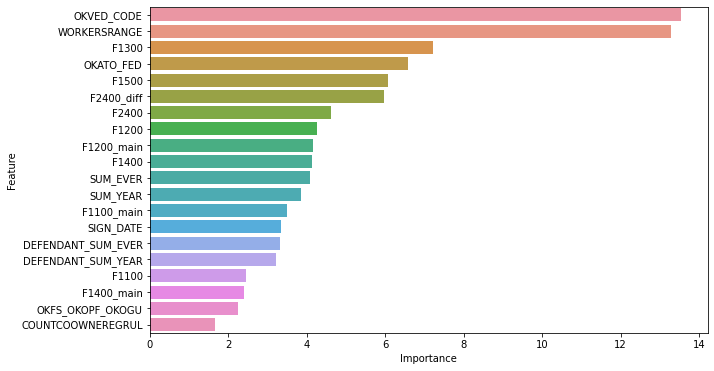

In [127]:
plt.figure(figsize=(10, 6))

df_features = pd.DataFrame(data=cb.feature_importances_, columns=['Importance'])
df_features['Feature'] = X_train_3.columns
df_features = df_features.sort_values(by=['Importance'], ascending=False)

sns.barplot(x=df_features['Importance'], y=df_features['Feature'])

##### Расположение наиболее важных признаков не изменилось.

### Финальное обучение модели

##### Исключим менее важные признаки из обучающего и проверочного наборов данных и выполним финальное обучение модели.

In [128]:
X_train_dpc.shape, X_test_dpc.shape

((12065, 26), (3017, 26))

In [129]:
X_train_dpc = X_train_dpc.drop(columns=['TAXREG', 'IP_flag', 'COUNTBRANCHEGRUL', 'COUNT_CHANGE', 'F1500_main',
                                        'F1300_main']).copy()
X_test_dpc = X_test_dpc.drop(columns=['TAXREG', 'IP_flag', 'COUNTBRANCHEGRUL', 'COUNT_CHANGE', 'F1500_main', 'F1300_main']).copy()

X_train_dpc.shape, X_test_dpc.shape

((12065, 20), (3017, 20))

##### Колличество признаков уменьшилось до 20 штук.

In [130]:
%%time

cat_features_2 = ['OKATO_FED', 'WORKERSRANGE', 'OKVED_CODE', 'F1100_main', 'F1200_main', 'F1400_main', 'OKFS_OKOPF_OKOGU']

cb = catboost.CatBoostClassifier(random_state=settings_random_state,
                                cat_features=cat_features_2,
                                task_type='GPU')

cb.fit(X_train_dpc, y_train_dpc)

Learning rate set to 0.029396
0:	learn: 0.6783756	total: 51.2ms	remaining: 51.2s
1:	learn: 0.6649077	total: 102ms	remaining: 50.8s
2:	learn: 0.6530413	total: 144ms	remaining: 48s
3:	learn: 0.6414778	total: 191ms	remaining: 47.7s
4:	learn: 0.6299935	total: 235ms	remaining: 46.7s
5:	learn: 0.6195945	total: 279ms	remaining: 46.3s
6:	learn: 0.6103314	total: 323ms	remaining: 45.9s
7:	learn: 0.6019453	total: 366ms	remaining: 45.4s
8:	learn: 0.5933623	total: 409ms	remaining: 45s
9:	learn: 0.5844629	total: 451ms	remaining: 44.7s
10:	learn: 0.5762253	total: 495ms	remaining: 44.5s
11:	learn: 0.5694004	total: 539ms	remaining: 44.4s
12:	learn: 0.5630681	total: 584ms	remaining: 44.3s
13:	learn: 0.5572661	total: 628ms	remaining: 44.2s
14:	learn: 0.5515740	total: 672ms	remaining: 44.1s
15:	learn: 0.5452328	total: 717ms	remaining: 44.1s
16:	learn: 0.5389727	total: 759ms	remaining: 43.9s
17:	learn: 0.5338583	total: 806ms	remaining: 44s
18:	learn: 0.5287131	total: 853ms	remaining: 44s
19:	learn: 0.52423

162:	learn: 0.3730529	total: 7.08s	remaining: 36.4s
163:	learn: 0.3728240	total: 7.12s	remaining: 36.3s
164:	learn: 0.3725766	total: 7.17s	remaining: 36.3s
165:	learn: 0.3722783	total: 7.21s	remaining: 36.2s
166:	learn: 0.3719825	total: 7.25s	remaining: 36.2s
167:	learn: 0.3715256	total: 7.29s	remaining: 36.1s
168:	learn: 0.3710056	total: 7.34s	remaining: 36.1s
169:	learn: 0.3708607	total: 7.38s	remaining: 36.1s
170:	learn: 0.3706344	total: 7.43s	remaining: 36s
171:	learn: 0.3702449	total: 7.47s	remaining: 36s
172:	learn: 0.3698551	total: 7.51s	remaining: 35.9s
173:	learn: 0.3695676	total: 7.55s	remaining: 35.8s
174:	learn: 0.3691701	total: 7.59s	remaining: 35.8s
175:	learn: 0.3689291	total: 7.64s	remaining: 35.8s
176:	learn: 0.3687011	total: 7.68s	remaining: 35.7s
177:	learn: 0.3684340	total: 7.72s	remaining: 35.7s
178:	learn: 0.3683034	total: 7.77s	remaining: 35.6s
179:	learn: 0.3679758	total: 7.81s	remaining: 35.6s
180:	learn: 0.3676911	total: 7.85s	remaining: 35.5s
181:	learn: 0.36

321:	learn: 0.3393522	total: 13.9s	remaining: 29.2s
322:	learn: 0.3392587	total: 13.9s	remaining: 29.2s
323:	learn: 0.3390915	total: 14s	remaining: 29.1s
324:	learn: 0.3390058	total: 14s	remaining: 29.1s
325:	learn: 0.3389029	total: 14s	remaining: 29s
326:	learn: 0.3388622	total: 14.1s	remaining: 29s
327:	learn: 0.3386500	total: 14.1s	remaining: 28.9s
328:	learn: 0.3384752	total: 14.2s	remaining: 28.9s
329:	learn: 0.3382994	total: 14.2s	remaining: 28.9s
330:	learn: 0.3381217	total: 14.3s	remaining: 28.8s
331:	learn: 0.3379673	total: 14.3s	remaining: 28.8s
332:	learn: 0.3376807	total: 14.3s	remaining: 28.7s
333:	learn: 0.3373486	total: 14.4s	remaining: 28.7s
334:	learn: 0.3371896	total: 14.4s	remaining: 28.6s
335:	learn: 0.3370670	total: 14.5s	remaining: 28.6s
336:	learn: 0.3370055	total: 14.5s	remaining: 28.6s
337:	learn: 0.3368091	total: 14.6s	remaining: 28.5s
338:	learn: 0.3366980	total: 14.6s	remaining: 28.5s
339:	learn: 0.3364878	total: 14.6s	remaining: 28.4s
340:	learn: 0.3362740	

480:	learn: 0.3191549	total: 20.6s	remaining: 22.2s
481:	learn: 0.3191415	total: 20.7s	remaining: 22.2s
482:	learn: 0.3190413	total: 20.7s	remaining: 22.2s
483:	learn: 0.3190361	total: 20.8s	remaining: 22.1s
484:	learn: 0.3189998	total: 20.8s	remaining: 22.1s
485:	learn: 0.3188072	total: 20.8s	remaining: 22s
486:	learn: 0.3187605	total: 20.9s	remaining: 22s
487:	learn: 0.3187516	total: 20.9s	remaining: 22s
488:	learn: 0.3185710	total: 21s	remaining: 21.9s
489:	learn: 0.3185083	total: 21s	remaining: 21.9s
490:	learn: 0.3183597	total: 21.1s	remaining: 21.9s
491:	learn: 0.3182764	total: 21.1s	remaining: 21.8s
492:	learn: 0.3181878	total: 21.2s	remaining: 21.8s
493:	learn: 0.3180666	total: 21.2s	remaining: 21.7s
494:	learn: 0.3179923	total: 21.3s	remaining: 21.7s
495:	learn: 0.3178757	total: 21.3s	remaining: 21.7s
496:	learn: 0.3176587	total: 21.4s	remaining: 21.6s
497:	learn: 0.3174929	total: 21.4s	remaining: 21.6s
498:	learn: 0.3173951	total: 21.4s	remaining: 21.5s
499:	learn: 0.3173516	

641:	learn: 0.3067131	total: 27.5s	remaining: 15.4s
642:	learn: 0.3067084	total: 27.6s	remaining: 15.3s
643:	learn: 0.3067066	total: 27.6s	remaining: 15.3s
644:	learn: 0.3066018	total: 27.7s	remaining: 15.2s
645:	learn: 0.3065933	total: 27.7s	remaining: 15.2s
646:	learn: 0.3065880	total: 27.7s	remaining: 15.1s
647:	learn: 0.3065527	total: 27.8s	remaining: 15.1s
648:	learn: 0.3065485	total: 27.8s	remaining: 15s
649:	learn: 0.3065094	total: 27.9s	remaining: 15s
650:	learn: 0.3065072	total: 27.9s	remaining: 15s
651:	learn: 0.3064447	total: 27.9s	remaining: 14.9s
652:	learn: 0.3064341	total: 28s	remaining: 14.9s
653:	learn: 0.3064292	total: 28s	remaining: 14.8s
654:	learn: 0.3064216	total: 28.1s	remaining: 14.8s
655:	learn: 0.3062914	total: 28.1s	remaining: 14.7s
656:	learn: 0.3062664	total: 28.2s	remaining: 14.7s
657:	learn: 0.3062107	total: 28.2s	remaining: 14.7s
658:	learn: 0.3062053	total: 28.2s	remaining: 14.6s
659:	learn: 0.3060731	total: 28.3s	remaining: 14.6s
660:	learn: 0.3060429	

801:	learn: 0.2963995	total: 34.3s	remaining: 8.47s
802:	learn: 0.2963517	total: 34.4s	remaining: 8.43s
803:	learn: 0.2963463	total: 34.4s	remaining: 8.39s
804:	learn: 0.2962996	total: 34.5s	remaining: 8.35s
805:	learn: 0.2962569	total: 34.5s	remaining: 8.3s
806:	learn: 0.2962182	total: 34.5s	remaining: 8.26s
807:	learn: 0.2961685	total: 34.6s	remaining: 8.22s
808:	learn: 0.2961532	total: 34.6s	remaining: 8.17s
809:	learn: 0.2961380	total: 34.7s	remaining: 8.13s
810:	learn: 0.2961213	total: 34.7s	remaining: 8.09s
811:	learn: 0.2960619	total: 34.7s	remaining: 8.04s
812:	learn: 0.2960579	total: 34.8s	remaining: 8s
813:	learn: 0.2960281	total: 34.8s	remaining: 7.96s
814:	learn: 0.2959589	total: 34.9s	remaining: 7.92s
815:	learn: 0.2959300	total: 34.9s	remaining: 7.87s
816:	learn: 0.2958886	total: 35s	remaining: 7.83s
817:	learn: 0.2957070	total: 35s	remaining: 7.79s
818:	learn: 0.2956657	total: 35s	remaining: 7.74s
819:	learn: 0.2956385	total: 35.1s	remaining: 7.7s
820:	learn: 0.2956317	t

962:	learn: 0.2902945	total: 41.1s	remaining: 1.58s
963:	learn: 0.2902927	total: 41.1s	remaining: 1.53s
964:	learn: 0.2901933	total: 41.2s	remaining: 1.49s
965:	learn: 0.2901875	total: 41.2s	remaining: 1.45s
966:	learn: 0.2901702	total: 41.2s	remaining: 1.41s
967:	learn: 0.2901688	total: 41.3s	remaining: 1.36s
968:	learn: 0.2901091	total: 41.3s	remaining: 1.32s
969:	learn: 0.2900972	total: 41.4s	remaining: 1.28s
970:	learn: 0.2900935	total: 41.4s	remaining: 1.24s
971:	learn: 0.2900898	total: 41.5s	remaining: 1.19s
972:	learn: 0.2900570	total: 41.5s	remaining: 1.15s
973:	learn: 0.2900249	total: 41.5s	remaining: 1.11s
974:	learn: 0.2899860	total: 41.6s	remaining: 1.07s
975:	learn: 0.2899834	total: 41.6s	remaining: 1.02s
976:	learn: 0.2899269	total: 41.7s	remaining: 981ms
977:	learn: 0.2898029	total: 41.7s	remaining: 938ms
978:	learn: 0.2897437	total: 41.8s	remaining: 896ms
979:	learn: 0.2896829	total: 41.8s	remaining: 853ms
980:	learn: 0.2896288	total: 41.8s	remaining: 810ms
981:	learn: 

In [131]:
%%time

y_pred = cb.predict(X_test_dpc)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1929
           1       0.80      0.78      0.79      1088

    accuracy                           0.85      3017
   macro avg       0.84      0.84      0.84      3017
weighted avg       0.85      0.85      0.85      3017

Wall time: 14 ms


##### Анализ результатов прогнозирования на "боевых" данных показал, что модель демонстрирует f1-score 0.88 и 0.79 для класса "0" и "1" соответственно.

##### Однако финальную оценку результатов должен дать заказчик.